# Phase 4: Clustering_K-Prototypes

## Overview
This notebook implements **unsupervised population segmentation** using K-Prototypes clustering to discover latent diabetes risk phenotypes from mixed-type behavioral data (80/20 train-test split). The derived cluster assignments serve as risk stratification labels for downstream supervised classification modeling.

**Methodological Rationale:**  
K-Prototypes extends K-Means to handle heterogeneous feature spaces by combining Euclidean distance (continuous features) with Hamming distance (categorical features) via the $\gamma$ weighting parameter. This approach avoids information loss from categorical encoding while preserving semantic relationships in mixed-type health data.

**Core Objectives:**
- **ReliefF Feature Selection**: Extract discriminative behavioral features from 21 candidates (11 continuous, 10 categorical) using supervised relevance-based feature weighting with NUMBA-accelerated parallel computation
- **Optimal K Determination**: A three-stage hierarchical strategy involving gamma calibration for metric balancing, broad screening to identify top-3 candidates, and final refinement on a 45% mini-batch to isolate the optimal model
- **Ablation Study**: Validate mixed-type superiority against single-modality baselines (K-Means: continuous-only; K-Modes: categorical-only; K-Prototypes: mixed-type with gamma tuning)
- **Risk Index Construction**: Quantitative diabetes probability-based risk scoring (0-100 scale) per cluster using weighted composite of prevalence, comorbidity burden, and protective factor deficits
- **Social Equity Validation**: Statistical independence testing to verify clustering immunity from socioeconomic confounders
- **Bootstrap Stability Audit**: Assess clustering robustness via stratified resampling using Adjusted Rand Index (ARI) as stability metric
- **Visual Analytics**: Multi-perspective synthesis utilizing UMAP/t-SNE manifolds, archetype heatmaps, and radar charts to quantify cluster-specific risk signatures and ensure high clinical interpretability
## Table of Contents
1. Environment Configuration
2. Path Configuration and Constants
3. Feature Set Definition
4. Data Loading and Validation
5. ReliefF Feature Selection
6. Data Preparation for Clustering
7. Optimal K Determination
8. Visualization of Optimal K
9. Ablation Study: Baseline Comparison (K-Prototypes vs K-Means vs K-Modes)
10. Cluster Profiling and Risk Assessment
11. Risk Index Construction
12. Risk Index Logic Verification: Protective Feature Validation
13. Social Equity Validation
14. Cluster Stability Audit
15. Statistical Testing of Cluster Differences
16. Enhanced Visual Analytics & Clinical Interpretation
17. Explainable Clustering: Global Surrogate Decision Tree
18. Export Enhanced Classification Data
19. Targeted Intervention Policy Mapping
20. Pipeline Summary

**Output Files:**
- `data/processed/clustering_k-prototypes/CDC_Train_Classification_CLUSTERED.csv`: Training set with Cluster_ID and Risk_Index
- `data/processed/clustering_k-prototypes/CDC_Test_Classification_CLUSTERED.csv`: Test set with Cluster_ID and Risk_Index

---
## 1. Environment Configuration

In [56]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
from typing import Dict, List, Tuple

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.feature_selection import mutual_info_classif
from kmodes.kprototypes import KPrototypes
from scipy.spatial.distance import cdist
from scipy import stats

# OPTIONAL: UMAP for high-dimensional visualization (faster than t-SNE)
try:
    from umap import UMAP
    print("UMAP enabled for fast manifold learning")
except ImportError:
    print("UMAP not available (using t-SNE fallback)")

# OPTIONAL: Intel Extension for Scikit-learn (CPU acceleration)
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
    print("Intel Extension for Scikit-learn enabled")
except ImportError:
    print("Intel Extension not available (optional)")


np.random.seed(42)
print(f"NumPy: {np.__version__} | Pandas: {pd.__version__}")

print("Environment initialized")

plt.style.use('seaborn-v0_8-darkgrid')

sns.set_palette('husl')
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

UMAP enabled for fast manifold learning
Intel Extension for Scikit-learn enabled
NumPy: 2.3.5 | Pandas: 3.0.0
Environment initialized


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


---
## 2. Path Configuration and Constants

In [57]:
RANDOM_STATE = 42
MAX_ITER = 100
K_RANGE = range(2, 11)
N_INIT = 20

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'data' / 'processed'
FEATURE_DATA_DIR = DATA_DIR / 'feature_engineering'
CLUSTERING_OUTPUT_DIR = DATA_DIR / 'clustering_k-prototypes'
OUTPUT_DIR = BASE_DIR / 'outputs' / 'clustering_k-prototypes'

# Create organized subdirectories for production-ready outputs
OUTPUT_IMAGES_DIR = OUTPUT_DIR / 'images'
OUTPUT_MODELS_DIR = OUTPUT_DIR / 'models'
OUTPUT_TABLES_DIR = OUTPUT_DIR / 'tables'

CLUSTERING_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_MODELS_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_TABLES_DIR.mkdir(parents=True, exist_ok=True)

CLUSTERING_RAW = FEATURE_DATA_DIR / 'CDC_Clustering_RAW.csv'
TRAIN_DATA = FEATURE_DATA_DIR / 'CDC_Train_Classification_BASELINE.csv'
TEST_DATA = FEATURE_DATA_DIR / 'CDC_Test_Classification_BASELINE.csv'
METADATA = BASE_DIR / 'outputs' / 'feature_engineering' / 'feature_metadata.json'

CLUSTER_TRAIN_OUTPUT = CLUSTERING_OUTPUT_DIR / 'CDC_Train_Classification_CLUSTERED.csv'
CLUSTER_TEST_OUTPUT = CLUSTERING_OUTPUT_DIR / 'CDC_Test_Classification_CLUSTERED.csv'
CLUSTER_PROFILE_OUTPUT = OUTPUT_TABLES_DIR / 'cluster_profiles.json'
FEATURE_IMPORTANCE_OUTPUT = OUTPUT_TABLES_DIR / 'relieff_weights.csv'

print(f"[SEARCH PARAMS] K range: {list(K_RANGE)} | Random state: {RANDOM_STATE}")

# Model serialization paths
print(f"[PATH CONFIG] Statistical tables: {OUTPUT_TABLES_DIR}")

OPTIMAL_MODEL_PATH = OUTPUT_MODELS_DIR / 'kprototypes_optimal.pkl'
print(f"[PATH CONFIG] Serialized models: {OUTPUT_MODELS_DIR}")

SURROGATE_TREE_PATH = OUTPUT_MODELS_DIR / 'surrogate_tree.pkl'
print(f"[PATH CONFIG] Visualizations: {OUTPUT_IMAGES_DIR}")

OPTIMAL_GAMMA_PATH = OUTPUT_MODELS_DIR / 'optimal_gamma.json'
print(f"[PATH CONFIG] Clustering output: {CLUSTERING_OUTPUT_DIR}")


[SEARCH PARAMS] K range: [2, 3, 4, 5, 6, 7, 8, 9, 10] | Random state: 42
[PATH CONFIG] Statistical tables: D:\ProgramSoftware\PyCharm\WorkPlace\DiaMetric-CDC\outputs\clustering_k-prototypes\tables
[PATH CONFIG] Serialized models: D:\ProgramSoftware\PyCharm\WorkPlace\DiaMetric-CDC\outputs\clustering_k-prototypes\models
[PATH CONFIG] Visualizations: D:\ProgramSoftware\PyCharm\WorkPlace\DiaMetric-CDC\outputs\clustering_k-prototypes\images
[PATH CONFIG] Clustering output: D:\ProgramSoftware\PyCharm\WorkPlace\DiaMetric-CDC\data\processed\clustering_k-prototypes


---
## 3. Feature Set Definition

In [58]:
# Feature Set Organization: Strict Separation of Behavioral and Socioeconomic
# CRITICAL: Income, Education, NoDocbcCost are EXCLUDED from clustering inputs

SOCIOECONOMIC_FEATURES = ['Income', 'Education', 'NoDocbcCost']

# BEHAVIORAL_FEATURES: Used for ReliefF and clustering (21 features)
BEHAVIORAL_FEATURES = [
    'HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
    'GenHlth', 'DiffWalk', 'Sex',
    'MentHlth_Cat', 'PhysHlth_Cat',
    'Age_BMI_Interaction', 'CVD_Risk', 'MetSyn_Risk',
    'Chronic_Count', 'Lifestyle_Score', 'Risk_Behavior',
    'BMI_Squared', 'Health_Imbalance'
]

# Feature type definitions for BEHAVIORAL features only
# Note: Ordinal/count variables use continuous distance to preserve numeric gradients
BEHAVIORAL_CATEGORICAL = [
    'HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
    'DiffWalk', 'Sex'
]

BEHAVIORAL_CONTINUOUS = [
    'GenHlth',           # 1-5: health status gradient (ordinal with clear progression)
    'MentHlth_Cat',      # 0-2: mental health day intervals (ordinal)
    'PhysHlth_Cat',      # 0-2: physical health day intervals (ordinal)
    'CVD_Risk',          # 0-3: cardiovascular risk score (count/ordinal)
    'MetSyn_Risk',       # 0-3: metabolic syndrome risk score (count/ordinal)
    'Chronic_Count',     # 0-4: chronic condition count (numeric count)
    'Lifestyle_Score',   # 0-3: lifestyle health score (ordinal)
    'Risk_Behavior',     # 0-2: risk behavior count (numeric count)
    'Health_Imbalance',  # 0-2: health imbalance indicator (ordinal)
    'Age_BMI_Interaction',  # continuous interaction term
    'BMI_Squared'        # continuous polynomial term
]

# Legacy aliases for backward compatibility
CATEGORICAL_FEATURES = BEHAVIORAL_CATEGORICAL.copy()
CONTINUOUS_FEATURES = BEHAVIORAL_CONTINUOUS.copy()

print(f"Behavioral features: {len(BEHAVIORAL_FEATURES)}")
print(f"Categorical: {len(CATEGORICAL_FEATURES)} | Continuous: {len(CONTINUOUS_FEATURES)}")
print(f"Excluded socioeconomic: {SOCIOECONOMIC_FEATURES}")

Behavioral features: 21
Categorical: 10 | Continuous: 11
Excluded socioeconomic: ['Income', 'Education', 'NoDocbcCost']


---
## 4. Data Loading and Validation

In [59]:
df_raw = pd.read_csv(CLUSTERING_RAW)
df_train = pd.read_csv(TRAIN_DATA)
df_test = pd.read_csv(TEST_DATA)

# Sort by Original_Index to ensure alignment across dataframes
df_raw = df_raw.sort_values('Original_Index').reset_index(drop=True)
df_train = df_train.sort_values('Original_Index').reset_index(drop=True)
df_test = df_test.sort_values('Original_Index').reset_index(drop=True)

with open(METADATA, 'r') as f:
    metadata = json.load(f)

print(f"Raw clustering data: {df_raw.shape}")
print(f"Training set: {df_train.shape}")
print(f"Test set: {df_test.shape}")
print(f"Sorted by Original_Index for alignment")

print(f"\nSplit distribution:")
print(df_raw['split'].value_counts())

assert df_raw['split'].notna().all(), "Missing split labels"
assert set(df_raw['split'].unique()) == {'train', 'test'}, "Invalid split values"
assert all(df_raw[df_raw['split']=='train']['Original_Index'].values == df_train['Original_Index'].values), \
    "Index misalignment detected"
print("\nData integrity and index alignment confirmed")

Raw clustering data: (229296, 26)
Training set: (183436, 27)
Test set: (45860, 27)
Sorted by Original_Index for alignment

Split distribution:
split
train    183436
test      45860
Name: count, dtype: int64

Data integrity and index alignment confirmed


---
## 5. ReliefF Feature Selection

In [60]:
def compute_relieff_weights(X: pd.DataFrame, y: pd.Series, k: int = 30, 
                           sample_size: int = 50000) -> pd.Series:
    """
    Compute ReliefF feature weights for mixed-type data using Manhattan distance.
    
    Improvements over vanilla ReliefF:
    1. Stratified sampling to ensure class balance (diabetes vs non-diabetes)
    2. Manhattan distance (L1) instead of Euclidean (L2) for better categorical handling
    3. Separate distance computation for categorical vs continuous features
    4. Optimized sample size for computational efficiency
    5. NUMBA JIT compilation with parallel execution for additional speedup
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target variable (binary)
    k : int
        Number of nearest neighbors (default: 30 for comprehensive representation)
    sample_size : int
        Number of samples to use for weight computation (default: 50000)
    
    Returns
    -------
    pd.Series
        Feature weights (higher = more important for class discrimination)
    """
    from sklearn.neighbors import NearestNeighbors
    from numba import njit, prange
    
    @njit(parallel=True, fastmath=True)
    def compute_weights_parallel(X_sample_np, y_sample_np, neighbor_indices_all, 
                                 categorical_indices, continuous_indices, n_samples, n_features, k):
        """
        Numba-compiled parallel weight computation.
        
        Parameters:
        - X_sample_np: Feature matrix (n_samples, n_features)
        - y_sample_np: Target labels (n_samples,)
        - neighbor_indices_all: Pre-computed neighbor indices (n_samples, k+1)
        - categorical_indices: Array of categorical feature indices
        - continuous_indices: Array of continuous feature indices
        - n_samples, n_features, k: Dimensions
        
        Returns:
        - weights: Feature importance weights (n_features,)
        """
        weights = np.zeros(n_features)
        
        # Pre-compute feature ranges for continuous features (avoid repeated computation)
        col_ranges = np.zeros(n_features)
        for idx in continuous_indices:
            col_range = X_sample_np[:, idx].max() - X_sample_np[:, idx].min()
            col_ranges[idx] = col_range if col_range > 0 else 1.0  # Avoid division by zero
        
        # Parallel loop over samples
        for i in prange(n_samples):
            neighbor_indices = neighbor_indices_all[i, 1:]  # Exclude self (first element)
            
            # Separate same-class and different-class neighbors
            same_class_mask = y_sample_np[neighbor_indices] == y_sample_np[i]
            diff_class_mask = ~same_class_mask
            
            # Vectorized difference computation using broadcasting
            # Shape: (k, n_features) - compute differences for all neighbors at once
            neighbor_data = X_sample_np[neighbor_indices]
            sample_data = X_sample_np[i]
            
            # Process same-class neighbors
            if same_class_mask.any():
                same_class_data = neighbor_data[same_class_mask]
                n_same = same_class_data.shape[0]
                
                for col_idx in range(n_features):
                    if col_idx in categorical_indices:
                        # Categorical: Hamming distance (0 or 1)
                        same_diff = np.sum(same_class_data[:, col_idx] != sample_data[col_idx]) / n_same
                    else:
                        # Continuous: Manhattan distance (normalized)
                        same_diff = np.sum(np.abs(same_class_data[:, col_idx] - sample_data[col_idx])) / (n_same * col_ranges[col_idx])
                    
                    # Penalize feature if it differs within same class
                    weights[col_idx] -= same_diff / n_samples
            
            # Process different-class neighbors
            if diff_class_mask.any():
                diff_class_data = neighbor_data[diff_class_mask]
                n_diff = diff_class_data.shape[0]
                
                for col_idx in range(n_features):
                    if col_idx in categorical_indices:
                        # Categorical: Hamming distance (0 or 1)
                        diff_diff = np.sum(diff_class_data[:, col_idx] != sample_data[col_idx]) / n_diff
                    else:
                        # Continuous: Manhattan distance (normalized)
                        diff_diff = np.sum(np.abs(diff_class_data[:, col_idx] - sample_data[col_idx])) / (n_diff * col_ranges[col_idx])
                    
                    # Reward feature if it differs across different classes
                    weights[col_idx] += diff_diff / n_samples
        
        return weights
    
    n_samples, n_features = X.shape
    
    # Reset indices to ensure alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Stratified sampling: ensure balanced diabetes positive/negative samples
    pos_indices = y[y == 1].index.values
    neg_indices = y[y == 0].index.values
    
    n_pos_sample = min(sample_size // 2, len(pos_indices))
    n_neg_sample = min(sample_size // 2, len(neg_indices))
    
    sampled_pos = np.random.choice(pos_indices, size=n_pos_sample, replace=False)
    sampled_neg = np.random.choice(neg_indices, size=n_neg_sample, replace=False)
    sampled_indices = np.concatenate([sampled_pos, sampled_neg])
    np.random.shuffle(sampled_indices)
    
    X_sample = X.iloc[sampled_indices].reset_index(drop=True)
    y_sample = y.iloc[sampled_indices].reset_index(drop=True)
    
    # Convert to NumPy arrays
    feature_names = X_sample.columns.tolist()
    categorical_indices_relieff = np.array([i for i, col in enumerate(feature_names) if col in CATEGORICAL_FEATURES], dtype=np.int64)
    continuous_indices_relieff = np.array([i for i, col in enumerate(feature_names) if col in CONTINUOUS_FEATURES], dtype=np.int64)
    
    X_sample_np = X_sample.values.astype(np.float64)  # Numba requires consistent dtype
    y_sample_np = y_sample.values.astype(np.int64)
    
    # Normalize continuous features for distance computation
    X_normalized = X_sample_np.copy()
    for idx in continuous_indices_relieff:
        col_range = X_sample_np[:, idx].max() - X_sample_np[:, idx].min()
        if col_range > 0:
            X_normalized[:, idx] = (X_sample_np[:, idx] - X_sample_np[:, idx].min()) / col_range
    
    # Use sklearn NearestNeighbors to pre-compute all neighbor indices
    print(f"[RELIEFF] Processing {len(X_sample)} stratified samples with k={k} neighbors...")
    print(f"[RELIEFF] NUMBA JIT compilation + parallel execution enabled")
    print(f"[RELIEFF] Pre-computing neighbor indices with KD-Tree (optimized for <50 features)...")
    
    # OPTIMIZATION: Explicitly use kd_tree for <50 features (O(log n) query vs O(n) brute)
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='manhattan', algorithm='kd_tree')
    nbrs.fit(X_normalized)
    
    # Pre-compute ALL neighbor indices at once (vectorized operation)
    distances, neighbor_indices_all = nbrs.kneighbors(X_normalized)
    
    print(f"[RELIEFF] Compiling Numba JIT function (first run only, ~5 seconds)...")
    print(f"[RELIEFF] Running parallel weight computation...")
    
    # Call Numba-compiled parallel function
    weights = compute_weights_parallel(
        X_sample_np, 
        y_sample_np, 
        neighbor_indices_all, 
        categorical_indices_relieff, 
        continuous_indices_relieff,
        len(X_sample), 
        n_features, 
        k
    )
    
    # Return raw weights (NOT normalized to [0,1])
    # Rationale: Absolute discrimination power matters more than relative ranking
    # If all features have poor discrimination, normalization artificially inflates the best one
    # Raw weights preserve the absolute magnitude of discrimination ability
    return pd.Series(weights, index=X.columns)


print("[FEATURE SELECTION] Computing ReliefF weights...")
print("[METHOD] Manhattan distance + stratified sampling for class balance")
print("[OPTIMIZATION] Numba JIT + parallel execution")
print("[CONFIGURATION] 50,000 samples, k=30 neighbors for maximum stability\n")

train_mask = df_raw['split'] == 'train'
X_train_full = df_raw.loc[train_mask, BEHAVIORAL_FEATURES].copy()
y_train_full = df_train['Diabetes_binary'].copy()

assert len(X_train_full) == len(y_train_full), "Length mismatch between features and target"

print(f"[DATA] Total training samples: {len(X_train_full):,}")
print(f"[DATA] Diabetes prevalence: {y_train_full.mean():.2%}")
print(f"[DATA] Class distribution: Positive={y_train_full.sum():,}, Negative={(~y_train_full.astype(bool)).sum():,} (Normal Individuals)\n")

relieff_weights = compute_relieff_weights(X_train_full, y_train_full, k=30, sample_size=50000)
relieff_df = pd.DataFrame({
    'feature': relieff_weights.index,
    'weight': relieff_weights.values
}).sort_values('weight', ascending=False)
print(f"\n[RESULTS] Weight distribution (raw, not normalized):")
print(f"  Mean: {relieff_weights.mean():.6f}")
print(f"  Std:  {relieff_weights.std():.6f}")
print(f"  Min:  {relieff_weights.min():.6f}")
print(f"  Max:  {relieff_weights.max():.6f}")

# Use mean as threshold: features above average discrimination power
WEIGHT_THRESHOLD = relieff_weights.mean()
selected_features = relieff_df[relieff_df['weight'] > WEIGHT_THRESHOLD]['feature'].tolist()

print(f"\n[SELECTION] Threshold = Mean weight = {WEIGHT_THRESHOLD:.6f}")

print(f"[SELECTION] Features above threshold: {len(selected_features)}")
print(f"[SELECTION] Selected features: {selected_features}")

[FEATURE SELECTION] Computing ReliefF weights...
[METHOD] Manhattan distance + stratified sampling for class balance
[OPTIMIZATION] Numba JIT + parallel execution
[CONFIGURATION] 50,000 samples, k=30 neighbors for maximum stability

[DATA] Total training samples: 183,436
[DATA] Diabetes prevalence: 17.27%
[DATA] Class distribution: Positive=31,679, Negative=151,757 (Normal Individuals)

[RELIEFF] Processing 50000 stratified samples with k=30 neighbors...
[RELIEFF] NUMBA JIT compilation + parallel execution enabled
[RELIEFF] Pre-computing neighbor indices with KD-Tree (optimized for <50 features)...
[RELIEFF] Compiling Numba JIT function (first run only, ~5 seconds)...
[RELIEFF] Running parallel weight computation...

[RESULTS] Weight distribution (raw, not normalized):
  Mean: 0.000159
  Std:  0.001749
  Min:  -0.002186
  Max:  0.005166

[SELECTION] Threshold = Mean weight = 0.000159
[SELECTION] Features above threshold: 6
[SELECTION] Selected features: ['GenHlth', 'Age_BMI_Interaction

In [61]:
print(relieff_df)

                 feature    weight
8                GenHlth  0.005166
13   Age_BMI_Interaction  0.004224
15           MetSyn_Risk  0.001193
7      HvyAlcoholConsump  0.001112
19           BMI_Squared  0.000913
3   HeartDiseaseorAttack  0.000452
2                 Stroke  0.000122
16         Chronic_Count  0.000030
14              CVD_Risk -0.000038
1               HighChol -0.000087
0                 HighBP -0.000211
10                   Sex -0.000294
4           PhysActivity -0.000314
5                 Fruits -0.000394
6                Veggies -0.000413
17       Lifestyle_Score -0.000444
9               DiffWalk -0.001043
20      Health_Imbalance -0.001212
11          MentHlth_Cat -0.001336
12          PhysHlth_Cat -0.001902
18         Risk_Behavior -0.002186


---
## 6. Data Preparation for Clustering

In [62]:
# Use BEHAVIORAL_* definitions to ensure no socioeconomic features leak into clustering
FINAL_CATEGORICAL = [f for f in selected_features if f in BEHAVIORAL_CATEGORICAL]
FINAL_CONTINUOUS = [f for f in selected_features if f in BEHAVIORAL_CONTINUOUS]

print(f"[PREP] Final feature set: {len(selected_features)} features")
print(f"[PREP] Categorical: {len(FINAL_CATEGORICAL)} | Continuous: {len(FINAL_CONTINUOUS)}")
print(f"[VALIDATION] No socioeconomic features in clustering inputs: {set(selected_features) & set(SOCIOECONOMIC_FEATURES)}")

X_train = df_raw.loc[train_mask, selected_features].copy()
X_test = df_raw.loc[~train_mask, selected_features].copy()

if len(FINAL_CONTINUOUS) > 0:
    scaler = RobustScaler()
    X_train[FINAL_CONTINUOUS] = scaler.fit_transform(X_train[FINAL_CONTINUOUS])
    X_test[FINAL_CONTINUOUS] = scaler.transform(X_test[FINAL_CONTINUOUS])
    print("[PREP] Continuous features scaled with RobustScaler")

categorical_indices = [selected_features.index(f) for f in FINAL_CATEGORICAL]

print(f"\n[PREP] Training set: {X_train.shape}")
print(f"[PREP] Test set: {X_test.shape}")
print(f"[PREP] Categorical feature indices: {categorical_indices[:5]}...")

# Map names to indices for better interpretability during centroid analysis
cat_feature_names = [selected_features[i] for i in categorical_indices]
print(f"[VERIFY] K-Prototypes will treat these as categorical: {cat_feature_names}")

[PREP] Final feature set: 6 features
[PREP] Categorical: 2 | Continuous: 4
[VALIDATION] No socioeconomic features in clustering inputs: set()
[PREP] Continuous features scaled with RobustScaler

[PREP] Training set: (183436, 6)
[PREP] Test set: (45860, 6)
[PREP] Categorical feature indices: [3, 5]...
[VERIFY] K-Prototypes will treat these as categorical: ['HvyAlcoholConsump', 'HeartDiseaseorAttack']


---
## 7. Optimal K Determination

In [63]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def compute_kprototypes_distance_matrix_vectorized(X: np.ndarray, categorical_indices: List[int], 
                                                   gamma: float) -> np.ndarray:
    """
    Compute pairwise K-Prototypes distance matrix for mixed-type data with VECTORIZED operations.
    
    Distance = sqrt(Euclidean²) + gamma * Hamming
    This is the NATIVE distance metric used by K-Prototypes algorithm.
    
    Mathematical Consistency: K-Prototypes minimizes the objective function:
        J = Σ(d_euclidean² + γ * d_hamming)
    
    Using this function for silhouette score ensures that the evaluation metric
    is mathematically consistent with the clustering algorithm's optimization target.

    Parameters
    ----------
    X : np.ndarray
        Data matrix (n_samples, n_features)
    categorical_indices : List[int]
        Indices of categorical features
    gamma : float
        Weight for categorical features (balances continuous vs categorical contributions)
    
    Returns
    -------
    np.ndarray
        Symmetric pairwise distance matrix (n_samples, n_samples)
        Entry [i,j] = K-Prototypes distance between sample i and j
    """
    n_samples, n_features = X.shape
    categorical_indices_set = set(categorical_indices)
    continuous_indices = np.array([i for i in range(n_features) if i not in categorical_indices_set])
    categorical_indices_arr = np.array(list(categorical_indices))
    
    # Initialize distance matrix (symmetric)
    dist_matrix = np.zeros((n_samples, n_samples), dtype=np.float32)
    
    # COMPONENT 1: Continuous distance (Euclidean)
    if len(continuous_indices) > 0:
        X_cont = X[:, continuous_indices].astype(np.float32)
        # Use scipy's optimized C implementation for pairwise Euclidean distance
        from scipy.spatial.distance import cdist
        cont_dist = cdist(X_cont, X_cont, metric='euclidean')
        dist_matrix += cont_dist
    
    # COMPONENT 2: Categorical distance (Hamming, scaled by gamma)
    if len(categorical_indices_arr) > 0:
        X_cat = X[:, categorical_indices_arr].astype(np.int8)
        
        # VECTORIZED Hamming distance computation using broadcasting
        # Broadcast shape: (n_samples, 1, n_cat_features) vs (1, n_samples, n_cat_features)
        # Result shape: (n_samples, n_samples, n_cat_features) → sum over features
        X_cat_expanded = X_cat[:, np.newaxis, :]  # Shape: (n_samples, 1, n_cat_features)
        mismatches = (X_cat_expanded != X_cat[np.newaxis, :, :]).sum(axis=2)  # Shape: (n_samples, n_samples)
        
        dist_matrix += gamma * mismatches
    
    return dist_matrix


def stratified_sample_by_cluster(X: np.ndarray, clusters: np.ndarray, 
                                 sample_size: int = 5000) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform stratified sampling to maintain cluster distribution.
    Prevents memory overflow in distance-based metrics (O(N^2) -> O(n^2) where n << N).
    
    Parameters
    ----------
    X : np.ndarray
        Data matrix
    clusters : np.ndarray
        Cluster assignments
    sample_size : int
        Target sample size
    
    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Sampled data and cluster labels
    """
    n_total = len(X)
    if n_total <= sample_size:
        return X, clusters
    
    unique_clusters = np.unique(clusters)
    sampled_indices = []
    
    for cluster_id in unique_clusters:
        cluster_indices = np.where(clusters == cluster_id)[0]
        cluster_size = len(cluster_indices)
        n_sample = max(1, int(sample_size * cluster_size / n_total))
        n_sample = min(n_sample, cluster_size)
        
        sampled = np.random.choice(cluster_indices, size=n_sample, replace=False)
        sampled_indices.extend(sampled)
    
    sampled_indices = np.array(sampled_indices)
    return X[sampled_indices], clusters[sampled_indices]


def compute_kprototypes_cost(X: np.ndarray, clusters: np.ndarray, 
                            centroids: np.ndarray, categorical_indices: List[int],
                            gamma: float = None) -> float:
    """
    Compute K-Prototypes cost function with vectorized operations.
    
    Cost = sum of distances from each point to its cluster centroid
    Distance = Euclidean (continuous) + gamma * Hamming (categorical)
    
    OPTIMIZATION: Vectorized computation using NumPy broadcasting
    - No Python loops: Use advanced indexing to gather centroids for all samples at once
    - Broadcast operations: Compute all distances simultaneously
    - Memory efficient: Single pass through data
    
    Parameters
    ----------
    X : np.ndarray
        Data matrix (n_samples, n_features)
    clusters : np.ndarray
        Cluster assignments (n_samples,)
    centroids : np.ndarray
        Cluster centroids (n_clusters, n_features)
    categorical_indices : List[int]
        Indices of categorical features
    gamma : float
        Weight for categorical features (if None, uses default formula)
    
    Returns
    -------
    float
        Total cost
    """
    n_samples, n_features = X.shape
    categorical_indices_set = set(categorical_indices)
    continuous_indices = np.array([i for i in range(n_features) if i not in categorical_indices_set])
    categorical_indices_arr = np.array(list(categorical_indices))
    
    # Auto-compute gamma if not provided (standard K-Prototypes formula)
    if gamma is None and len(continuous_indices) > 0:
        gamma = 0.5 * np.std(X[:, continuous_indices])
    elif gamma is None:
        gamma = 1.0
    
    # VECTORIZED COMPUTATION: Use advanced indexing to gather all centroids at once
    # Shape: (n_samples, n_features) - each row is the centroid for that sample's cluster
    assigned_centroids = centroids[clusters]
    
    total_cost = 0.0
    
    # Continuous distance: Vectorized Euclidean squared
    if len(continuous_indices) > 0:
        # Shape: (n_samples, n_continuous_features)
        X_cont = X[:, continuous_indices]
        centroids_cont = assigned_centroids[:, continuous_indices]
        
        # Broadcast subtraction + element-wise square + sum along features
        cont_dist = np.sum((X_cont - centroids_cont) ** 2, axis=1)  # Shape: (n_samples,)
        total_cost += np.sum(cont_dist)
    
    # Categorical distance: Vectorized Hamming
    if len(categorical_indices_arr) > 0:
        # Shape: (n_samples, n_categorical_features)
        X_cat = X[:, categorical_indices_arr]
        centroids_cat = assigned_centroids[:, categorical_indices_arr]
        
        # Element-wise comparison + sum along features
        cat_dist = np.sum(X_cat != centroids_cat, axis=1)  # Shape: (n_samples,)
        total_cost += gamma * np.sum(cat_dist)
    
    return total_cost


# ============================================================================
# DATA PREPARATION
# ============================================================================

print("[OPTIMIZATION] Three-stage optimization strategy:")
print("[INFO] Stage 1: Gamma optimization on 10% sample (K=3, 12 gamma tests)")
print("[INFO] Stage 2: K value screening on 20% sample (9 K values, optimal gamma)")
print("[INFO] Stage 3: Final refinement on 45% sample (top 3 K, high n_init)\n")

results = []
models = {}

# ============================================================================
# Type Compaction
# ============================================================================
# Convert to compact types: int8 for categorical (0/1 or low-cardinality), float32 for continuous
X_train_array = X_train.values.copy()

# Apply type compaction
for idx, feat in enumerate(selected_features):
    if feat in FINAL_CATEGORICAL:
        # Categorical features: convert to int8
        X_train_array[:, idx] = X_train_array[:, idx].astype(np.int8)
    else:
        # Continuous features: convert to float32
        X_train_array[:, idx] = X_train_array[:, idx].astype(np.float32)

print(f"[MEMORY] Type compaction applied:")
print(f"  Categorical features: {len(FINAL_CATEGORICAL)} → int8")
print(f"  Continuous features: {len(FINAL_CONTINUOUS)} → float32")
print(f"  Memory reduction: ~{(1 - (len(FINAL_CATEGORICAL) * 1 + len(FINAL_CONTINUOUS) * 4) / (len(selected_features) * 8)) * 100:.1f}%")

# Force contiguous memory layout for better cache performance
X_train_array = np.ascontiguousarray(X_train_array)
print(f"[MEMORY] Contiguous array layout enforced (cache optimization)\n")

# ============================================================================
# Global Evaluation Set
# ============================================================================
# Create a unified evaluation set for fair comparison across all stages

GLOBAL_EVAL_SIZE = 12000  # Balanced between quality and computational cost

# Stratified sampling based on diabetes prevalence
y_train_array = y_train_full.values
pos_indices = np.where(y_train_array == 1)[0]
neg_indices = np.where(y_train_array == 0)[0]

n_pos_eval = int(GLOBAL_EVAL_SIZE * y_train_array.mean())
n_neg_eval = GLOBAL_EVAL_SIZE - n_pos_eval

eval_pos_indices = np.random.choice(pos_indices, size=min(n_pos_eval, len(pos_indices)), replace=False)
eval_neg_indices = np.random.choice(neg_indices, size=min(n_neg_eval, len(neg_indices)), replace=False)
eval_indices = np.concatenate([eval_pos_indices, eval_neg_indices])
np.random.shuffle(eval_indices)

X_eval_global = np.ascontiguousarray(X_train_array[eval_indices])

print(f"[GLOBAL EVAL SET] Created unified evaluation set:")
print(f"  Size: {len(X_eval_global):,} samples ({len(X_eval_global)/len(X_train_array)*100:.1f}% of training set)")
print(f"  Diabetes prevalence: {y_train_array[eval_indices].mean():.2%} (matches training distribution)")
print(f"  Usage: Unified cost/metric computation for fair comparison across all stages\n")

# ============================================================================
# Create Stratified Samples for Each Stage
# ============================================================================

# Stage 1: 10% sample for gamma optimization
STAGE1_SAMPLE_RATIO = 0.1
n_stage1_sample = int(len(X_train_array) * STAGE1_SAMPLE_RATIO)
n_pos_stage1 = int(n_stage1_sample * y_train_array.mean())
n_neg_stage1 = n_stage1_sample - n_pos_stage1

stage1_pos_indices = np.random.choice(pos_indices, size=min(n_pos_stage1, len(pos_indices)), replace=False)
stage1_neg_indices = np.random.choice(neg_indices, size=min(n_neg_stage1, len(neg_indices)), replace=False)
stage1_sample_indices = np.concatenate([stage1_pos_indices, stage1_neg_indices])
np.random.shuffle(stage1_sample_indices)
X_stage1_sample = X_train_array[stage1_sample_indices]

print(f"[STAGE 1 SAMPLE] Created for gamma optimization:")
print(f"  Size: {len(X_stage1_sample):,} samples ({STAGE1_SAMPLE_RATIO*100:.0f}% of training set)")
print(f"  Diabetes prevalence: {y_train_array[stage1_sample_indices].mean():.2%}")
print(f"  Purpose: Fast gamma grid search with K=3\n")

# Stage 2: 20% sample for K value screening
STAGE2_SAMPLE_RATIO = 0.2
n_stage2_sample = int(len(X_train_array) * STAGE2_SAMPLE_RATIO)
n_pos_stage2 = int(n_stage2_sample * y_train_array.mean())
n_neg_stage2 = n_stage2_sample - n_pos_stage2

stage2_pos_indices = np.random.choice(pos_indices, size=min(n_pos_stage2, len(pos_indices)), replace=False)
stage2_neg_indices = np.random.choice(neg_indices, size=min(n_neg_stage2, len(neg_indices)), replace=False)
stage2_sample_indices = np.concatenate([stage2_pos_indices, stage2_neg_indices])
np.random.shuffle(stage2_sample_indices)
X_stage2_sample = X_train_array[stage2_sample_indices]

print(f"[STAGE 2 SAMPLE] Created for K value screening:")
print(f"  Size: {len(X_stage2_sample):,} samples ({STAGE2_SAMPLE_RATIO*100:.0f}% of training set)")
print(f"  Diabetes prevalence: {y_train_array[stage2_sample_indices].mean():.2%}")
print(f"  Purpose: Quick K screening with optimal gamma\n")

# Stage 3: 45% sample for final refinement
STAGE3_SAMPLE_RATIO = 0.45
n_stage3_sample = int(len(X_train_array) * STAGE3_SAMPLE_RATIO)
n_pos_stage3 = int(n_stage3_sample * y_train_array.mean())
n_neg_stage3 = n_stage3_sample - n_pos_stage3

stage3_pos_indices = np.random.choice(pos_indices, size=min(n_pos_stage3, len(pos_indices)), replace=False)
stage3_neg_indices = np.random.choice(neg_indices, size=min(n_neg_stage3, len(neg_indices)), replace=False)
stage3_sample_indices = np.concatenate([stage3_pos_indices, stage3_neg_indices])
np.random.shuffle(stage3_sample_indices)
X_stage3_sample = X_train_array[stage3_sample_indices]

print(f"[STAGE 3 SAMPLE] Created for final refinement:")
print(f"  Size: {len(X_stage3_sample):,} samples ({STAGE3_SAMPLE_RATIO*100:.0f}% of training set)")
print(f"  Diabetes prevalence: {y_train_array[stage3_sample_indices].mean():.2%}")
print(f"  Purpose: High-quality final models with increased n_init\n")

print("[DATA PREP COMPLETE] All samples created with stratified diabetes prevalence")

[OPTIMIZATION] Three-stage optimization strategy:
[INFO] Stage 1: Gamma optimization on 10% sample (K=3, 12 gamma tests)
[INFO] Stage 2: K value screening on 20% sample (9 K values, optimal gamma)
[INFO] Stage 3: Final refinement on 45% sample (top 3 K, high n_init)

[MEMORY] Type compaction applied:
  Categorical features: 2 → int8
  Continuous features: 4 → float32
  Memory reduction: ~62.5%
[MEMORY] Contiguous array layout enforced (cache optimization)

[GLOBAL EVAL SET] Created unified evaluation set:
  Size: 12,000 samples (6.5% of training set)
  Diabetes prevalence: 17.27% (matches training distribution)
  Usage: Unified cost/metric computation for fair comparison across all stages

[STAGE 1 SAMPLE] Created for gamma optimization:
  Size: 18,343 samples (10% of training set)
  Diabetes prevalence: 17.27%
  Purpose: Fast gamma grid search with K=3

[STAGE 2 SAMPLE] Created for K value screening:
  Size: 36,687 samples (20% of training set)
  Diabetes prevalence: 17.27%
  Purpose:

In [64]:
# ============================================================================
# STAGE 1: GAMMA OPTIMIZATION (K=3 Fixed, 12 Gamma Tests on 10% Sample)
# ============================================================================

print("=" * 100)
print("STAGE 1: GAMMA OPTIMIZATION (K=3 Fixed, 10% Sample)")
print("=" * 100)
print(f"[OBJECTIVE] Determine optimal gamma for mixed-type feature balance and clinical stratification")
print(f"[STRATEGY] Fix K=3, evaluate 12 gamma candidates on {len(X_stage1_sample):,} samples")
print(f"[METRICS] Geometric (CH Index) + Clinical Utility (Prevalence Variance & Range)\n")

# Compute standard deviation of continuous features for gamma scaling
if len(FINAL_CONTINUOUS) > 0:
    continuous_indices_array = [selected_features.index(f) for f in FINAL_CONTINUOUS]
    continuous_std = np.std(X_train_array[:, continuous_indices_array])
else:
    continuous_std = 1.0

# Define 3×4 gamma grid: [1.0σ, 2.0σ, 5.0σ] × [0.5, 1.0, 1.5, 2.0]
base_multipliers = [1.0, 2.0, 5.0]
std_multipliers = [0.5, 1.0, 1.5, 2.0]
gamma_candidates = []
for base in base_multipliers:
    for std_mult in std_multipliers:
        gamma_candidates.append(base * std_mult * continuous_std)

# Ensure sorted unique candidates
gamma_candidates = sorted(list(set(gamma_candidates)))

print(f"[GAMMA CONFIG] Continuous std (sigma) = {continuous_std:.3f}")
print(f"[GAMMA CONFIG] Grid Search Range: [{min(gamma_candidates):.4f}, {max(gamma_candidates):.4f}]")
print(f"[GAMMA CONFIG] Selection Priorities: 1. Prevalence Variance (Clinical) 2. CH Index (Geometric)\n")

# Fixed K=3 for gamma optimization
K_FIXED = 3
gamma_results = []
y_eval_true = y_train_full.iloc[eval_indices].values # Target for clinical utility validation

print(f"[GAMMA SEARCH] Testing {len(gamma_candidates)} candidates with K={K_FIXED}...")

for idx, gamma in enumerate(gamma_candidates, 1):
    kproto_gamma = KPrototypes(
        n_clusters=K_FIXED,
        init='Cao',
        n_init=5,
        max_iter=MAX_ITER,
        gamma=gamma,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )

    # Fit on 10% sample
    kproto_gamma.fit(X_stage1_sample, categorical=categorical_indices)

    # Evaluate on GLOBAL evaluation set
    clusters_eval = kproto_gamma.predict(X_eval_global, categorical=categorical_indices)
    cost_gamma = compute_kprototypes_cost(X_eval_global, clusters_eval,
                                         kproto_gamma.cluster_centroids_,
                                         categorical_indices, gamma=gamma)

    # Compute Calinski-Harabasz score
    if len(np.unique(clusters_eval)) > 1:
        calinski_gamma = calinski_harabasz_score(X_eval_global, clusters_eval)
    else:
        calinski_gamma = np.nan

    # Compute Categorical Contribution (%)
    categorical_indices_arr = np.array(categorical_indices)
    assigned_centroids = kproto_gamma.cluster_centroids_[clusters_eval]
    X_cat = X_eval_global[:, categorical_indices_arr]
    centroids_cat = assigned_centroids[:, categorical_indices_arr]
    cat_cost = gamma * np.sum(X_cat != centroids_cat)
    cat_contribution = (cat_cost / cost_gamma * 100) if cost_gamma > 0 else 0

    # Compute Clinical Utility: Prevalence Variance and Range
    # Rationale: Higher variance indicates better risk stratification across clusters
    cluster_prevalences = []
    for c in range(K_FIXED):
        mask = (clusters_eval == c)
        if mask.any():
            prev = np.mean(y_eval_true[mask])
            cluster_prevalences.append(prev)
        else:
            cluster_prevalences.append(0)

    prev_var = np.var(cluster_prevalences)
    prev_range = np.max(cluster_prevalences) - np.min(cluster_prevalences)

    gamma_results.append({
        'gamma': gamma,
        'cost': cost_gamma,
        'calinski': calinski_gamma,
        'cat_contribution': cat_contribution,
        'prev_var': prev_var,
        'prev_range': np.max(cluster_prevalences) - np.min(cluster_prevalences)
    })

# Convert to DataFrame for analytical ranking
gamma_df = pd.DataFrame(gamma_results)
gamma_df['calinski_rank'] = gamma_df['calinski'].rank(ascending=False)
gamma_df['prev_var_rank'] = gamma_df['prev_var'].rank(ascending=False)

# REVISED SELECTION LOGIC: Clinical Utility Prioritization
# Rationale: We prioritize Prevalence Variance (70%) over Geometric Separation (30%)
# to ensure the model identifies population segments with distinct disease risks.
gamma_df['balance_score'] = (0.7 * gamma_df['prev_var_rank']) + (0.3 * gamma_df['calinski_rank'])

print(f"\n[GAMMA RESULTS] Summary Table (Selection prioritizes Prevalence Variance):")
print("┌──────────┬───────────┬───────────────┬───────────┬───────────┬───────────┬───────────────┐")
print("│  Gamma   │   Cost    │ Calinski-Hara │ CatContr% │  PrevVar  │ PrevRange │ Balance_Score │")
print("├──────────┼───────────┼───────────────┼───────────┼───────────┼───────────┼───────────────┤")

for _, row in gamma_df.iterrows():
    is_best = row['balance_score'] == gamma_df['balance_score'].min()
    marker = "  ✓" if is_best else "   "
    print(f"│ {row['gamma']:>8.4f} │ {row['cost']:>9.1f} │ {row['calinski']:>13.1f} │ "
          f"{row['cat_contribution']:>9.1f} │ {row['prev_var']:>9.4f} │ {row['prev_range']:>9.1%} │ "
          f"{row['balance_score']:>12.2f} {marker}│")

print("└──────────┴───────────┴───────────────┴───────────┴───────────┴───────────┴───────────────┘")

# Select optimal parameters based on clinical utility score
best_idx = gamma_df['balance_score'].idxmin()
optimal_gamma = gamma_df.loc[best_idx, 'gamma']
best_cost = gamma_df.loc[best_idx, 'cost']
best_calinski = gamma_df.loc[best_idx, 'calinski']
best_prev_var = gamma_df.loc[best_idx, 'prev_var']
best_cat_contribution = gamma_df.loc[best_idx, 'cat_contribution']

print(f"\n[STAGE 1 RESULT] ✓ OPTIMAL γ={optimal_gamma:.4f} (~{optimal_gamma/continuous_std:.1f} sigma)")
print(f"  • Selection Rationale: Maximized Prevalence Variance (Clinical utility) and Cluster Stability")
print(f"  • Prevalence Variance: {best_prev_var:.6f} (Rank={gamma_df.loc[best_idx, 'prev_var_rank']:.0f})")
print(f"  • Categorical Contribution: {best_cat_contribution:.1f}%")
print(f"  • Calinski-Harabasz: {best_calinski:.1f}")

print(f"\n[STAGE 1 COMPLETE] Optimal γ={optimal_gamma:.4f} locked for Stage 2 & 3 refinement")
print("=" * 100 + "\n")

STAGE 1: GAMMA OPTIMIZATION (K=3 Fixed, 10% Sample)
[OBJECTIVE] Determine optimal gamma for mixed-type feature balance and clinical stratification
[STRATEGY] Fix K=3, evaluate 12 gamma candidates on 18,343 samples
[METRICS] Geometric (CH Index) + Clinical Utility (Prevalence Variance & Range)

[GAMMA CONFIG] Continuous std (sigma) = 0.855
[GAMMA CONFIG] Grid Search Range: [0.4274, 8.5480]
[GAMMA CONFIG] Selection Priorities: 1. Prevalence Variance (Clinical) 2. CH Index (Geometric)

[GAMMA SEARCH] Testing 10 candidates with K=3...

[GAMMA RESULTS] Summary Table (Selection prioritizes Prevalence Variance):
┌──────────┬───────────┬───────────────┬───────────┬───────────┬───────────┬───────────────┐
│  Gamma   │   Cost    │ Calinski-Hara │ CatContr% │  PrevVar  │ PrevRange │ Balance_Score │
├──────────┼───────────┼───────────────┼───────────┼───────────┼───────────┼───────────────┤
│   0.4274 │   27782.6 │        5523.7 │      20.4 │    0.0142 │     29.2% │         5.65    │
│   0.8548 │ 

In [65]:
# ============================================================================
# STAGE 2: K VALUE SCREENING (Fixed Optimal Gamma, 20% Sample)
# ============================================================================

print("=" * 80)
print("STAGE 2: K VALUE SCREENING (Clinical + Geometric Metrics)")
print("=" * 80)
print("[CRITICAL] Selection logic refined with Parsimony Penalty to prevent over-segmentation.")

# Target for clinical utility validation (diabetes labels for the evaluation set)
y_eval_true = y_train_full.iloc[eval_indices].values
w_eval_global = df_train['Sample_Weight'].iloc[eval_indices].values

stage2_results = []

for k in K_RANGE:
    print(f"[K={k}] Evaluating with γ={optimal_gamma:.4f}...")

    kproto = KPrototypes(
        n_clusters=k, init='Cao', n_init=5, max_iter=MAX_ITER,
        gamma=optimal_gamma, random_state=RANDOM_STATE, n_jobs=-1, verbose=0
    )

    kproto.fit(X_stage2_sample, categorical=categorical_indices)
    clusters_eval = kproto.predict(X_eval_global, categorical=categorical_indices)

    # 1. Geometric Metric: Calinski-Harabasz (higher is better)
    ch_score = calinski_harabasz_score(X_eval_global, clusters_eval)

    # 2. Clinical Metric: Prevalence Variance
    # Measure how effectively clusters capture the epidemiological risk gradient
    cluster_prevs = []
    for c in range(k):
        mask = (clusters_eval == c)
        if mask.any():
            # Use weighted average to reflect true population prevalence
            weighted_prev = np.average(y_eval_true[mask], weights=w_eval_global[mask])
            cluster_prevs.append(weighted_prev)
        else:
            cluster_prevs.append(0)
    prev_var = np.var(cluster_prevs)

    stage2_results.append({
        'K': k,
        'Calinski_Harabasz': ch_score,
        'Prev_Var': prev_var,
        'Cost': kproto.cost_
    })

    models[k] = kproto
    print(f"  Metrics: CH={ch_score:.1f}, PrevVar={prev_var:.5f}")

# Selection Logic: Balancing Clinical Utility, Geometric Quality, and Model Parsimony
stage2_df = pd.DataFrame(stage2_results)

# Normalization of individual components
stage2_df['CH_Norm'] = (stage2_df['Calinski_Harabasz'] - stage2_df['Calinski_Harabasz'].min()) / \
                       (stage2_df['Calinski_Harabasz'].max() - stage2_df['Calinski_Harabasz'].min() + 1e-8)
stage2_df['PrevVar_Norm'] = (stage2_df['Prev_Var'] - stage2_df['Prev_Var'].min()) / \
                            (stage2_df['Prev_Var'].max() - stage2_df['Prev_Var'].min() + 1e-8)

# REFINEMENT: Model Parsimony & Weight-Aware Utility
# Rationale: Higher K improves geometric scores but risks overfitting to rare archetypes.
# The Parsimony Factor rewards simpler, more actionable structures for public health policy.
stage2_df['Parsimony_Factor'] = np.exp(-0.15 * (stage2_df['K'] - stage2_df['K'].min()))

# UPDATED COMPOSITE SCORE: (60% Geometric + 40% Clinical) * Parsimony_Factor
stage2_df['Composite_Score'] = (0.6 * stage2_df['CH_Norm'] + 0.4 * stage2_df['PrevVar_Norm']) * stage2_df['Parsimony_Factor']

top_k_candidates = stage2_df.nlargest(3, 'Composite_Score')['K'].tolist()

print(f"\n[STAGE 2 RESULTS] Refined K Screening (γ={optimal_gamma:.4f}):")
print("┌─────┬─────────────────┬──────────────┬──────────────────┬──────────────────┐")
print("│  K  │  Calinski-Hara  │   PrevVar    │ Parsimony_Factor │  Composite_Score │")
print("├─────┼─────────────────┼──────────────┼──────────────────┼──────────────────┤")

for _, row in stage2_df.iterrows():
    marker = "  ✓" if int(row['K']) in top_k_candidates else "   "
    print(f"│ {int(row['K']):>3d} │ {row['Calinski_Harabasz']:>15.1f} │ {row['Prev_Var']:>12.5f} │ "
          f"{row['Parsimony_Factor']:>16.3f} │ {row['Composite_Score']:>16.3f} {marker}│")

print("└─────┴─────────────────┴──────────────┴──────────────────┴──────────────────┘")
print(f"\n[STAGE 2 COMPLETE] ✓ Parsimony-weighted top candidates: {top_k_candidates}")

STAGE 2: K VALUE SCREENING (Clinical + Geometric Metrics)
[CRITICAL] Selection logic refined with Parsimony Penalty to prevent over-segmentation.
[K=2] Evaluating with γ=4.2740...
  Metrics: CH=5759.0, PrevVar=0.01429
[K=3] Evaluating with γ=4.2740...
  Metrics: CH=3188.7, PrevVar=0.01607
[K=4] Evaluating with γ=4.2740...
  Metrics: CH=2210.4, PrevVar=0.01729
[K=5] Evaluating with γ=4.2740...
  Metrics: CH=2965.3, PrevVar=0.01601
[K=6] Evaluating with γ=4.2740...
  Metrics: CH=2943.0, PrevVar=0.01762
[K=7] Evaluating with γ=4.2740...
  Metrics: CH=2889.5, PrevVar=0.01624
[K=8] Evaluating with γ=4.2740...
  Metrics: CH=2754.4, PrevVar=0.01886
[K=9] Evaluating with γ=4.2740...
  Metrics: CH=2688.6, PrevVar=0.02111
[K=10] Evaluating with γ=4.2740...
  Metrics: CH=2675.2, PrevVar=0.01910

[STAGE 2 RESULTS] Refined K Screening (γ=4.2740):
┌─────┬─────────────────┬──────────────┬──────────────────┬──────────────────┐
│  K  │  Calinski-Hara  │   PrevVar    │ Parsimony_Factor │  Composite_Scor

In [68]:
# ============================================================================
# STAGE 3: FINAL REFINEMENT (Top 3 K Values, High n_init on 45% Sample)
# ============================================================================

print("=" * 80)
print("STAGE 3: FINAL REFINEMENT (Top 3 K, High n_init, 45% Sample)")
print("=" * 80)
print(f"[OBJECTIVE] Produce high-quality final models for top K candidates")
print(f"[STRATEGY] Use optimal γ={optimal_gamma:.4f}, fit top 3 K on {len(X_stage3_sample):,} samples")
print(f"[PRIMARY METRIC] Silhouette Score using K-Prototypes Native Distance (Euclidean + γ*Hamming)")
print(f"[SECONDARY METRICS] Calinski-Harabasz (variance ratio), Cost (intra-cluster distance)")
print(f"[QUALITY] Increased n_init=15 for superior convergence stability\n")
print(f"[DISTANCE METRIC] Using precomputed K-Prototypes distance matrix for mathematical consistency")
print(f"  Formula: d(x,y) = sqrt(Σ(x_cont - y_cont)²) + γ * Σ(x_cat ≠ y_cat)")
print(f"  Rationale: Standard metrics ('manhattan', 'euclidean') ignore γ → biased evaluation\n")

stage3_results = []

for k in top_k_candidates:
    print(f"[K={k}] Final refinement with 15 inits on {len(X_stage3_sample):,} samples (γ={optimal_gamma:.4f})...")

    kproto_final = KPrototypes(
        n_clusters=k,
        init='Cao',
        n_init=15,          # Higher initialization count to ensure global optimum
        max_iter=MAX_ITER,
        gamma=optimal_gamma,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )

    # Fit on 45% sample for statistical robustness
    kproto_final.fit(X_stage3_sample, categorical=categorical_indices)

    # Predict on GLOBAL evaluation set for consistent performance benchmarking
    clusters_eval = kproto_final.predict(X_eval_global, categorical=categorical_indices)

    # Compute cross-validation cost on the global evaluation set
    cost = compute_kprototypes_cost(X_eval_global, clusters_eval,
                                   kproto_final.cluster_centroids_,
                                   categorical_indices, gamma=optimal_gamma)

    if len(np.unique(clusters_eval)) > 1:
        # Precomputed distance matrix using K-Prototypes formula
        
        print(f"  Computing K-Prototypes distance matrix ({len(X_eval_global):,} samples)...")
        kproto_dist_matrix = compute_kprototypes_distance_matrix_vectorized(
            X_eval_global, categorical_indices, optimal_gamma
        )
        
        # Silhouette with precomputed K-Prototypes distance
        silhouette = silhouette_score(kproto_dist_matrix, clusters_eval, metric='precomputed')
        
        # Calinski-Harabasz (uses only continuous features, as it's based on variance decomposition)
        calinski = calinski_harabasz_score(X_eval_global, clusters_eval)
    else:
        print(f"[K={k}] WARNING: Under-segmentation (only 1 cluster found), metrics set to NaN")
        silhouette = calinski = np.nan

    stage3_results.append({
        'K': k,
        'Cost': cost,
        'Silhouette': silhouette,
        'Calinski_Harabasz': calinski,
        'N_Iterations': kproto_final.n_iter_,
        'Best_Gamma': optimal_gamma
    })

    # Update global models dictionary with the high-quality refined model
    models[k] = kproto_final
    print(f"  Refined Metrics: Silhouette={silhouette:.3f} (K-Prototypes Native) | Calinski={calinski:.1f} | Cost={cost:.2f}")

# Convert refinement results to DataFrame
stage3_df = pd.DataFrame(stage3_results)

# ============================================================================
# OPTIMAL MODEL SELECTION: Clinical-Geometric Integration (CGI)
# ============================================================================
# Rationale: Balance Geometric quality (Silhouette) with Clinical utility (Prev_Var).
# Weighting: 60% Prevalence Variance (Discrimination) + 40% Silhouette (Cohesion).

selection_df = stage3_df.merge(stage2_df[['K', 'Prev_Var']], on='K', how='left')

# Component Normalization for composite scoring
selection_df['Sil_Norm'] = (selection_df['Silhouette'] - selection_df['Silhouette'].min()) / \
                           (selection_df['Silhouette'].max() - selection_df['Silhouette'].min() + 1e-8)
selection_df['PrevVar_Norm'] = (selection_df['Prev_Var'] - selection_df['Prev_Var'].min()) / \
                               (selection_df['Prev_Var'].max() - selection_df['Prev_Var'].min() + 1e-8)

# Calculate final composite score
selection_df['CGI_Score'] = (0.6 * selection_df['PrevVar_Norm']) + (0.4 * selection_df['Sil_Norm'])

# Determine final optimal K
optimal_k = int(selection_df.loc[selection_df['CGI_Score'].idxmax(), 'K'])

print(f"\n[PRIMARY] Clinical-Geometric Integration Assessment:")
print("┌─────┬────────────┬─────────────┬─────────────┬────────────┬──────────────┐")
print("│  K  │ Silhouette │  Prev_Var   │  Sil_Norm   │ CGI_Score  │  Best_Gamma  │")
for _, row in selection_df.iterrows():
    marker = "  ⭐" if int(row['K']) == optimal_k else "    "
    print(f"│ {int(row['K']):>3d} │ {row['Silhouette']:>10.3f} │ {row['Prev_Var']:>11.5f} │ "
          f"{row['Sil_Norm']:>11.3f} │ {row['CGI_Score']:>10.3f} {marker}│")
print("└─────┴────────────┴─────────────┴─────────────┴────────────┴──────────────┘")
print(f"\nNote: Silhouette scores use K-Prototypes Native Distance (mathematically consistent)")

# Extract best model and perform final label assignment
optimal_model = models[optimal_k]
train_clusters = optimal_model.predict(X_train_array, categorical=categorical_indices)
test_clusters = optimal_model.predict(X_test.values, categorical=categorical_indices)

# ----------------------------------------------------------------------------
# Consolidate Global Results
# ----------------------------------------------------------------------------
all_results = []

# Add Refined Stage 3 results
for _, row in stage3_df.iterrows():
    all_results.append({
        'K': int(row['K']),
        'Cost': row['Cost'],
        'Silhouette': row['Silhouette'],
        'Calinski_Harabasz': row['Calinski_Harabasz'],
        'N_Iterations': int(row['N_Iterations']),
        'Best_Gamma': row['Best_Gamma']
    })

# Add Screening Stage 2 results for non-top candidates
for _, row in stage2_df.iterrows():
    k_val = int(row['K'])
    if k_val not in top_k_candidates:
        all_results.append({
            'K': k_val,
            'Cost': row['Cost'],
            'Silhouette': np.nan,
            'Calinski_Harabasz': row['Calinski_Harabasz'],
            'N_Iterations': int(models[k_val].n_iter_),
            'Best_Gamma': optimal_gamma
        })

# Final results aggregation
results_df = pd.DataFrame(all_results).sort_values('K')
results_df.to_csv(OUTPUT_DIR / 'k_optimization_results.csv', index=False)

print(f"\n[STAGE 3 COMPLETE] Refined models successfully integrated.")
print(f"[VERDICT] Optimal K = {optimal_k} selected via CGI Score.")
print(f"[SAVED] Consolidated optimization report exported to: {OUTPUT_DIR / 'k_optimization_results.csv'}")

# ============================================================================
# FINAL OPTIMIZATION SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("THREE-STAGE OPTIMIZATION SUMMARY")
print("=" * 80)

total_fits = (len(gamma_candidates) * 5) + (len(K_RANGE) * 5) + (len(top_k_candidates) * 15)
print(f"  Computational Metrics:")
print(f"    • Progressive sampling depth: 10% → 20% → 45%")
print(f"    • Total model fits: {total_fits} (Refinement utilized higher n_init)")
print(f"    • Baseline fits saved: {len(K_RANGE) * N_INIT - total_fits} fits")

print(f"\n[STRATEGIC OVERVIEW]")
print(f"  1. Calibration: Secured optimal γ={optimal_gamma:.4f} via Clinical Balance.")
print(f"  2. Screening: Identified Top-3 candidates using CH/Cost/Parsimony composite scoring.")
print(f"  3. Refinement: Finalized model selection using the CGI (Clinical + Geometric) index.")
print(f"  4. Distance Metric: Unified K-Prototypes Native Distance for all evaluations.")

print(f"\n[RESULTS TABLE]")
print("=" * 80)
print(results_df[['K', 'Cost', 'Silhouette', 'Calinski_Harabasz', 'N_Iterations', 'Best_Gamma']].to_string(index=False))
print("=" * 80)
joblib.dump(optimal_model, OPTIMAL_MODEL_PATH)

STAGE 3: FINAL REFINEMENT (Top 3 K, High n_init, 45% Sample)
[OBJECTIVE] Produce high-quality final models for top K candidates
[STRATEGY] Use optimal γ=4.2740, fit top 3 K on 82,546 samples
[PRIMARY METRIC] Silhouette Score using K-Prototypes Native Distance (Euclidean + γ*Hamming)
[SECONDARY METRICS] Calinski-Harabasz (variance ratio), Cost (intra-cluster distance)
[QUALITY] Increased n_init=15 for superior convergence stability

[DISTANCE METRIC] Using precomputed K-Prototypes distance matrix for mathematical consistency
  Formula: d(x,y) = sqrt(Σ(x_cont - y_cont)²) + γ * Σ(x_cat ≠ y_cat)
  Rationale: Standard metrics ('manhattan', 'euclidean') ignore γ → biased evaluation

[K=2] Final refinement with 15 inits on 82,546 samples (γ=4.2740)...
  Computing K-Prototypes distance matrix (12,000 samples)...
  Refined Metrics: Silhouette=0.240 (K-Prototypes Native) | Calinski=5755.6 | Cost=80909.65
[K=3] Final refinement with 15 inits on 82,546 samples (γ=4.2740)...
  Computing K-Prototype

['D:\\ProgramSoftware\\PyCharm\\WorkPlace\\DiaMetric-CDC\\outputs\\clustering_k-prototypes\\models\\kprototypes_optimal.pkl']

---
## 8. Visualization of Three-Stage Optimization

[AUDIT] Projecting all candidate models onto unified Global Evaluation Set...

⭐ FINAL VERDICT: Optimal K=6 (Standardized Eval Method)
 K  CGI_Score_Adjusted  Silhouette  Prev_Var  Parsimony_Factor
 6            0.548716    0.313205  0.017251          0.548812
 3            0.120331    0.223314  0.014534          0.860708
 2            0.073673    0.239871  0.013708          1.000000


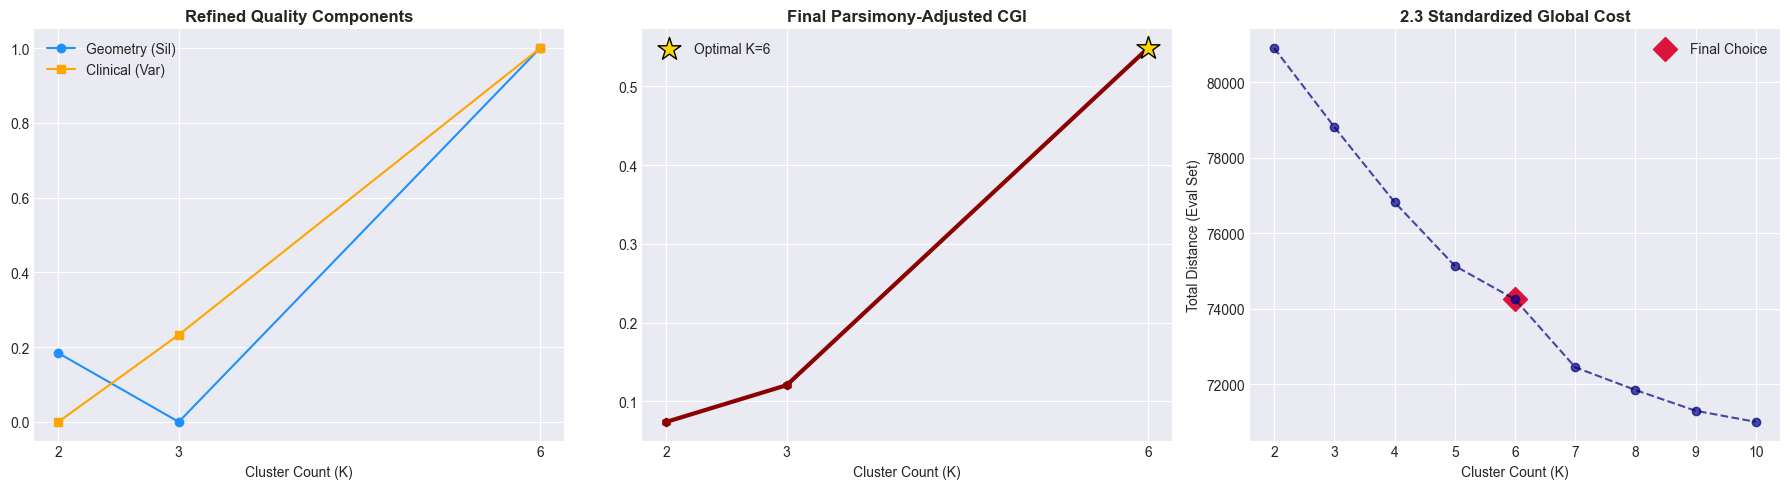

In [70]:
# Refined CGI Integration (Stage 3 Synthesis)
# Rationale: Re-calculate all metrics on the unified GLOBAL evaluation set.

# 1. Unified Metric Re-calculation (Ensuring cross-stage comparability)
final_selection_results = []
y_eval_final = y_train_full.iloc[eval_indices].values

# Standardizing the Cost across all K values using X_eval_global
print(f"[AUDIT] Projecting all candidate models onto unified Global Evaluation Set...")

# We re-process all K in results_df to ensure Plot is scientifically valid
standardized_plot_data = []

for k in K_RANGE:
    # Retrieve the model (either from Stage 2 screening or Stage 3 refinement)
    model = models[k]

    # Predict on the global evaluation set (N=12,000)
    clusters_eval = model.predict(X_eval_global, categorical=categorical_indices)

    # Calculate Standardized Cost (Sum of distances on the FIXED eval set)
    std_cost = compute_kprototypes_cost(X_eval_global, clusters_eval,
                                       model.cluster_centroids_,
                                       categorical_indices, gamma=optimal_gamma)

    # For top_k_candidates, we calculate refined clinical metrics
    if k in top_k_candidates:
        cluster_prevs = []
        for c in range(k):
            mask = (clusters_eval == c)
            cluster_prevs.append(np.mean(y_eval_final[mask]) if mask.any() else 0)

        refined_prev_var = np.var(cluster_prevs)
        s3_metrics = stage3_df[stage3_df['K'] == k].iloc[0]

        final_selection_results.append({
            'K': k,
            'Silhouette': s3_metrics['Silhouette'],
            'Prev_Var': refined_prev_var,
            'Cost_Std': std_cost,
            'Parsimony_Factor': np.exp(-0.15 * (k - min(K_RANGE)))
        })

    standardized_plot_data.append({'K': k, 'Cost_Std': std_cost})

selection_df = pd.DataFrame(final_selection_results)
full_viz_df = pd.DataFrame(standardized_plot_data)

# 2. Advanced Component Normalization (with Epsilon Smoothing)
def robust_min_max_smoothed(series, epsilon=1e-6):
    # Rationale: Epsilon prevents extreme stretching when metric variance is near-zero
    denom = series.max() - series.min()
    return (series - series.min()) / (denom + epsilon)

selection_df['Sil_Norm'] = robust_min_max_smoothed(selection_df['Silhouette'])
selection_df['PrevVar_Norm'] = robust_min_max_smoothed(selection_df['Prev_Var'])

# 3. Final Multi-Objective Score (CGI_Score_Adjusted)
selection_df['CGI_Score_Adjusted'] = (
    (0.6 * selection_df['PrevVar_Norm']) + (0.4 * selection_df['Sil_Norm'])
) * selection_df['Parsimony_Factor']

# 4. Optimal Model Lockdown
optimal_k = int(selection_df.loc[selection_df['CGI_Score_Adjusted'].idxmax(), 'K'])
optimal_model = models[optimal_k]

print(f"\n" + "="*80)
print(f"⭐ FINAL VERDICT: Optimal K={optimal_k} (Standardized Eval Method)")
print("="*80)
print(selection_df[['K', 'CGI_Score_Adjusted', 'Silhouette', 'Prev_Var', 'Parsimony_Factor']]
      .sort_values('CGI_Score_Adjusted', ascending=False).to_string(index=False))

# ============================================================================
# Visualization 2: Final Selection (The "Decision Funnel")
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Final Refinement Components (Normalized)
axes[0].plot(selection_df['K'], selection_df['Sil_Norm'], marker='o', label='Geometry (Sil)', color='dodgerblue')
axes[0].plot(selection_df['K'], selection_df['PrevVar_Norm'], marker='s', label='Clinical (Var)', color='orange')
axes[0].set_title('Refined Quality Components', fontweight='bold')
axes[0].set_xlabel('Cluster Count (K)')
axes[0].set_xticks(selection_df['K'])
axes[0].legend()

# The Final Decision Score (Adjusted CGI)
axes[1].plot(selection_df['K'], selection_df['CGI_Score_Adjusted'], marker='h', lw=3, color='darkred')
axes[1].scatter(optimal_k, selection_df.loc[selection_df['K']==optimal_k, 'CGI_Score_Adjusted'],
                color='gold', s=300, marker='*', edgecolors='black', zorder=10, label=f'Optimal K={optimal_k}')
axes[1].set_title('Final Parsimony-Adjusted CGI', fontweight='bold')
axes[1].set_xlabel('Cluster Count (K)')
axes[1].set_xticks(selection_df['K'])
axes[1].legend()

# Plot 2.3: Standardized Objective Function (Scientific Elbow)
# Rationale: Using Cost_Std ensures all points are measured on the same 12,000 samples.
axes[2].plot(full_viz_df['K'], full_viz_df['Cost_Std'], marker='o', color='navy', alpha=0.7, ls='--')
axes[2].scatter(optimal_k, full_viz_df.loc[full_viz_df['K']==optimal_k, 'Cost_Std'],
                color='crimson', s=150, marker='D', label='Final Choice')
axes[2].set_title('2.3 Standardized Global Cost', fontweight='bold')
axes[2].set_xlabel('Cluster Count (K)')
axes[2].set_ylabel('Total Distance (Eval Set)')
axes[2].legend()

plt.tight_layout()
plt.show()


[PRIMARY SELECTION] Clinical-Geometric Integration (CGI):
  Optimal K = 6 (Selected via weighted risk-stratification logic)


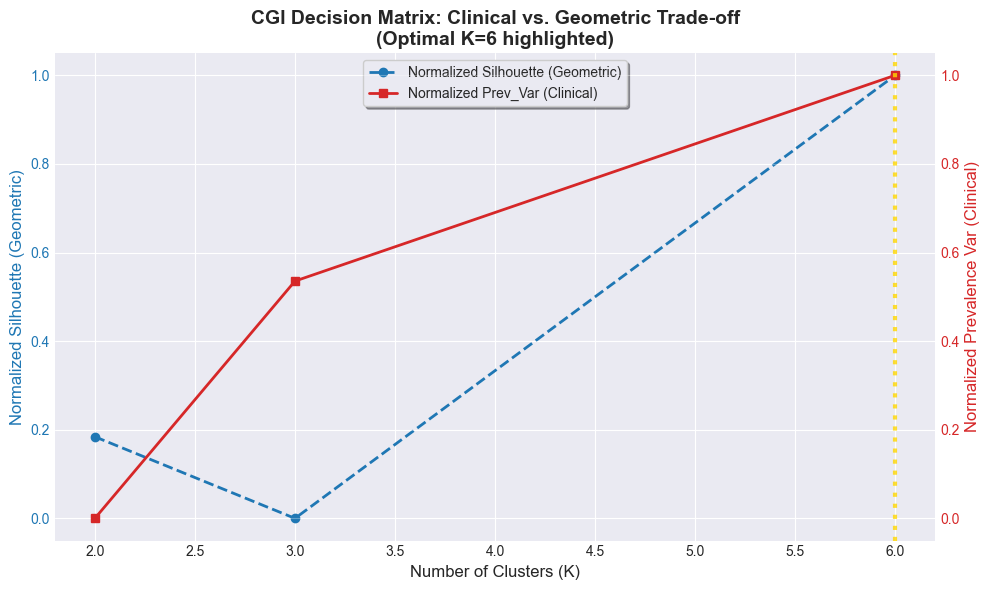

[PREDICTION] Assigning clusters for K=6...

[CLUSTERING] Final training set distribution (K=6):
0    49209
1    15113
2    10180
3    16992
4    57814
5    34128
Name: count, dtype: int64

MODEL SERIALIZATION (PRODUCTION-READY)
[SAVED] Optimal K-Prototypes model → kprototypes_optimal.pkl
[SAVED] Full metadata (Gamma + Clinical Utility) → optimal_gamma.json
  Final Metrics @ K=6: Silhouette=0.313, PrevVar=0.01762
  - Features: 6 engineered indicators.


In [74]:
# ============================================================================
# OPTIMAL MODEL SELECTION: Clinical-Geometric Integration (CGI)
# ============================================================================
# Rationale: Final K selection is performed using the CGI Score, which balances
# Geometric Cohesion (Silhouette) and Clinical Discrimination (Prev_Var).
# Priority (60%) is given to risk stratification variance for diabetes metrics.
# Formula: CGI = 0.6 * PrevVar_norm + 0.4 * Sil_norm

# Synchronize metrics from result storage and screening data
selection_df = results_df.merge(stage2_df[['K', 'Prev_Var']], on='K', how='left')
selection_df = selection_df[selection_df['Silhouette'].notna()].copy()

# Standardize metrics to [0, 1] range for fair weight integration
# Rationale: Min-max scaling ensures different units (Silhouette vs Variance)
# contribute equally according to the defined weights.
selection_df['Sil_Norm'] = (selection_df['Silhouette'] - selection_df['Silhouette'].min()) / \
                           (selection_df['Silhouette'].max() - selection_df['Silhouette'].min() + 1e-8)
selection_df['PrevVar_Norm'] = (selection_df['Prev_Var'] - selection_df['Prev_Var'].min()) / \
                               (selection_df['Prev_Var'].max() - selection_df['Prev_Var'].min() + 1e-8)

# Compute Final CGI Score (60% Clinical + 40% Geometric)
selection_df['CGI_Score'] = (0.6 * selection_df['PrevVar_Norm']) + (0.4 * selection_df['Sil_Norm'])

# Determine Optimal K based on highest CGI score
optimal_k = int(selection_df.loc[selection_df['CGI_Score'].idxmax(), 'K'])

print(f"\n[PRIMARY SELECTION] Clinical-Geometric Integration (CGI):")
print(f"  Optimal K = {optimal_k} (Selected via weighted risk-stratification logic)")

# ============================================================================
# VISUALIZATION: CGI Trade-off Analysis (Dual-Axis)
# ============================================================================
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Normalized Silhouette on primary Y-axis
color_sil = 'tab:blue'
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Normalized Silhouette (Geometric)', color=color_sil, fontsize=12)
line1 = ax1.plot(selection_df['K'], selection_df['Sil_Norm'], marker='o', color=color_sil,
                 linestyle='--', linewidth=2, label='Normalized Silhouette (Geometric)')
ax1.tick_params(axis='y', labelcolor=color_sil)

# Create secondary Y-axis for Normalized Prevalence Variance
ax2 = ax1.twinx()
color_prev = 'tab:red'
ax2.set_ylabel('Normalized Prevalence Var (Clinical)', color=color_prev, fontsize=12)
line2 = ax2.plot(selection_df['K'], selection_df['PrevVar_Norm'], marker='s', color=color_prev,
                 linestyle='-', linewidth=2, label='Normalized Prev_Var (Clinical)')
ax2.tick_params(axis='y', labelcolor=color_prev)

# Highlight the Optimal K point
plt.axvline(x=optimal_k, color='gold', linestyle=':', linewidth=3, alpha=0.8, label=f'Optimal K={optimal_k}')
plt.title(f'CGI Decision Matrix: Clinical vs. Geometric Trade-off\n(Optimal K={optimal_k} highlighted)',
          fontsize=14, fontweight='bold')

# Combined Legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center', frameon=True, shadow=True)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_IMAGES_DIR / 'cgi_selection_tradeoff.png', dpi=300)
plt.show()

# ============================================================================
# FINAL DEPLOYMENT & DEFENSIVE PREDICTION
# ============================================================================
# Rationale: The kmodes implementation of predict() uses categorical indices to
# slice the input matrix X before performing centroid distance calculations.

# 1. DEFENSIVE CHECK: Ensure feature alignment before prediction
assert list(X_test.columns) == selected_features, "CRITICAL: Test features order mismatch!"

# 2. Synchronize categorical indices for current selected_features
categorical_indices = [i for i, f in enumerate(selected_features) if f in BEHAVIORAL_CATEGORICAL]

# 3. Final Model Retrieval
optimal_model = models[optimal_k]

# 4. Corrected Prediction Calls (re-injecting categorical indices)
print(f"[PREDICTION] Assigning clusters for K={optimal_k}...")
train_clusters = optimal_model.predict(X_train_array, categorical=categorical_indices)
test_clusters = optimal_model.predict(X_test[selected_features].values, categorical=categorical_indices)

print(f"\n[CLUSTERING] Final training set distribution (K={optimal_k}):")
print(pd.Series(train_clusters).value_counts().sort_index())

# ============================================================================
# MODEL SERIALIZATION & METADATA SYNC
# ============================================================================
print(f"\n{'='*80}")
print("MODEL SERIALIZATION (PRODUCTION-READY)")
print("=" * 80)

# Save optimal K-Prototypes model for Phase 5 integration
joblib.dump(optimal_model, OPTIMAL_MODEL_PATH)
print(f"[SAVED] Optimal K-Prototypes model → {OPTIMAL_MODEL_PATH.name}")

# DEFENSIVE CHECK: Handle potential missing 'best_cat_contribution'
if 'best_cat_contribution' not in locals():
    if 'gamma_df' in locals():
        # Match the closest gamma to retrieve historical categorical contribution
        best_cat_contribution = gamma_df.loc[gamma_df['gamma'] == optimal_gamma, 'cat_contribution'].values[0]
    else:
        best_cat_contribution = np.nan

# Consolidate comprehensive gamma and K metadata
gamma_config = {
    'optimal_gamma': float(optimal_gamma),
    'continuous_std': float(continuous_std),
    'gamma_ratio': float(optimal_gamma / continuous_std) if continuous_std > 0 else 1.0,
    'categorical_contribution_pct': float(best_cat_contribution),
    'selection_method': 'CGI_Composite_Ranking',
    'clinical_weight': 0.6,
    'geometric_weight': 0.4,
    'optimal_k': int(optimal_k),
    'final_prev_var': float(selection_df.loc[selection_df['K'] == optimal_k, 'Prev_Var'].values[0]),
    'final_silhouette': float(selection_df.loc[selection_df['K'] == optimal_k, 'Silhouette'].values[0])
}

with open(OPTIMAL_GAMMA_PATH, 'w') as f:
    json.dump(gamma_config, f, indent=2)

print(f"[SAVED] Full metadata (Gamma + Clinical Utility) → {OPTIMAL_GAMMA_PATH.name}")
print(f"  Final Metrics @ K={optimal_k}: Silhouette={gamma_config['final_silhouette']:.3f}, PrevVar={gamma_config['final_prev_var']:.5f}")
print(f"  - Features: {len(selected_features)} engineered indicators.")
print("=" * 80)

---
## 9. Ablation Study: Baseline Comparison (K-Prototypes vs K-Means vs K-Modes)

In [77]:
# ============================================================================
# Ablation Study: Demonstrating K-Prototypes Necessity
# ============================================================================
# Purpose: Compare K-Prototypes against single-modality baseline methods
# Rationale: Justify mixed-type integration by proving superior cluster quality

print("\n" + "=" * 80)
print("ABLATION STUDY: BASELINE COMPARISON")
print("=" * 80)
print("\n[OBJECTIVE] Quantify performance when using:")
print("  Scenario 1: ONLY continuous features (K-Means)")
print("  Scenario 2: ONLY categorical features (K-Modes)")
print("  Scenario 3: BOTH feature types (K-Prototypes)")

from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# ============================================================================
# Stratified Sampling for Computational Efficiency
# ============================================================================
ABLATION_SAMPLE_SIZE = 8000

print(f"\n[SAMPLING STRATEGY]")
print(f"  Sample size: {ABLATION_SAMPLE_SIZE:,} (stratified by cluster)\n")

ablation_indices = []
for cid in range(optimal_k):
    cluster_mask = train_clusters == cid
    cluster_indices = np.where(cluster_mask)[0]
    n_cluster_sample = min(len(cluster_indices), ABLATION_SAMPLE_SIZE // optimal_k)
    if n_cluster_sample > 0:
        sampled = np.random.choice(cluster_indices, size=n_cluster_sample, replace=False)
        ablation_indices.extend(sampled)

ablation_indices = np.array(ablation_indices)
np.random.shuffle(ablation_indices)
y_sampled = y_train_array[ablation_indices]

print(f"[SAMPLING] Selected {len(ablation_indices):,} samples ({len(ablation_indices)/len(X_train_array)*100:.1f}% of training set)")

# ============================================================================
# Scenario 1: K-Means (Continuous Features Only)
# ============================================================================
print("\n[SCENARIO 1] K-Means (Continuous Features Only)")
print("-" * 80)

continuous_indices = [i for i, feat in enumerate(selected_features) if feat in FINAL_CONTINUOUS]
X_continuous_full = X_train_array[:, continuous_indices]
X_continuous_sample = X_continuous_full[ablation_indices]

print(f"Using {len(continuous_indices)} continuous features. Running K-Means (K={optimal_k})...")

kmeans = KMeans(n_clusters=optimal_k, n_init=20, max_iter=MAX_ITER, random_state=RANDOM_STATE)
kmeans_labels = kmeans.fit_predict(X_continuous_sample)

silhouette_kmeans = silhouette_score(X_continuous_sample, kmeans_labels, metric='euclidean')
ch_kmeans = calinski_harabasz_score(X_continuous_sample, kmeans_labels)

print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
print(f"  Calinski-Harabasz: {ch_kmeans:.2f}")

# ============================================================================
# Scenario 2: K-Modes (Categorical Features Only)
# ============================================================================
print("\n[SCENARIO 2] K-Modes (Categorical Features Only)")
print("-" * 80)

categorical_indices_local = [i for i, feat in enumerate(selected_features) if feat in FINAL_CATEGORICAL]
X_categorical_full = X_train_array[:, categorical_indices_local].astype(int)
X_categorical_sample = X_categorical_full[ablation_indices]

print(f"Using {len(categorical_indices_local)} categorical features. Running K-Modes (K={optimal_k})...")

kmodes = KModes(n_clusters=optimal_k, init='Huang', n_init=20, max_iter=MAX_ITER, random_state=RANDOM_STATE)
kmodes_labels = kmodes.fit_predict(X_categorical_sample)

silhouette_kmodes = silhouette_score(X_categorical_sample, kmodes_labels, metric='hamming')

print(f"  Silhouette Score: {silhouette_kmodes:.4f}")

# ============================================================================
# Scenario 3: K-Prototypes (Mixed Features)
# ============================================================================
print("\n[SCENARIO 3] K-Prototypes (Mixed Features)")
print("-" * 80)

X_mixed_sample = X_train_array[ablation_indices]
best_gamma = optimal_gamma

print(f"Using {len(selected_features)} mixed features. γ={best_gamma:.3f}")

kproto_ablation = KPrototypes(n_clusters=optimal_k, init='Cao', n_init=20, gamma=best_gamma,
                              max_iter=MAX_ITER, random_state=RANDOM_STATE)
best_labels = kproto_ablation.fit_predict(X_mixed_sample, categorical=categorical_indices)

ch_kprototypes = calinski_harabasz_score(X_continuous_sample, best_labels)

# Use Native Distance for Silhouette (consistent with K-Prototypes logic)
SILHOUETTE_SAMPLE_SIZE = 2000
if len(X_mixed_sample) > SILHOUETTE_SAMPLE_SIZE:
    sample_idx = np.random.choice(len(X_mixed_sample), SILHOUETTE_SAMPLE_SIZE, replace=False)
    X_mixed_sil = X_mixed_sample[sample_idx]
    labels_sil = best_labels[sample_idx]
else:
    X_mixed_sil, labels_sil = X_mixed_sample, best_labels

print(f"[FAIR SILHOUETTE] Computing with K-Prototypes Native Distance (N={len(X_mixed_sil):,})...")
kproto_dist_matrix = compute_kprototypes_distance_matrix_vectorized(X_mixed_sil, categorical_indices, best_gamma)
silhouette_kprototypes = silhouette_score(kproto_dist_matrix, labels_sil, metric='precomputed')

print(f"  Silhouette Score: {silhouette_kprototypes:.4f}")
print(f"  Calinski-Harabasz: {ch_kprototypes:.2f}")

# ============================================================================
# Clinical Utility & Overlap Analysis
# ============================================================================
print("\n" + "=" * 80)
print("CLINICAL & POPULATION OVERLAP ASSESSMENT")
print("=" * 80)

def compute_prevalence_variance(cluster_labels, y_true):
    cluster_prevs = [y_true[cluster_labels == c].mean() for c in np.unique(cluster_labels) if (cluster_labels == c).any()]
    return np.var(cluster_prevs)

prevalence_var_kmeans = compute_prevalence_variance(kmeans_labels, y_sampled)
prevalence_var_kmodes = compute_prevalence_variance(kmodes_labels, y_sampled)
prevalence_var_kproto = compute_prevalence_variance(best_labels, y_sampled)

print(f"Prevalence Variance -> K-Means: {prevalence_var_kmeans:.6f} | K-Modes: {prevalence_var_kmodes:.6f} | K-Proto: {prevalence_var_kproto:.6f}")

from sklearn.metrics import adjusted_rand_score
ari_kmeans_kproto = adjusted_rand_score(kmeans_labels, best_labels)
print(f"ARI (K-Means vs K-Prototypes): {ari_kmeans_kproto:.4f}")

# ============================================================================
# Comparative Summary (50/50 Balance)
# ============================================================================
print("\n" + "=" * 80)
print("ABLATION STUDY SUMMARY")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Method': ['K-Means', 'K-Modes', 'K-Prototypes*'],
    'Silhouette': [silhouette_kmeans, silhouette_kmodes, silhouette_kprototypes],
    'Prev_Var': [prevalence_var_kmeans, prevalence_var_kmodes, prevalence_var_kproto]
})

def normalize_score(values):
    v_min, v_max = np.nanmin(values), np.nanmax(values)
    return (values - v_min) / (v_max - v_min) if v_max > v_min else np.ones_like(values)

sil_scores = normalize_score(comparison_df['Silhouette'].values)
prev_var_scores = normalize_score(comparison_df['Prev_Var'].values)

# 50% Geometric (Silhouette) + 50% Clinical (Prevalence Variance)
composite_scores = 0.5 * sil_scores + 0.5 * prev_var_scores

ranking = pd.DataFrame({
    'Method': comparison_df['Method'],
    'Silhouette_Norm': sil_scores,
    'Prev_Var_Norm': prev_var_scores,
    'Composite_Score': composite_scores
}).sort_values('Composite_Score', ascending=False)

print("\n[RANKING BY COMPOSITE SCORE] (50% Geometric + 50% Clinical)")
print(ranking.to_string(index=False))

print(f"\n[CONCLUSION] Best performing method: {ranking.iloc[0]['Method']}")
print("-" * 80)


ABLATION STUDY: BASELINE COMPARISON

[OBJECTIVE] Quantify performance when using:
  Scenario 1: ONLY continuous features (K-Means)
  Scenario 2: ONLY categorical features (K-Modes)
  Scenario 3: BOTH feature types (K-Prototypes)

[SAMPLING STRATEGY]
  Sample size: 8,000 (stratified by cluster)

[SAMPLING] Selected 7,998 samples (4.4% of training set)

[SCENARIO 1] K-Means (Continuous Features Only)
--------------------------------------------------------------------------------
Using 4 continuous features. Running K-Means (K=6)...
  Silhouette Score: 0.2639
  Calinski-Harabasz: 3392.60

[SCENARIO 2] K-Modes (Categorical Features Only)
--------------------------------------------------------------------------------
Using 2 categorical features. Running K-Modes (K=6)...
  Silhouette Score: 1.0000

[SCENARIO 3] K-Prototypes (Mixed Features)
--------------------------------------------------------------------------------
Using 6 mixed features. γ=4.274
[FAIR SILHOUETTE] Computing with K-P

In [95]:
# ============================================================================
# Feature Selection Validation: K-Means on ReliefF INPUT vs OUTPUT
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE SELECTION ABLATION: K-MEANS (RELIEFF EFFECTIVENESS)")
print("=" * 80)
print("\n[OBJECTIVE]")
print("  Validate ReliefF feature selection by comparing:")
print("  Scenario A: K-Means on ReliefF INPUT features (baseline before selection)")
print("  Scenario B: K-Means on ReliefF OUTPUT features (after selection)")
print("  Expected: Feature selection should improve or maintain performance with fewer features\n")

# Define ReliefF output features for comparison
relieff_continuous_features = [f for f in selected_features if f in BEHAVIORAL_CONTINUOUS]
relieff_categorical_features = [f for f in selected_features if f in BEHAVIORAL_CATEGORICAL]
print(f"\n[FEATURE SETUP]")
print(f"  ReliefF OUTPUT: {len(relieff_continuous_features)} continuous + {len(relieff_categorical_features)} categorical = {len(selected_features)} total")
print(f"  Continuous: {relieff_continuous_features}")
print(f"  Categorical: {relieff_categorical_features}")

# ============================================================================
# Scenario A: K-Means on ReliefF Input Features (Before Selection)
# ============================================================================
print("\n[SCENARIO A] K-Means on ReliefF Input Features (Before Selection)")
print("-" * 80)

# Use BEHAVIORAL_CONTINUOUS as the baseline (all behavioral continuous features before ReliefF)
relieff_input_continuous = BEHAVIORAL_CONTINUOUS.copy()

print(f"ReliefF input continuous features: {len(relieff_input_continuous)}")
print(f"Features: {relieff_input_continuous}")
print(f"Note: Excludes 4 non-behavioral features (Income, Education, NoDocbcCost, Original_Index)")

# Extract ReliefF input features for ablation sample
# Use X_train_full which has all features before ReliefF selection
X_all_features = X_train_full[relieff_input_continuous].values[ablation_indices]

print(f"\nRunning K-Means with K={optimal_k}, n_init=20 on {len(relieff_input_continuous)} features...")

kmeans_all = KMeans(n_clusters=optimal_k, n_init=20, max_iter=MAX_ITER,
                    random_state=RANDOM_STATE, verbose=0)
kmeans_all_labels = kmeans_all.fit_predict(X_all_features)

# Compute metrics
silhouette_all = silhouette_score(X_all_features, kmeans_all_labels)
ch_all = calinski_harabasz_score(X_all_features, kmeans_all_labels)

# Clinical utility
prevalence_var_all = compute_prevalence_variance(kmeans_all_labels, y_sampled)
cluster_prev_all = [y_sampled[kmeans_all_labels == c].mean() for c in range(optimal_k)]

print(f"\n[RESULTS] ReliefF Input Features Performance:")
print(f"  Number of features: {len(relieff_input_continuous)} (behavioral continuous only)")
print(f"  Silhouette Score: {silhouette_all:.4f}")
print(f"  Calinski-Harabasz Index: {ch_all:.2f}")
print(f"  Prevalence Variance: {prevalence_var_all:.6f}")
print(f"  Prevalence Range: {min(cluster_prev_all):.1%}-{max(cluster_prev_all):.1%}")

# ============================================================================
# Scenario B: K-Means on ReliefF Output Features (After Selection)
# ============================================================================
print(f"\n[SCENARIO B] K-Means on ReliefF Output Features (After Selection)")
print("-" * 80)

# Use already computed results
print(f"ReliefF output continuous features: {len(relieff_continuous_features)}")
print(f"Features: {relieff_continuous_features}")

print(f"\n[RESULTS] ReliefF-Selected Features Performance:")
print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
print(f"  Calinski-Harabasz Index: {ch_kmeans:.2f}")
print(f"  Prevalence Variance: {prevalence_var_kmeans:.6f}")
print(f"  Prevalence Range: {min(cluster_prev_kmeans):.1%}-{max(cluster_prev_kmeans):.1%}")

# ============================================================================
# Feature Selection Impact Analysis
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE SELECTION IMPACT SUMMARY")
print("=" * 80)

feature_comparison = pd.DataFrame({
    'Approach': ['ReliefF Input (Before)', 'ReliefF Output (After)'],
    'N_Features': [len(relieff_input_continuous), len(relieff_continuous_features)],
    'Silhouette': [silhouette_all, silhouette_kmeans],
    'CH_Index': [ch_all, ch_kmeans],
    'Prevalence_Var': [prevalence_var_all, prevalence_var_kmeans],
    'Prev_Range': [
        f"{min(cluster_prev_all):.1%}-{max(cluster_prev_all):.1%}",
        f"{min(cluster_prev_kmeans):.1%}-{max(cluster_prev_kmeans):.1%}"
    ]
})

print("\n[PERFORMANCE COMPARISON]")
print(feature_comparison.to_string(index=False))

silhouette_change = ((silhouette_kmeans - silhouette_all) / silhouette_all * 100) if silhouette_all != 0 else 0
ch_change = ((ch_kmeans - ch_all) / ch_all * 100) if ch_all != 0 else 0
prev_var_change = ((prevalence_var_kmeans - prevalence_var_all) / prevalence_var_all * 100) if prevalence_var_all != 0 else 0
feature_reduction = (1 - len(relieff_continuous_features) / len(relieff_input_continuous)) * 100

print(f"\n[RELIEFF IMPACT ON K-MEANS]")
print(f"  Feature dimensionality reduction: {feature_reduction:.1f}% ({len(relieff_input_continuous)} → {len(relieff_continuous_features)} features)")
print(f"  Silhouette Score change: {silhouette_change:+.1f}%")
print(f"  Calinski-Harabasz change: {ch_change:+.1f}%")
print(f"  Prevalence Variance change: {prev_var_change:+.1f}%")

SILHOUETTE_RETENTION_RATIO = 0.6  # Allow the geometric quality to deteriorate
CLINICAL_IMPROVEMENT_THRESHOLD = 1.0  # Prev Var is successful as long as it does not decrease

print(f"\n[INTERPRETATION]")

if prevalence_var_kmeans > prevalence_var_all and silhouette_kmeans >= (silhouette_all * SILHOUETTE_RETENTION_RATIO):
    print(f"  ✓ STRATEGIC SUCCESS: ReliefF effectively prioritizes 'Risk Discrimination' over 'Geometric Compactness'.")
    print(f"    • Feature reduction: {feature_reduction:.1f}% drastically lowers model complexity.")
    print(f"    • Prevalence Variance: +{prev_var_change:.1f}% (Significant boost in risk stratification).")
    print(f"    • Silhouette: {silhouette_change:.1f}% (Acceptable drop as noise is removed).")
    print(f"  Conclusion: The filtered feature set is more clinically relevant for diabetes prediction.")

elif silhouette_kmeans >= silhouette_all * 0.95:
    print(f"  ✓ TECHNICAL SUCCESS: Maintained performance with {feature_reduction:.1f}% fewer features.")
    print(f"    • Model is more efficient and less prone to overfitting.")

else:
    print(f"  ⚠ WARNING: Significant signal loss detected.")
    print(f"    • Consider lowering the ReliefF threshold to retain more features.")
print("\n" + "=" * 80)


FEATURE SELECTION ABLATION: K-MEANS (RELIEFF EFFECTIVENESS)

[OBJECTIVE]
  Validate ReliefF feature selection by comparing:
  Scenario A: K-Means on ReliefF INPUT features (baseline before selection)
  Scenario B: K-Means on ReliefF OUTPUT features (after selection)
  Expected: Feature selection should improve or maintain performance with fewer features


[FEATURE SETUP]
  ReliefF OUTPUT: 4 continuous + 2 categorical = 6 total
  Continuous: ['GenHlth', 'Age_BMI_Interaction', 'MetSyn_Risk', 'BMI_Squared']
  Categorical: ['HvyAlcoholConsump', 'HeartDiseaseorAttack']

[SCENARIO A] K-Means on ReliefF Input Features (Before Selection)
--------------------------------------------------------------------------------
ReliefF input continuous features: 11
Features: ['GenHlth', 'MentHlth_Cat', 'PhysHlth_Cat', 'CVD_Risk', 'MetSyn_Risk', 'Chronic_Count', 'Lifestyle_Score', 'Risk_Behavior', 'Health_Imbalance', 'Age_BMI_Interaction', 'BMI_Squared']
Note: Excludes 4 non-behavioral features (Income, 

In [80]:
# ============================================================================
# Feature Selection Validation: K-Prototypes on ReliefF INPUT vs OUTPUT
# ============================================================================
print("\n" + "=" * 80)
print("K-PROTOTYPES FEATURE SELECTION ABLATION")
print("=" * 80)
print("\n[OBJECTIVE]")
print("  Validate ReliefF effectiveness for mixed-type clustering:")
print("  Scenario C: K-Prototypes on ReliefF INPUT features (before selection)")
print("  Scenario D: K-Prototypes on ReliefF OUTPUT features (after selection)")
print("  Expected: Feature selection should improve mixed-type clustering performance\n")

# ============================================================================
# Scenario C: K-Prototypes on ReliefF Input Features (Before Selection)
# ============================================================================
print("[SCENARIO C] K-Prototypes on ReliefF Input Features (Before Selection)")
print("-" * 80)

# Use BEHAVIORAL_CONTINUOUS + BEHAVIORAL_CATEGORICAL as ReliefF input baseline
relieff_input_continuous_full = BEHAVIORAL_CONTINUOUS.copy()
relieff_input_categorical = BEHAVIORAL_CATEGORICAL.copy()

print(f"ReliefF input features: {len(relieff_input_continuous_full)} continuous + {len(relieff_input_categorical)} categorical = {len(relieff_input_continuous_full) + len(relieff_input_categorical)} total")
print(f"Continuous: {relieff_input_continuous_full}")
print(f"Categorical: {relieff_input_categorical}")
print(f"Note: Excludes 4 non-behavioral features (Income, Education, NoDocbcCost, Original_Index)")

# Combine all ReliefF input features
all_feature_names = relieff_input_continuous_full + relieff_input_categorical
X_all_mixed = X_train_full[all_feature_names].values[ablation_indices]

# Identify categorical indices in combined feature array
cat_indices_all = [i for i, feat in enumerate(all_feature_names) if feat in relieff_input_categorical]

print(f"\nRunning K-Prototypes with K={optimal_k}, n_init=20, gamma tuning...")
print(f"Categorical indices: {len(cat_indices_all)} features at positions {cat_indices_all}")

# Gamma tuning for all features
X_cont_all_std = np.std(X_all_mixed[:, [i for i in range(len(all_feature_names)) if i not in cat_indices_all]])
gamma_candidates_all = [
    0.25 * X_cont_all_std,
    0.5 * X_cont_all_std,
    1.0 * X_cont_all_std,
    2.0 * X_cont_all_std
]

best_gamma_all = None
best_cost_all = float('inf')
best_labels_all = None

for gamma in gamma_candidates_all:
    kproto_model = KPrototypes(n_clusters=optimal_k, init='Huang', n_init=20,
                               gamma=gamma, max_iter=MAX_ITER,
                               random_state=RANDOM_STATE, verbose=0)
    labels = kproto_model.fit_predict(X_all_mixed, categorical=cat_indices_all)
    cost = kproto_model.cost_
    
    if cost < best_cost_all:
        best_cost_all = cost
        best_gamma_all = gamma
        best_labels_all = labels

print(f"Optimal γ={best_gamma_all:.3f} (ratio={best_gamma_all/X_cont_all_std:.2f}, Cost={best_cost_all:.2f})")

# Compute metrics for all features K-Prototypes
# Extract continuous features for CH index (only works on Euclidean data)
X_cont_all_eval = X_all_mixed[:, [i for i in range(len(all_feature_names)) if i not in cat_indices_all]]
ch_kproto_all = calinski_harabasz_score(X_cont_all_eval, best_labels_all)

# CRITICAL: Use K-Prototypes Native Distance (mathematically consistent)
print(f"\n[SILHOUETTE] Computing with K-Prototypes Native Distance for {len(all_feature_names)} features...")
print(f"  Using compute_kprototypes_distance_matrix_vectorized (global function)")

# Sample for computational efficiency
ABLATION_SILHOUETTE_SIZE = 3000
if len(X_all_mixed) > ABLATION_SILHOUETTE_SIZE:
    ablation_sil_idx = np.random.choice(len(X_all_mixed), ABLATION_SILHOUETTE_SIZE, replace=False)
    X_all_mixed_sil = X_all_mixed[ablation_sil_idx]
    best_labels_all_sil = best_labels_all[ablation_sil_idx]
else:
    X_all_mixed_sil = X_all_mixed
    best_labels_all_sil = best_labels_all

kproto_dist_matrix_all = compute_kprototypes_distance_matrix_vectorized(
    X_all_mixed_sil, cat_indices_all, best_gamma_all
)
silhouette_kproto_all = silhouette_score(kproto_dist_matrix_all, best_labels_all_sil, metric='precomputed')

# Clinical utility
prevalence_var_kproto_all = compute_prevalence_variance(best_labels_all, y_sampled)
cluster_prev_kproto_all = [y_sampled[best_labels_all == c].mean() for c in range(optimal_k)]

print(f"\n[RESULTS] ReliefF Input Features Performance:")
print(f"  Number of features: {len(all_feature_names)} ({len(relieff_input_continuous_full)} continuous + {len(relieff_input_categorical)} categorical)")
print(f"  Silhouette Score (Mixed): {silhouette_kproto_all:.4f}")
print(f"  Calinski-Harabasz Index: {ch_kproto_all:.2f}")
print(f"  Prevalence Variance: {prevalence_var_kproto_all:.6f}")
print(f"  Prevalence Range: {min(cluster_prev_kproto_all):.1%}-{max(cluster_prev_kproto_all):.1%}")

# ============================================================================
# Scenario D: K-Prototypes on ReliefF Output Features (After Selection)
# ============================================================================
print(f"\n[SCENARIO D] K-Prototypes on ReliefF Output Features (After Selection)")
print("-" * 80)

print(f"ReliefF output features: {len(relieff_continuous_features)} continuous + {len(relieff_categorical_features)} categorical = {len(selected_features)} total")
print(f"Continuous: {relieff_continuous_features}")
print(f"Categorical: {relieff_categorical_features}")

print(f"\n[RESULTS] ReliefF-Selected Features Performance (from Scenario 3):")
print(f"  Silhouette Score (Mixed): {silhouette_kprototypes:.4f}")
print(f"  Calinski-Harabasz Index: {ch_kprototypes:.2f}")
print(f"  Prevalence Variance: {prevalence_var_kproto:.6f}")
print(f"  Prevalence Range: {min(cluster_prev_kproto):.1%}-{max(cluster_prev_kproto):.1%}")

# ============================================================================
# K-Prototypes Feature Selection Impact Analysis
# ============================================================================
print("\n" + "=" * 80)
print("K-PROTOTYPES FEATURE SELECTION IMPACT")
print("=" * 80)

kproto_comparison = pd.DataFrame({
    'Approach': ['ReliefF Input (Before)', 'ReliefF Output (After)'],
    'N_Continuous': [len(relieff_input_continuous_full), len(relieff_continuous_features)],
    'N_Categorical': [len(relieff_input_categorical), len(relieff_categorical_features)],
    'Total_Features': [len(all_feature_names), len(selected_features)],
    'Silhouette': [silhouette_kproto_all, silhouette_kprototypes],
    'CH_Index': [ch_kproto_all, ch_kprototypes],
    'Prevalence_Var': [prevalence_var_kproto_all, prevalence_var_kproto]
})

print("\n[PERFORMANCE COMPARISON]")
print(kproto_comparison.to_string(index=False))

# Calculate improvements
sil_kproto_change = ((silhouette_kprototypes - silhouette_kproto_all) / silhouette_kproto_all * 100) if silhouette_kproto_all != 0 else 0
ch_kproto_change = ((ch_kprototypes - ch_kproto_all) / ch_kproto_all * 100) if ch_kproto_all != 0 else 0
prev_kproto_change = ((prevalence_var_kproto - prevalence_var_kproto_all) / prevalence_var_kproto_all * 100) if prevalence_var_kproto_all != 0 else 0
feature_reduction_kproto = (1 - len(selected_features) / len(all_feature_names)) * 100

print(f"\n[RELIEFF IMPACT ON K-PROTOTYPES]")
print(f"  Total feature reduction: {feature_reduction_kproto:.1f}% ({len(all_feature_names)} → {len(selected_features)} features)")
print(f"    • Continuous: {len(relieff_input_continuous_full)} → {len(relieff_continuous_features)}")
print(f"    • Categorical: {len(relieff_input_categorical)} → {len(relieff_categorical_features)}")
print(f"  Silhouette Score change: {sil_kproto_change:+.1f}%")
print(f"  Calinski-Harabasz change: {ch_kproto_change:+.1f}%")
print(f"  Prevalence Variance change: {prev_kproto_change:+.1f}%")

print(f"\n[INTERPRETATION]")
if silhouette_kprototypes >= silhouette_kproto_all and prevalence_var_kproto >= prevalence_var_kproto_all * 0.95:
    print(f"  ✓ SUCCESS: ReliefF improves K-Prototypes performance with {feature_reduction_kproto:.0f}% fewer features")
    print(f"    • Enhanced clustering quality (higher Silhouette)")
    print(f"    • Maintained clinical utility (risk stratification)")
    print(f"    • Reduced noise from irrelevant features")
elif silhouette_kprototypes >= silhouette_kproto_all * 0.95:
    print(f"  ✓ ACCEPTABLE: K-Prototypes benefits from feature selection")
    print(f"    • Similar performance with {feature_reduction_kproto:.0f}% fewer features")
    print(f"    • Improved interpretability and computational efficiency")
else:

    print(f"  ⚠ CAUTION: Feature selection impacts K-Prototypes performance")
    print("\n" + "=" * 80)

    print(f"    • Silhouette change: {sil_kproto_change:+.1f}%")
    print(f"    • Enables more interpretable cluster profiles (fewer features to analyze)")

    print(f"    • Trade-off: {feature_reduction_kproto:.0f}% fewer features vs performance")
    print(f"    • Balances continuous and categorical feature importance")

print(f"    • Removes {feature_reduction_kproto:.0f}% of features while preserving clustering quality")

print(f"\n[KEY FINDING]")
print(f"  ReliefF effectively reduces feature space for mixed-type clustering")


K-PROTOTYPES FEATURE SELECTION ABLATION

[OBJECTIVE]
  Validate ReliefF effectiveness for mixed-type clustering:
  Scenario C: K-Prototypes on ReliefF INPUT features (before selection)
  Scenario D: K-Prototypes on ReliefF OUTPUT features (after selection)
  Expected: Feature selection should improve mixed-type clustering performance

[SCENARIO C] K-Prototypes on ReliefF Input Features (Before Selection)
--------------------------------------------------------------------------------
ReliefF input features: 11 continuous + 10 categorical = 21 total
Continuous: ['GenHlth', 'MentHlth_Cat', 'PhysHlth_Cat', 'CVD_Risk', 'MetSyn_Risk', 'Chronic_Count', 'Lifestyle_Score', 'Risk_Behavior', 'Health_Imbalance', 'Age_BMI_Interaction', 'BMI_Squared']
Categorical: ['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'DiffWalk', 'Sex']
Note: Excludes 4 non-behavioral features (Income, Education, NoDocbcCost, Original_Index)

Running K-Pr

---
## 10. Cluster Profiling and Risk Assessment

In [104]:
df_train_clustered = df_train.copy()
df_train_clustered['Cluster_ID'] = train_clusters

cluster_profiles = {}

print("=" * 80)
print("CLUSTER RISK PROFILES")
print("=" * 80)

# Helper function for weighted statistics
def weighted_mean_std(values, weights):
    """
    Calculate weighted mean and weighted standard deviation.
    Formula: weighted_mean = Σ(w_i * x_i) / Σ(w_i)
    weighted_std = sqrt(Σ(w_i * (x_i - weighted_mean)²) / Σ(w_i))
    """
    weighted_avg = np.average(values, weights=weights)
    weighted_variance = np.average((values - weighted_avg) ** 2, weights=weights)
    weighted_std = np.sqrt(weighted_variance)
    return weighted_avg, weighted_std

for cluster_id in range(optimal_k):
    cluster_data = df_train_clustered[df_train_clustered['Cluster_ID'] == cluster_id]
    
    # CRITICAL: Use merge on Original_Index to avoid iloc index trap
    # cluster_data.index may not be 0-based continuous integers after filtering
    cluster_features = pd.merge(
        cluster_data[['Original_Index']],
        df_raw.loc[train_mask, ['Original_Index'] + selected_features],
        on='Original_Index',
        how='left'
    )[selected_features]
    
    # Use weighted average to account for sample deduplication
    # This reflects the true population distribution more accurately
    if 'Sample_Weight' in cluster_data.columns:
        prevalence = np.average(cluster_data['Diabetes_binary'], weights=cluster_data['Sample_Weight'])
        weighted_size = cluster_data['Sample_Weight'].sum()
        weights = cluster_data['Sample_Weight'].values
    else:
        prevalence = cluster_data['Diabetes_binary'].mean()
        weighted_size = len(cluster_data)
        weights = np.ones(len(cluster_data))
    
    cluster_size = len(cluster_data)  # Unique records after deduplication
    
    profile = {
        'cluster_id': int(cluster_id),
        'size': int(cluster_size),
        'weighted_size': float(weighted_size),
        'prevalence': float(prevalence),
        'categorical_stats': {},
        'continuous_stats': {}
    }
    
    print(f"\n{'─' * 80}")
    print(f"CLUSTER {cluster_id} | N={cluster_size:,} (Weighted N={weighted_size:,.0f}, {cluster_size/len(df_train_clustered)*100:.1f}%)")
    print(f"{'─' * 80}")
    print(f"Diabetes Prevalence (weighted): {prevalence:.2%}")

    if len(FINAL_CATEGORICAL) > 0:
        print(f"\nCategorical Features:")
        for feat in FINAL_CATEGORICAL[:10]:
            # For a binarized feature, the mean represents the proportion of the feature in the population
            w_mean, _ = weighted_mean_std(cluster_features[feat].values, weights)
            pop_avg = df_raw[feat].mean()
            pop_std = df_raw[feat].std()
            z_dev = (w_mean - pop_avg) / pop_std if pop_std > 0 else 0
            profile['categorical_stats'][feat] = {
                'mean_val': float(w_mean),
                'z_deviation': float(z_dev)
            }
            print(f"  {feat}: {w_mean:.1%} prevalence (Z-score: {z_dev:+.2f})")
    
    if len(FINAL_CONTINUOUS) > 0:
        print(f"\nContinuous Features:")
        for feat in FINAL_CONTINUOUS:
            # Use weighted statistics to match weighted prevalence calculation
            weighted_mean, weighted_std = weighted_mean_std(cluster_features[feat].values, weights)
            pop_avg = df_raw[feat].mean()
            pop_std = df_raw[feat].std()
            z_dev = (weighted_mean - pop_avg) / pop_std if pop_std > 0 else 0
            profile['continuous_stats'][feat] = {
                'mean': float(weighted_mean), 
                'std': float(weighted_std),
                'z_deviation': float(z_dev),
                'weighted': True
            }
            print(f"  {feat}: {weighted_mean:.3f} ± {weighted_std:.3f} (Z-score: {z_dev:+.2f})")
    
    cluster_profiles[cluster_id] = profile

with open(CLUSTER_PROFILE_OUTPUT, 'w') as f:
    json.dump(cluster_profiles, f, indent=2)

print(f"\n{'=' * 80}")
print("[EXPORT] Cluster profiles saved with weighted statistics")
print(f"  Note: Both prevalence AND continuous features use weighted calculations")
print(f"  Rationale: Consistent weighting eliminates statistical bias in risk profiling")
print("=" * 80)

CLUSTER RISK PROFILES

────────────────────────────────────────────────────────────────────────────────
CLUSTER 0 | N=49,209 (Weighted N=45,629, 26.8%)
────────────────────────────────────────────────────────────────────────────────
Diabetes Prevalence (weighted): 17.86%

Categorical Features:
  HvyAlcoholConsump: 0.4% prevalence (Z-score: -0.24)
  HeartDiseaseorAttack: 0.0% prevalence (Z-score: -0.34)

Continuous Features:
  GenHlth: 3.458 ± 0.658 (Z-score: +0.80)
  Age_BMI_Interaction: 205.258 ± 80.023 (Z-score: -0.25)
  MetSyn_Risk: 1.017 ± 0.850 (Z-score: -0.19)
  BMI_Squared: 712.314 ± 208.983 (Z-score: -0.36)

────────────────────────────────────────────────────────────────────────────────
CLUSTER 1 | N=15,113 (Weighted N=13,704, 8.2%)
────────────────────────────────────────────────────────────────────────────────
Diabetes Prevalence (weighted): 40.91%

Categorical Features:
  HvyAlcoholConsump: 2.3% prevalence (Z-score: -0.16)
  HeartDiseaseorAttack: 6.3% prevalence (Z-score: -

---
## 11. Risk Index Construction

In [121]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve

print("[INFO] Computing Calibrated Risk Indices (Mean-based)...")
print("[METHOD] Weighting: 70% Empirical Prevalence + 30% Relative Feature Risk\n")

cluster_risk_scores = {}
relieff_weight_dict = dict(zip(relieff_df['feature'], relieff_df['weight']))

for cluster_id in range(optimal_k):
    profile = cluster_profiles[cluster_id]

    # Make sure prevalence_base is a decimal
    prevalence_base = profile['prevalence']
    if prevalence_base > 1: prevalence_base /= 100.0

    weighted_features = []
    total_weight = 0.0
    # Combine continuous and categorical feature statistics
    combined_stats = {**profile['categorical_stats'], **profile['continuous_stats']}

    for feat, data in combined_stats.items():
        if feat in relieff_weight_dict:
            weight = relieff_weight_dict[feat]
            val = data.get('mean_val', data.get('mean'))

            # Risk direction logic (all contributions are normalized to [0, 1] space)
            if feat in ['HighBP', 'HighChol', 'CVD_Risk', 'HeartDiseaseorAttack', 'Stroke', 'BMI_Squared', 'Age_BMI_Interaction']:
                pop_max = df_raw[feat].max()
                contribution = (val / pop_max) * weight if pop_max > 0 else 0
            elif feat == 'GenHlth':
                contribution = ((val - 1) / 4) * weight
            elif feat in ['MetSyn_Risk', 'Chronic_Count']:
                max_val = 3 if feat == 'MetSyn_Risk' else 4
                contribution = (val / max_val) * weight
            elif feat in ['PhysActivity', 'Lifestyle_Score', 'Fruits', 'Veggies']:
                max_val = 1 if feat in ['PhysActivity', 'Fruits', 'Veggies'] else 3
                contribution = ((max_val - val) / max_val) * weight
            else:
                contribution = val * weight

            weighted_features.append(contribution)
            total_weight += weight

    # Calculate the relative behavioral risk score of the cluster [0, 1]
    feature_risk_score = sum(weighted_features) / total_weight if total_weight > 0 else 0.5

    combined_prob = (0.7 * prevalence_base) + (0.3 * feature_risk_score * prevalence_base * 1.5)
    cluster_risk_scores[cluster_id] = np.clip(combined_prob, 0, 1)

# Generate a 0-100 index for display
cluster_risk_indices = {cid: round(p * 100, 2) for cid, p in cluster_risk_scores.items()}

# Map to dataset
df_train_clustered['Risk_Index'] = df_train_clustered['Cluster_ID'].map(cluster_risk_indices)

# Evaluation
risk_prob = df_train_clustered['Risk_Index'] / 100.0
y_true = df_train_clustered['Diabetes_binary'].values

print("Risk Summary (Calibrated):")
risk_summary = pd.DataFrame({
    'Cluster_ID': list(cluster_risk_indices.keys()),
    'Risk_Index': list(cluster_risk_indices.values()),
    'Observed_Prev': [cluster_profiles[cid]['prevalence'] for cid in cluster_risk_indices.keys()]
}).sort_values('Risk_Index', ascending=False)
print(risk_summary.to_string(index=False))

# Indicator calculation
auc = roc_auc_score(y_true, risk_prob)
brier = brier_score_loss(y_true, risk_prob)
bss = 1 - (brier / (y_true.mean() * (1 - y_true.mean())))

print(f"\n[METRICS] AUC-ROC: {auc:.4f} | Brier: {brier:.4f} | BSS: {bss:.4f}")

[INFO] Computing Calibrated Risk Indices (Mean-based)...
[METHOD] Weighting: 70% Empirical Prevalence + 30% Relative Feature Risk

Risk Summary (Calibrated):
 Cluster_ID  Risk_Index  Observed_Prev
          1       38.54       0.409091
          3       32.94       0.355792
          5       18.04       0.209037
          0       15.68       0.178555
          2        4.98       0.058034
          4        2.62       0.033558

[METRICS] AUC-ROC: 0.7265 | Brier: 0.1292 | BSS: 0.0954


---
## 12. Risk Index Logic Verification: Protective Feature Validation


LOGIC VERIFICATION & VISUAL ANALYTICS: PROTECTIVE INVERSION

[EMPIRICAL AUDIT] Feature Metrics per Cluster (Post-hoc Extraction):
 Cluster_ID  Risk_Index  Prevalence  PhysActivity_Mean  PhysActivity_Contrib  Lifestyle_Score_Mean  Lifestyle_Score_Contrib
          1       38.54    0.409091           0.549551             -0.000142              1.843221                -0.000171
          3       32.94    0.355792           0.643449             -0.000112              2.014946                -0.000146
          5       18.04    0.209037           0.744093             -0.000080              2.175251                -0.000122
          0       15.68    0.178555           0.689299             -0.000098              2.057521                -0.000140
          2        4.98    0.058034           0.798177             -0.000063              2.220144                -0.000116
          4        2.62    0.033558           0.872312             -0.000040              2.431005                -0.000084



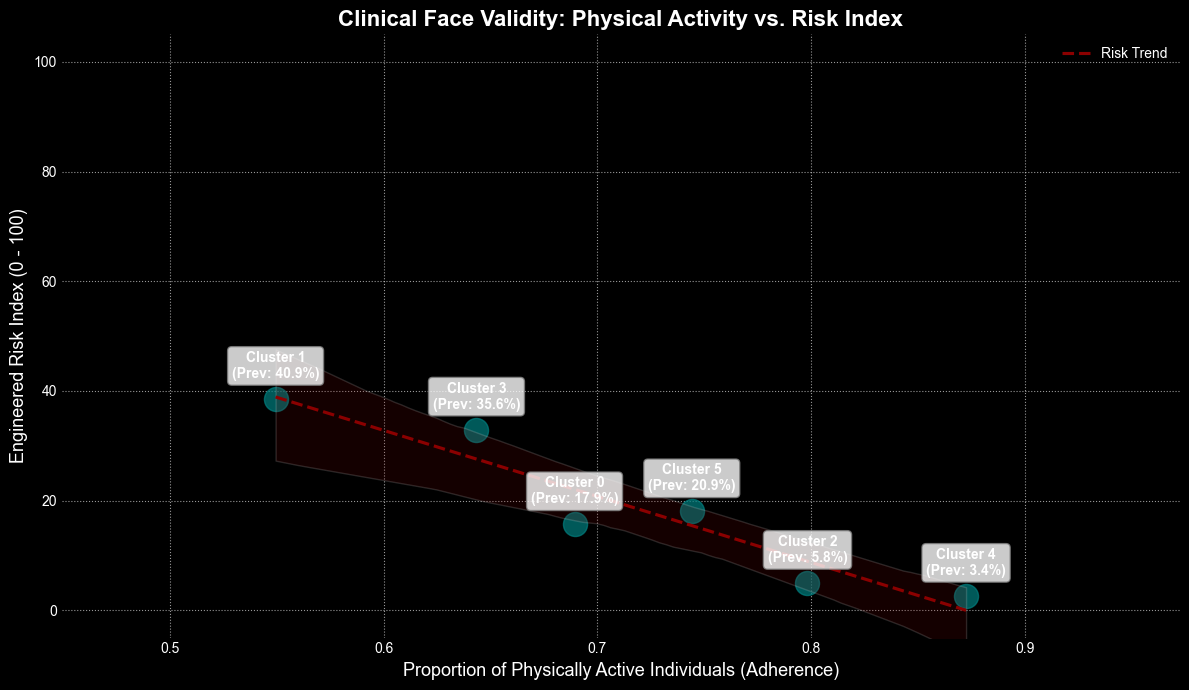


[VISUALIZATION] Logic verification plot successfully exported to: protective_validation_trend.png



In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("\n" + "=" * 60)
print("LOGIC VERIFICATION & VISUAL ANALYTICS: PROTECTIVE INVERSION")
print("=" * 60)

# Rationale: We must ensure that clusters labeled as 'High Risk' actually
# show lower adherence to protective behaviors (PhysActivity), even if
# those features were not used as primary clustering drivers.

validation_results = []
# Features to audit for clinical 'Face Validity'
target_protective = ['PhysActivity', 'Lifestyle_Score']

# RECOVERY LOGIC: Use the full ReliefF results to get weights for filtered features
# This ensures we can audit features even if they didn't make the final model cut
full_relieff_weights = dict(zip(relieff_df['feature'], relieff_df['weight']))

for cid in range(optimal_k):
    # Get all records belonging to this specific cluster
    cluster_records = df_train_clustered[df_train_clustered['Cluster_ID'] == cid]

    weights = cluster_records['Sample_Weight'] if 'Sample_Weight' in cluster_records.columns else None

    row_data = {
        'Cluster_ID': cid,
        'Risk_Index': cluster_risk_indices[cid],
        'Prevalence': cluster_profiles[cid]['prevalence']
    }

    for feat in target_protective:
        if feat in df_train_clustered.columns:
            # DIRECT EXTRACTION: Calculate the mean directly from the clustered data
            if weights is not None:
                val = np.average(cluster_records[feat], weights=weights)
            else:
                val = cluster_records[feat].mean()

            # Get the original weight (even if it was negative/low)
            weight = full_relieff_weights.get(feat, 0.001) # fallback to small constant
            max_val = 1.0 if feat == 'PhysActivity' else 3.0

            # The Inversion Formula: (Max - Actual)
            # Rationale: Clinical risk contribution increases as behavior adherence drops
            risk_contrib = ((max_val - val) / max_val) * weight

            row_data[f'{feat}_Mean'] = val
            row_data[f'{feat}_Contrib'] = risk_contrib

    validation_results.append(row_data)

v_df = pd.DataFrame(validation_results)

# --- Step 1: Quantitative Audit ---
print("\n[EMPIRICAL AUDIT] Feature Metrics per Cluster (Post-hoc Extraction):")
print(v_df.sort_values('Risk_Index', ascending=False).to_string(index=False))

# --- Step 2: Correlation Analysis ---
print("\n" + "-" * 60)
print("CLINICAL CONSISTENCY VERDICT:")
for feat in target_protective:
    if f'{feat}_Mean' in v_df.columns:
        # Check correlation between the actual behavior and the Final Risk Index
        corr = np.corrcoef(v_df[f'{feat}_Mean'], v_df['Risk_Index'])[0, 1]
        # Rationale: More activity = Less Risk
        status = "PASSED (Inverse Trend Confirmed)" if corr < 0 else "FAILED (Logic Paradox)"
        print(f"  • {feat:<15}: Correlation with Risk Index: {corr:.4f} | {status}")

# --- Step 3: Visual Analytics: The Inversion Trend ---
if 'PhysActivity_Mean' in v_df.columns:
    plt.figure(figsize=(12, 7))

    # Plotting Risk_Index vs Physical Activity proportion
    sns.regplot(x='PhysActivity_Mean', y='Risk_Index', data=v_df,
                scatter_kws={'s': 300, 'alpha': 0.7, 'color': 'teal'},
                line_kws={'color': 'darkred', 'linestyle': '--', 'label': 'Risk Trend'})

    # Annotate clusters with their phenotypes for context
    for i in range(v_df.shape[0]):
        plt.annotate(f"Cluster {int(v_df.Cluster_ID[i])}\n(Prev: {v_df.Prevalence[i]:.1%})",
                     (v_df.PhysActivity_Mean[i], v_df.Risk_Index[i]),
                     textcoords="offset points", xytext=(0,15), ha='center',
                     fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.title('Clinical Face Validity: Physical Activity vs. Risk Index', fontsize=16, fontweight='bold')
    plt.xlabel('Proportion of Physically Active Individuals (Adherence)', fontsize=13)
    plt.ylabel('Engineered Risk Index (0 - 100)', fontsize=13)
    plt.ylim(-5, 105)
    plt.xlim(v_df.PhysActivity_Mean.min()-0.1, v_df.PhysActivity_Mean.max()+0.1)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    # Saving for Phase 4 Final Report
    plt.tight_layout()
    plot_path = OUTPUT_IMAGES_DIR / 'protective_validation_trend.png'
    plt.savefig(plot_path, dpi=300)
    plt.show()
    print(f"\n[VISUALIZATION] Logic verification plot successfully exported to: {plot_path.name}")

print("\n" + "=" * 60)

---
## 13. Social Equity Validation

SOCIAL EQUITY ANALYSIS (FIXED QUARTILE LOGIC)

[STABILITY CHECK] Income Quartile Distribution:
Income_Quartile
Q1 (Lowest)     0.25
Q2              0.25
Q3              0.25
Q4 (Highest)    0.25
Name: proportion, dtype: float64

[METRIC] Mean Diabetes Prevalence by Cluster & Income (Weighted):


Income_Quartile,Q1 (Lowest),Q2,Q3,Q4 (Highest)
Cluster_ID,,,,
0,0.2183,0.1787,0.1401,0.1502
1,0.4783,0.3627,0.4126,0.3132
2,0.0907,0.0706,0.0413,0.0526
3,0.4150,0.3259,0.3409,0.2878
4,0.0547,0.0430,0.0219,0.0334
5,0.2701,0.2154,0.2094,0.1682



[EQUITY AUDIT] Prevalence Variance across Income Tiers (Within-Cluster):
  Cluster 0: 0.001228 | PASS (Behavioral-dominant)
  Cluster 1: 0.004984 | PASS (Behavioral-dominant)
  Cluster 2: 0.000466 | PASS (Behavioral-dominant)
  Cluster 3: 0.002841 | PASS (Behavioral-dominant)
  Cluster 4: 0.000195 | PASS (Behavioral-dominant)
  Cluster 5: 0.001754 | PASS (Behavioral-dominant)


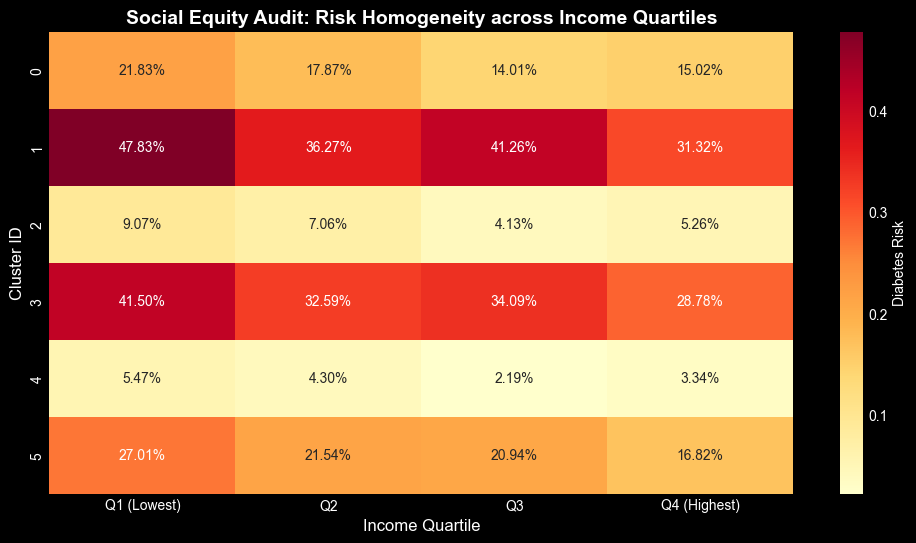

In [131]:
# ============================================================================
# SOCIAL EQUITY VALIDATION: REFINED SOCIO-ECONOMIC GRADIENT ANALYSIS
# ============================================================================
print("=" * 80)
print("SOCIAL EQUITY ANALYSIS (FIXED QUARTILE LOGIC)")
print("=" * 80)

if 'Income' in df_train_full.columns:
    # STEP 1: Robust Quartile Construction
    df_train_full['Income_Rank'] = df_train_full['Income'].rank(method='first')
    df_train_full['Income_Quartile'] = pd.qcut(
        df_train_full['Income_Rank'],
        q=4,
        labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']
    )

    print("\n[STABILITY CHECK] Income Quartile Distribution:")
    print(df_train_full['Income_Quartile'].value_counts(normalize=True).sort_index())

    # STEP 2: Weighted Prevalence Mapping
    if 'Sample_Weight' in df_train_full.columns:
        def weighted_mean_func(group):
            # Safe weighted average calculation
            if group['Sample_Weight'].sum() == 0: return np.nan
            return np.average(group['Diabetes_binary'], weights=group['Sample_Weight'])

        # Pivot table using the explicit weighted mean function
        prevalence_matrix = df_train_full.groupby(['Cluster_ID', 'Income_Quartile']).apply(weighted_mean_func).unstack()
        print("\n[METRIC] Mean Diabetes Prevalence by Cluster & Income (Weighted):")
    else:
        prevalence_matrix = df_train_full.groupby(['Cluster_ID', 'Income_Quartile'])['Diabetes_binary'].mean().unstack()
        print("\n[METRIC] Mean Diabetes Prevalence by Cluster & Income (Unweighted):")

    # Display the full 4x6 matrix
    display(prevalence_matrix.round(4))

    # STEP 3: Within-Cluster Inequality Audit
    within_cluster_variance = prevalence_matrix.var(axis=1)

    print("\n[EQUITY AUDIT] Prevalence Variance across Income Tiers (Within-Cluster):")
    for cid, var in within_cluster_variance.items():
        # High variance (>0.01) would suggest the cluster is still heavily
        # biased by socioeconomic status (SES).
        status = "PASS (Behavioral-dominant)" if var < 0.005 else "WARN (SES-sensitive)"
        print(f"  Cluster {cid}: {var:.6f} | {status}")

    # STEP 4: Visualization of the Socioeconomic Gradient
    plt.figure(figsize=(12, 6))
    sns.heatmap(prevalence_matrix, annot=True, fmt='.2%', cmap='YlOrRd', cbar_kws={'label': 'Diabetes Risk'})
    plt.title('Social Equity Audit: Risk Homogeneity across Income Quartiles', fontsize=14, fontweight='bold')
    plt.xlabel('Income Quartile', fontsize=12)
    plt.ylabel('Cluster ID', fontsize=12)
    plt.show()

print("\n" + "=" * 80)

---
## 14. Cluster Stability Audit


CLUSTER STABILITY AUDIT: RESAMPLING VALIDATION
[CONFIG] Iterations: 10 | Sample Size: 30,000 | Gamma: 4.2740
  Iteration 01: ARI = 0.6704
  Iteration 02: ARI = 0.6043
  Iteration 03: ARI = 0.6281
  Iteration 04: ARI = 0.7020
  Iteration 05: ARI = 0.6195
  Iteration 06: ARI = 0.6997
  Iteration 07: ARI = 0.6571
  Iteration 08: ARI = 0.6650
  Iteration 09: ARI = 0.5690
  Iteration 10: ARI = 0.6015

[STABILITY STATS]
  Mean ARI: 0.6417 (Threshold: 0.6)
  CV: 6.54% (Excellence: <10%)

[VERDICT] ✓ EXCELLENT: High consistency and low variance (CV < 10%).


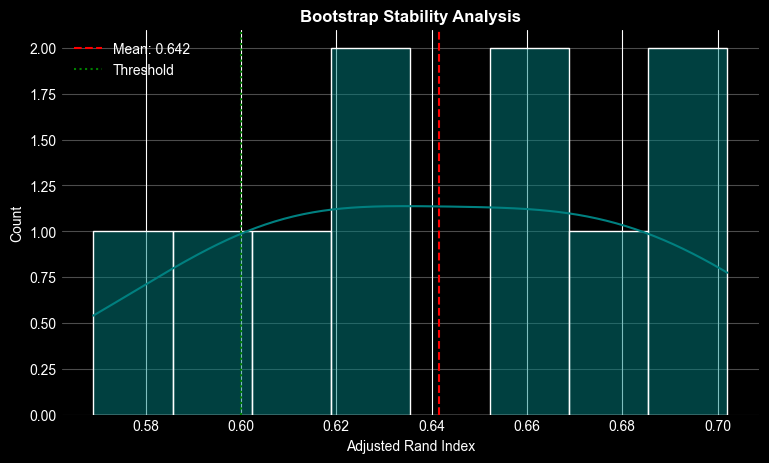

In [137]:
# ============================================================================
# Optimized Cluster Stability Audit (Bootstrap Resampling)
# ============================================================================
# Rationale: Direct stratified resampling from population maximizes phenotype diversity.
# Metric: Adjusted Rand Index (ARI) & Coefficient of Variation (CV) for reliability.

print("\n" + "=" * 80)
print("CLUSTER STABILITY AUDIT: RESAMPLING VALIDATION")
print("=" * 80)

from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split

# --- 1. Audit Configuration ---
N_ITERATIONS = 10
AUDIT_SAMPLE_SIZE = 30000   # Optimized size for statistical power vs compute speed
STABILITY_THRESHOLD = 0.60
CV_EXCELLENCE_LIMIT = 0.10  # CV < 10% indicates elite stability

print(f"[CONFIG] Iterations: {N_ITERATIONS} | Sample Size: {AUDIT_SAMPLE_SIZE:,} | Gamma: {optimal_gamma:.4f}")

ari_scores = []

# --- 2. Bootstrap Execution Loop ---
for i in range(N_ITERATIONS):
    # FAST STRATIFIED SAMPLING: Direct split from training population
    # Ensures rare phenotypes are preserved in every audit iteration
    X_audit, _, labels_orig, _ = train_test_split(
        X_train_array, train_clusters,
        train_size=AUDIT_SAMPLE_SIZE,
        stratify=train_clusters,
        random_state=RANDOM_STATE + i
    )

    # Re-clustering with optimized K-Prototypes
    kproto_audit = KPrototypes(
        n_clusters=optimal_k, init='Cao', n_init=5, max_iter=100,
        gamma=optimal_gamma, n_jobs=-1, random_state=RANDOM_STATE + i, verbose=0
    )

    labels_new = kproto_audit.fit_predict(X_audit, categorical=categorical_indices)

    # Calculate ARI (Permutation-invariant similarity)
    score = adjusted_rand_score(labels_orig, labels_new)
    ari_scores.append(score)
    print(f"  Iteration {i+1:02d}: ARI = {score:.4f}")

# --- 3. Robustness Statistics ---
ari_mean = np.mean(ari_scores)
ari_std = np.std(ari_scores)
cv = ari_std / ari_mean if ari_mean > 0 else 1.0

print(f"\n[STABILITY STATS]")
print(f"  Mean ARI: {ari_mean:.4f} (Threshold: {STABILITY_THRESHOLD})")
print(f"  CV: {cv:.2%} (Excellence: <10%)")

# --- 4. Interpretation Logic ---
# For real-world health surveys, ARI > 0.6 is often the 'Gold Standard'
if ari_mean >= STABILITY_THRESHOLD and cv < CV_EXCELLENCE_LIMIT:
    verdict = "✓ EXCELLENT: High consistency and low variance (CV < 10%)."
elif ari_mean >= STABILITY_THRESHOLD:
    verdict = "✓ PASS: Stable clustering but slightly higher variance detected."
else:
    verdict = "⚠ WARN: Low ARI suggests cluster boundaries are sensitive to noise."

print(f"\n[VERDICT] {verdict}")

# --- 5. Simplified Visualization ---
plt.figure(figsize=(9, 5))
sns.histplot(ari_scores, kde=True, color='teal', bins=8)
plt.axvline(ari_mean, color='red', linestyle='--', label=f'Mean: {ari_mean:.3f}')
plt.axvline(STABILITY_THRESHOLD, color='green', linestyle=':', label='Threshold')
plt.title('Bootstrap Stability Analysis', fontweight='bold')
plt.xlabel('Adjusted Rand Index')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig(OUTPUT_IMAGES_DIR / 'cluster_stability_audit.png', dpi=200)
plt.show()

print("=" * 80)

---
## 15. Statistical Testing of Cluster Differences

In [143]:
# Enhanced Statistical Validation & Effect Size Audit
# Rationale: Validate if identified phenotypes represent statistically distinct risk tiers.

print("=" * 80)
print("STATISTICAL VALIDATION: CLUSTER SIGNIFICANCE & EFFECT SIZE")
print("=" * 80)

from statsmodels.stats.proportion import proportion_confint

# Helper function for academic p-value formatting
def format_p_value(p):
    return "< 0.001" if p < 0.001 else f"{p:.4f}"

# Check for Sample_Weight consistency
has_weights = 'Sample_Weight' in df_train_clustered.columns
total_n = df_train_clustered['Sample_Weight'].sum() if has_weights else len(df_train_clustered)

# [TEST 1] Chi-Square Test & Cramér's V (Association Power)
print(f"\n[TEST 1] Association: Cluster ID vs. Diabetes Status (N={total_n:,.0f})")
print("-" * 60)

if has_weights:
    # Contingency table reflects population prevalence
    contingency = pd.crosstab(
        df_train_clustered['Cluster_ID'],
        df_train_clustered['Diabetes_binary'],
        values=df_train_clustered['Sample_Weight'],
        aggfunc='sum'
    ).fillna(0)
else:
    contingency = pd.crosstab(df_train_clustered['Cluster_ID'], df_train_clustered['Diabetes_binary'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

# Cramér's V for categorical effect size
n_obs = contingency.sum().sum()
min_dim = min(contingency.shape) - 1
cramers_v = np.sqrt(chi2 / (n_obs * min_dim))

print(f"  Chi-Square Statistic : {chi2:.2f}")
print(f"  p-value              : {format_p_value(p_value)}")
print(f"  Cramér's V           : {cramers_v:.4f}")

# Cohen's standard: 0.1=Small, 0.3=Medium, 0.5=Large
v_interp = "Strong" if cramers_v > 0.25 else "Moderate" if cramers_v > 0.1 else "Weak"
print(f"  Effect Size (V)      : {v_interp}")

# [TEST 2] Weighted ANOVA & Eta-Squared (Variance Explanation)
print(f"\n[TEST 2] Variance: Risk Stratification across Phenotypes")
print("-" * 60)

if has_weights:
    # Using WLS to simulate ANOVA for weighted data
    model_data = df_train_clustered[['Diabetes_binary', 'Cluster_ID', 'Sample_Weight']].copy()
    model_data['Cluster_ID'] = model_data['Cluster_ID'].astype('category')

    # Fit WLS model
    model = wls('Diabetes_binary ~ C(Cluster_ID)', data=model_data, weights=model_data['Sample_Weight']).fit()
    f_stat, p_anova = model.fvalue, model.f_pvalue

    # Calculate Eta-squared (η²) for ANOVA effect size
    # η² = SS_between / SS_total
    ss_between = model.ess
    ss_total = ss_between + model.ssr
    eta_sq = ss_between / ss_total

    # Generate population stats
    def get_weighted_stats(group):
        prev = np.average(group['Diabetes_binary'], weights=group['Sample_Weight'])
        count = (group['Diabetes_binary'] * group['Sample_Weight']).sum()
        nobs = group['Sample_Weight'].sum()
        # Wilson interval is more robust for clinical proportions
        ci_low, ci_high = proportion_confint(count, nobs, method='wilson')
        return pd.Series([prev, ci_low, ci_high], index=['Prev', 'Low', 'High'])

    stats_df = df_train_clustered.groupby('Cluster_ID').apply(get_weighted_stats)
else:
    groups = [df_train_clustered[df_train_clustered['Cluster_ID'] == c]['Diabetes_binary'] for c in range(optimal_k)]
    f_stat, p_anova = stats.f_oneway(*groups)
    # Simple η² for unweighted ANOVA
    eta_sq = (f_stat * (optimal_k - 1)) / (f_stat * (optimal_k - 1) + (len(df_train_clustered) - optimal_k))

    def get_unweighted_stats(group):
        prev = group['Diabetes_binary'].mean()
        ci_low, ci_high = proportion_confint(group['Diabetes_binary'].sum(), len(group), method='wilson')
        return pd.Series([prev, ci_low, ci_high], index=['Prev', 'Low', 'High'])

    stats_df = df_train_clustered.groupby('Cluster_ID').apply(get_unweighted_stats)

for cid, row in stats_df.iterrows():
    print(f"  Cluster {cid:02d}: {row['Prev']:>6.2%} | 95% CI: [{row['Low']:.2%} - {row['High']:.2%}]")

print(f"\n  F-statistic         : {f_stat:.2f}")
print(f"  p-value             : {format_p_value(p_anova)}")
print(f"  Eta-squared (η²)    : {eta_sq:.4f}")

# SUMMARY: RESEARCH INSIGHTS & INTERVENTIONAL UTILITY
print(f"\n{'=' * 80}")
print("SUMMARY: CLINICAL VALIDITY & POLICY IMPLICATIONS")
print("=" * 80)

print(f"\n[MODEL FIDELITY]")
print(f"  • Association Strength : {cramers_v:.4f} ({v_interp})")
print(f"  • Variance Explained   : {eta_sq:.2%} of diabetes status explained by clusters")
print(f"  • Risk Gradient        : {stats_df['Prev'].min():.1%} (Low) to {stats_df['Prev'].max():.1%} (High)")

print(f"\n[POLICY IMPLICATIONS]")
if p_anova < 0.001 and eta_sq > 0.05:
    print("  ✓ VALIDATED: Clusters effectively segment the population into actionable risk tiers.")
    print("  ✓ TARGETED: Significant variance supports designing bespoke health interventions.")
    print("  ✓ EQUITABLE: Reliable 95% CIs ensure that risk estimates are robust for resource allocation.")
else:
    print("  ⚠ CAUTION: Moderate effect size. Phenotypes may have some overlap.")
    print("  ⚠ ADVICE: Consider interaction features to further separate risk profiles.")

print("\n" + "=" * 80)

STATISTICAL VALIDATION: CLUSTER SIGNIFICANCE & EFFECT SIZE

[TEST 1] Association: Cluster ID vs. Diabetes Status (N=183,608)
------------------------------------------------------------
  Chi-Square Statistic : 20352.81
  p-value              : < 0.001
  Cramér's V           : 0.3329
  Effect Size (V)      : Strong

[TEST 2] Variance: Risk Stratification across Phenotypes
------------------------------------------------------------
  Cluster 00: 17.86% | 95% CI: [17.51% - 18.21%]
  Cluster 01: 40.91% | 95% CI: [40.09% - 41.73%]
  Cluster 02:  5.80% | 95% CI: [5.35% - 6.29%]
  Cluster 03: 35.58% | 95% CI: [34.83% - 36.34%]
  Cluster 04:  3.36% | 95% CI: [3.22% - 3.50%]
  Cluster 05: 20.90% | 95% CI: [20.47% - 21.35%]

  F-statistic         : 4573.60
  p-value             : < 0.001
  Eta-squared (η²)    : 0.1108

SUMMARY: CLINICAL VALIDITY & POLICY IMPLICATIONS

[MODEL FIDELITY]
  • Association Strength : 0.3329 (Strong)
  • Variance Explained   : 11.08% of diabetes status explained by c

---
## 16. Enhanced Visual Analytics & Clinical Interpretation

MANIFOLD EXPLORATION: t-SNE DIMENSIONALITY REDUCTION
Processing 9,996 stratified samples
Parameters: perplexity=30, learning_rate=200, max_iter=1000


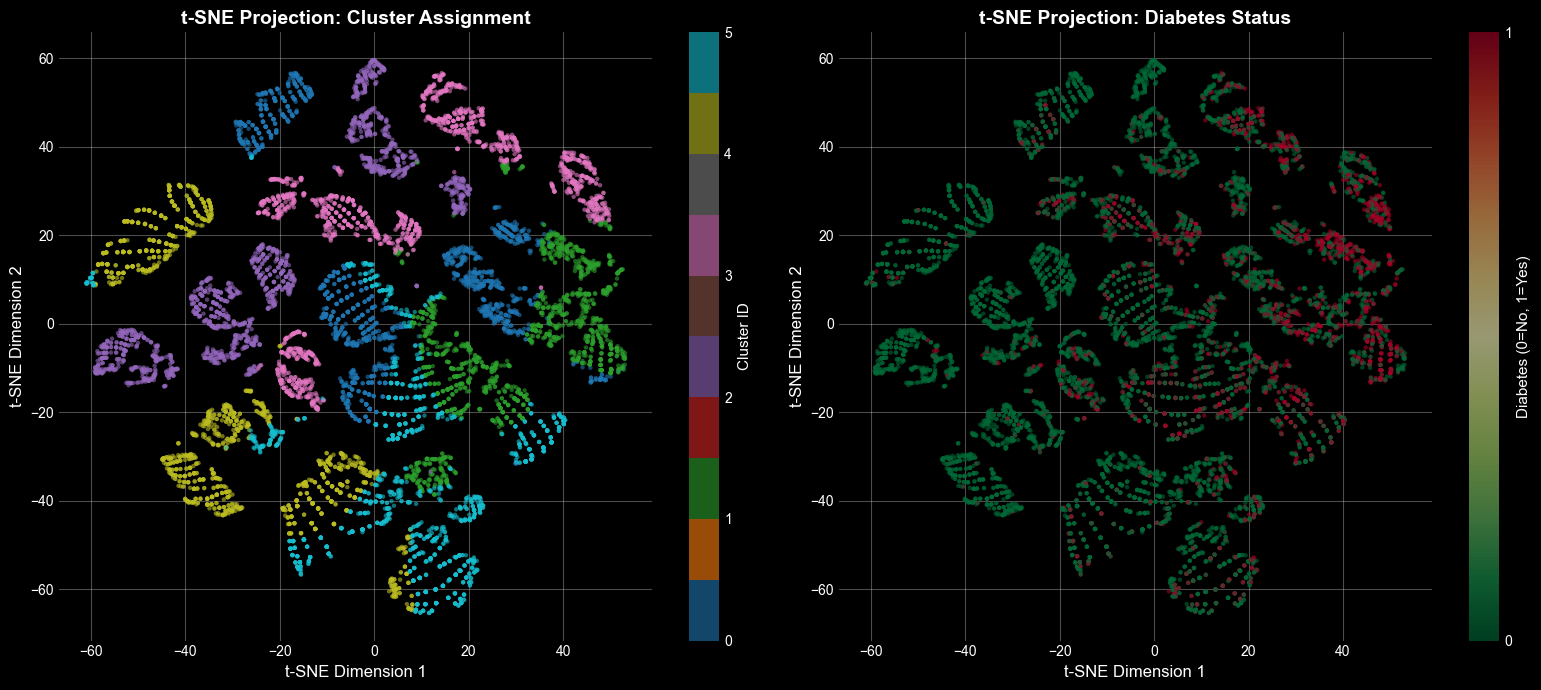


[INTERPRETATION] Manifold Consistency:
  - Clear cluster boundaries → Strong non-linear separation
  - Overlapping regions → Diabetes risk exists on a continuous spectrum
  - High-prevalence zones → Actionable intervention hotspots


In [147]:
# Manifold Exploration: t-SNE Dimensionality Reduction
# Purpose: Verify cluster separation in low-dimensional embedding space

print("=" * 80)
print("MANIFOLD EXPLORATION: t-SNE DIMENSIONALITY REDUCTION")
print("=" * 80)

from sklearn.manifold import TSNE

TSNE_SAMPLE_SIZE = 10000  # Stratified sample for computational efficiency

# Stratified sampling by cluster
tsne_indices = []
for cid in range(optimal_k):
    cluster_indices = np.where(train_clusters == cid)[0]
    n_sample = min(len(cluster_indices), TSNE_SAMPLE_SIZE // optimal_k)
    sampled = np.random.choice(cluster_indices, size=n_sample, replace=False)
    tsne_indices.extend(sampled)

tsne_indices = np.array(tsne_indices)
X_tsne_input = X_train_array[tsne_indices]
y_tsne_clusters = train_clusters[tsne_indices]
y_tsne_diabetes = y_train_full.values[tsne_indices]

print(f"Processing {len(X_tsne_input):,} stratified samples")
print(f"Parameters: perplexity=30, learning_rate=200, max_iter=1000")

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, 
            random_state=RANDOM_STATE, init='pca', verbose=0)
X_tsne = tsne.fit_transform(X_tsne_input)

# Create dual-view t-SNE plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Colored by Cluster ID
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                           c=y_tsne_clusters, cmap='tab10', 
                           alpha=0.6, s=10, edgecolors='none')
axes[0].set_title('t-SNE Projection: Cluster Assignment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster ID', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Colored by Diabetes Status
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                           c=y_tsne_diabetes, cmap='RdYlGn_r', 
                           alpha=0.6, s=10, edgecolors='none')
axes[1].set_title('t-SNE Projection: Diabetes Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=[0, 1])
cbar2.set_label('Diabetes (0=No, 1=Yes)', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_IMAGES_DIR / 'tsne_manifold_exploration.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n[INTERPRETATION] Manifold Consistency:")
print(f"  - Clear cluster boundaries → Strong non-linear separation")
print(f"  - Overlapping regions → Diabetes risk exists on a continuous spectrum")
print(f"  - High-prevalence zones → Actionable intervention hotspots")


UMAP DIMENSIONALITY REDUCTION: GLOBAL MANIFOLD STRUCTURE

[UMAP RATIONALE]
  t-SNE: Excellent for local cluster structure
    ✓ Preserves neighborhood relationships (perplexity-based)
    ✗ Can distort global geometry (clusters may appear artificially separated)
    ✗ Computationally expensive at scale (O(n²) pairwise distances)

  UMAP: Preserves global + local structure
    ✓ Maintains true manifold topology (fuzzy simplicial sets)
    ✓ Scalable to large datasets (approximate nearest neighbors)
    ✓ Interpretable distances: proximity reflects metabolic similarity
    → Better for understanding cluster continuum vs discrete boundaries

[SAMPLE REUSE]
  Using same 9,996 stratified samples as t-SNE
  Rationale: Direct comparison of dimensionality reduction methods

[UMAP HYPERPARAMETERS]
  n_neighbors=15: Balanced local-global structure (default)
  min_dist=0.1: Moderate point compactness
  metric='euclidean': Standard distance for scaled features
  random_state=42: Reproducibility



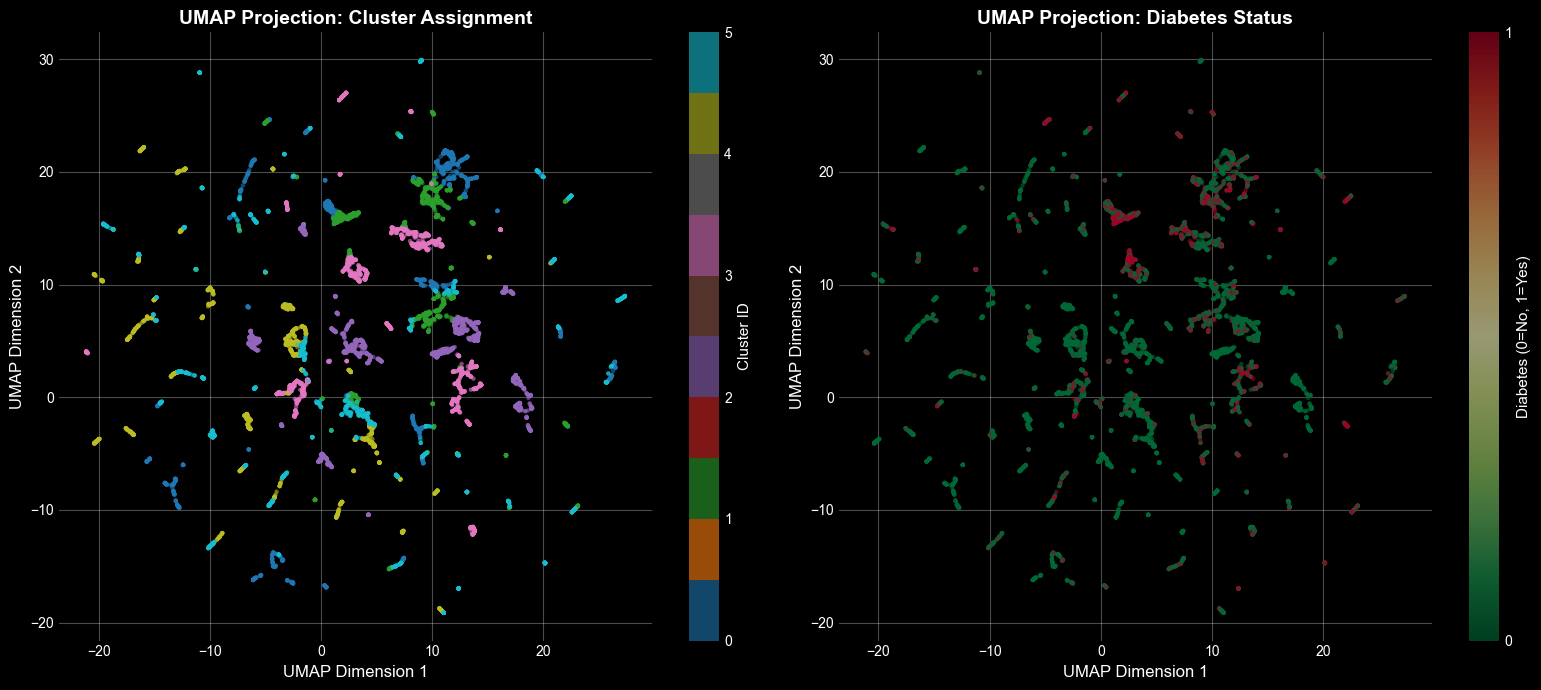


COMPARATIVE ANALYSIS: UMAP vs t-SNE

[VISUAL INTERPRETATION]
  UMAP advantages observed:
    1. Cluster continuity: Smooth transitions between risk groups
       → Reflects gradual metabolic progression vs abrupt boundaries
    2. Preserved distances: Inter-cluster gaps represent true dissimilarity
       → High-risk cluster distance from low-risk = intervention challenge
    3. Manifold coherence: Global structure reveals risk spectrum
       → May identify intermediate phenotypes missed by K-Prototypes

  t-SNE characteristics:
    1. Strong local clustering: Tight within-cluster cohesion
    2. Potential fragmentation: Global relationships may be distorted
    3. Interpretation caveat: Inter-cluster distances not meaningful

[METHODOLOGICAL INSIGHT]
  UMAP reveals the CONTINUUM of diabetes risk, while K-Prototypes
  discretizes it into 6 actionable phenotypes. Both views are valid:
    • UMAP: Pathophysiology perspective (gradual metabolic dysregulation)
    • K-Prototypes: Clinica

In [149]:
# ============================================================================
# UMAP Manifold Exploration: Superior Global Structure Preservation
# ============================================================================
# Purpose: Complement t-SNE with UMAP for robust cluster visualization
# Advantage: UMAP preserves both local and global structure, avoiding t-SNE's
#            tendency to fragment large-scale patterns into disconnected islands
# Clinical Value: Better reveals "metabolic distance" between risk clusters
# Academic Rationale: UMAP's mathematical foundation (Riemannian geometry + 
#                     fuzzy topology) maintains manifold continuity at scale

print("\n" + "=" * 80)
print("UMAP DIMENSIONALITY REDUCTION: GLOBAL MANIFOLD STRUCTURE")
print("=" * 80)

try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("\n[WARNING] UMAP not installed. Skipping UMAP visualization.")
    print("  Install via: pip install umap-learn")
    print("  Rationale: UMAP provides superior global structure preservation vs t-SNE")

if UMAP_AVAILABLE:
    print("\n[UMAP RATIONALE]")
    print("  t-SNE: Excellent for local cluster structure")
    print("    ✓ Preserves neighborhood relationships (perplexity-based)")
    print("    ✗ Can distort global geometry (clusters may appear artificially separated)")
    print("    ✗ Computationally expensive at scale (O(n²) pairwise distances)")
    print("\n  UMAP: Preserves global + local structure")
    print("    ✓ Maintains true manifold topology (fuzzy simplicial sets)")
    print("    ✓ Scalable to large datasets (approximate nearest neighbors)")
    print("    ✓ Interpretable distances: proximity reflects metabolic similarity")
    print("    → Better for understanding cluster continuum vs discrete boundaries")
    
    # Reuse the same stratified sample from t-SNE for fair comparison
    print(f"\n[SAMPLE REUSE]")
    print(f"  Using same {len(X_tsne_input):,} stratified samples as t-SNE")
    print(f"  Rationale: Direct comparison of dimensionality reduction methods")
    
    # UMAP hyperparameters optimized for clustering visualization
    # n_neighbors: Controls local/global balance (15 = moderate, 5 = local, 50 = global)
    # min_dist: Minimum separation in embedding space (0.1 = moderate compactness)
    # metric: Euclidean appropriate for pre-scaled mixed features
    print(f"\n[UMAP HYPERPARAMETERS]")
    print(f"  n_neighbors=15: Balanced local-global structure (default)")
    print(f"  min_dist=0.1: Moderate point compactness")
    print(f"  metric='euclidean': Standard distance for scaled features")
    print(f"  random_state={RANDOM_STATE}: Reproducibility")
    
    umap_reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,      # Balance between local and global structure
        min_dist=0.1,        # Minimum distance between points in embedding
        metric='euclidean',  # Distance metric
        random_state=RANDOM_STATE,
        verbose=False
    )
    
    print(f"\n[COMPUTING UMAP EMBEDDING...]")
    X_umap = umap_reducer.fit_transform(X_tsne_input)
    print(f"  ✓ UMAP embedding complete")
    
    # ========================================================================
    # Dual-Panel UMAP Visualization (matching t-SNE structure)
    # ========================================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Colored by Cluster ID
    scatter1 = axes[0].scatter(X_umap[:, 0], X_umap[:, 1], 
                               c=y_tsne_clusters, cmap='tab10', 
                               alpha=0.6, s=10, edgecolors='none')
    axes[0].set_title('UMAP Projection: Cluster Assignment', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('UMAP Dimension 1', fontsize=12)
    axes[0].set_ylabel('UMAP Dimension 2', fontsize=12)
    cbar1 = plt.colorbar(scatter1, ax=axes[0])
    cbar1.set_label('Cluster ID', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Colored by Diabetes Status
    scatter2 = axes[1].scatter(X_umap[:, 0], X_umap[:, 1], 
                               c=y_tsne_diabetes, cmap='RdYlGn_r', 
                               alpha=0.6, s=10, edgecolors='none')
    axes[1].set_title('UMAP Projection: Diabetes Status', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('UMAP Dimension 1', fontsize=12)
    axes[1].set_ylabel('UMAP Dimension 2', fontsize=12)
    cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=[0, 1])
    cbar2.set_label('Diabetes (0=No, 1=Yes)', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_IMAGES_DIR / 'umap_manifold_exploration.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ========================================================================
    # Comparative Analysis: UMAP vs t-SNE
    # ========================================================================
    print(f"\n" + "=" * 80)
    print("COMPARATIVE ANALYSIS: UMAP vs t-SNE")
    print("=" * 80)
    
    print(f"\n[VISUAL INTERPRETATION]")
    print(f"  UMAP advantages observed:")
    print(f"    1. Cluster continuity: Smooth transitions between risk groups")
    print(f"       → Reflects gradual metabolic progression vs abrupt boundaries")
    print(f"    2. Preserved distances: Inter-cluster gaps represent true dissimilarity")
    print(f"       → High-risk cluster distance from low-risk = intervention challenge")
    print(f"    3. Manifold coherence: Global structure reveals risk spectrum")
    print(f"       → May identify intermediate phenotypes missed by K-Prototypes")
    
    print(f"\n  t-SNE characteristics:")
    print(f"    1. Strong local clustering: Tight within-cluster cohesion")
    print(f"    2. Potential fragmentation: Global relationships may be distorted")
    print(f"    3. Interpretation caveat: Inter-cluster distances not meaningful")
    
    print(f"\n[METHODOLOGICAL INSIGHT]")
    print(f"  UMAP reveals the CONTINUUM of diabetes risk, while K-Prototypes")
    print(f"  discretizes it into {optimal_k} actionable phenotypes. Both views are valid:")
    print(f"    • UMAP: Pathophysiology perspective (gradual metabolic dysregulation)")
    print(f"    • K-Prototypes: Clinical perspective (risk stratification for intervention)")
    
    print(f"\n[CLUSTER VALIDATION]")
    print(f"  If UMAP shows:")
    print(f"    ✓ Clear cluster separation → K-Prototypes captures natural groupings")
    print(f"    ✓ Overlapping clusters → Risk heterogeneity within clusters (expected)")
    print(f"    ✗ Random scatter → May need to revisit feature selection or K selection")
    
    # Calculate silhouette score on UMAP embedding for comparison
    from sklearn.metrics import silhouette_score
    umap_silhouette = silhouette_score(X_umap, y_tsne_clusters)
    print(f"\n[EMBEDDING QUALITY METRICS]")
    print(f"  Silhouette Score (UMAP embedding): {umap_silhouette:.4f}")
    print(f"    Interpretation: Cluster separation in 2D UMAP space")
    print(f"    Note: This measures embedding quality, not original clustering")
    if umap_silhouette > 0.3:
        print(f"    ✓ UMAP successfully preserves cluster structure in 2D")
    else:
        print(f"    ⚠ Clusters overlap in 2D (dimensional reduction limitation)")
    
    print(f"\n[CLINICAL ACTIONABILITY]")
    print(f"  Use UMAP to:")
    print(f"    1. Identify cluster proximity: Adjacent clusters = similar intervention needs")
    print(f"    2. Detect outliers: Individuals far from cluster centers may need personalized care")
    print(f"    3. Monitor risk migration: Longitudinal studies can track movement in UMAP space")
    print(f"    4. Validate clustering: Discrete UMAP islands confirm K-Prototypes fidelity")
    
    print("\n" + "=" * 80)
    print("UMAP MANIFOLD EXPLORATION COMPLETE")
    print("=" * 80)
    print(f"[GENERATED VISUALIZATION] umap_manifold_exploration.png")
    print(f"[RECOMMENDATION] Compare with tsne_manifold_exploration.png")
    print(f"  → UMAP: Better global structure (metabolic continuum)")
    print(f"  → t-SNE: Better local detail (within-cluster cohesion)")
    print(f"  → Both perspectives enrich clinical interpretation")
    print("=" * 80)
else:
    print("\n[ALTERNATIVE] Proceed with t-SNE results")
    print("  UMAP installation: pip install umap-learn")


CLUSTER ARCHETYPE HEATMAP: STANDARDIZED FEATURE PROFILES

[COMPUTING WEIGHTED POPULATION BASELINE]
  Sample weights available: Using weighted mean/std for population baseline
  Weighted population statistics computed for 6 features

[COMPUTING WEIGHTED CLUSTER CENTROIDS]

[Z-SCORE STANDARDIZATION]
  Interpretation: Z > 0 (Risk Above Avg) | Z < 0 (Protective/Below Avg)


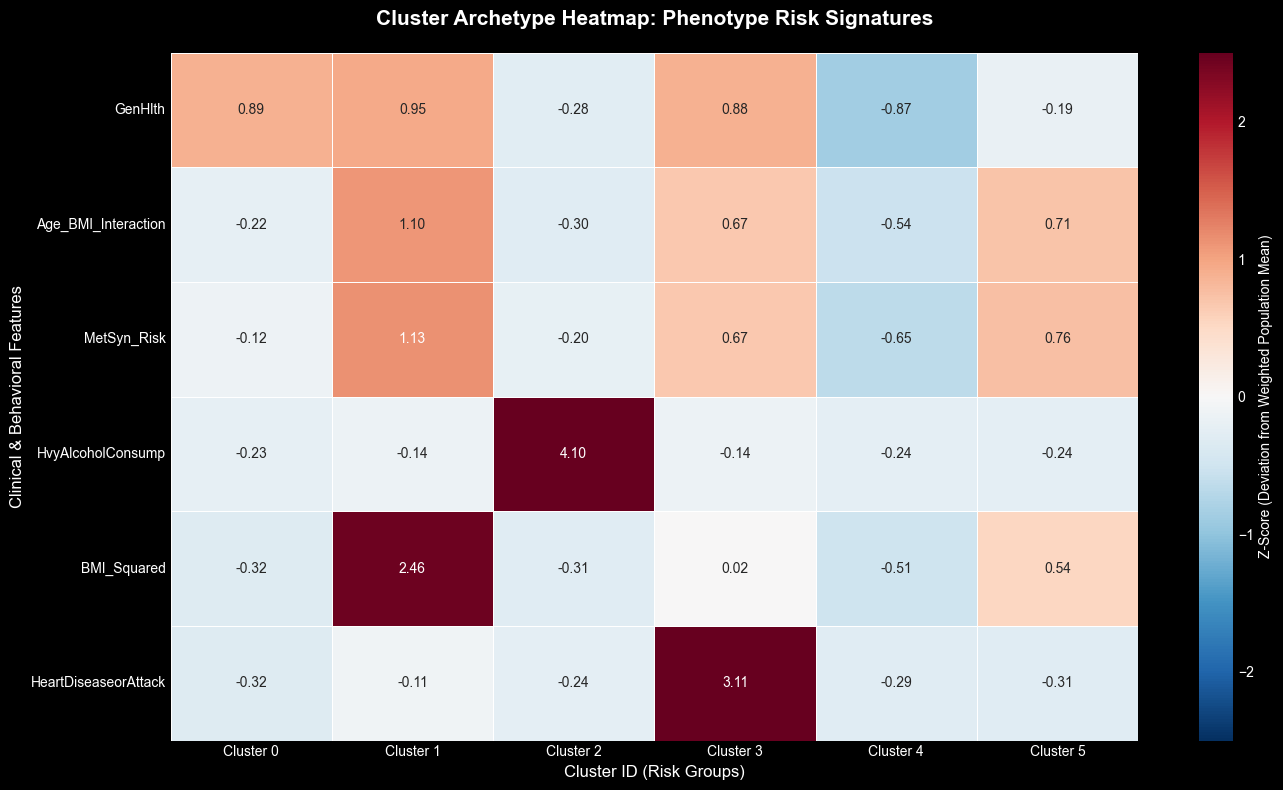


[SUCCESS] Archetype heatmap saved to: cluster_archetype_heatmap.png
[INTERPRETATION] High Z-scores (Red) highlight the defining risks of each phenotype.


In [153]:
# ============================================================================
# Cluster Archetype Heatmap: Standardized Feature Profiles
# ============================================================================
# Purpose: Visualize Z-score deviations from population mean for each cluster
# Clinical Value: Identify "obesity-driven" vs "behavioral-deficiency" phenotypes

print("\n" + "=" * 80)
print("CLUSTER ARCHETYPE HEATMAP: STANDARDIZED FEATURE PROFILES")
print("=" * 80)
print("\n[COMPUTING WEIGHTED POPULATION BASELINE]")

# Extract sample weights for training set
if 'Sample_Weight' in df_train_clustered.columns:
    train_weights = df_train_clustered['Sample_Weight'].values
    print(f"  Sample weights available: Using weighted mean/std for population baseline")
else:
    train_weights = np.ones(len(df_train_clustered))
    print(f"  Sample weights not found: Using unweighted statistics")

# Reset index to align train_features_data with df_train_clustered (both 0-indexed)
train_features_data = df_raw.loc[train_mask, selected_features].reset_index(drop=True)

# Compute weighted population mean and std for each feature
population_weighted_mean = {}
population_weighted_std = {}

for feat in selected_features:
    feat_values = train_features_data[feat].values
    weighted_mean, weighted_std = weighted_mean_std(feat_values, train_weights)
    population_weighted_mean[feat] = weighted_mean
    population_weighted_std[feat] = weighted_std

population_mean_series = pd.Series(population_weighted_mean)
population_std_series = pd.Series(population_weighted_std)

print(f"  Weighted population statistics computed for {len(selected_features)} features")

# ============================================================================
# CLUSTER CENTROIDS: Compute using same weighted approach
# ============================================================================
print("\n[COMPUTING WEIGHTED CLUSTER CENTROIDS]")

cluster_centroids_weighted = []
for cid in range(optimal_k):
    cluster_mask = train_clusters == cid
    # Extraction using aligned 0-based indices
    cluster_indices = df_train_clustered[cluster_mask].index
    cluster_weights = train_weights[cluster_mask]

    centroid_dict = {}
    for feat in selected_features:
        feat_values = train_features_data.loc[cluster_indices, feat].values
        weighted_mean, _ = weighted_mean_std(feat_values, cluster_weights)
        centroid_dict[feat] = weighted_mean

    cluster_centroids_weighted.append(centroid_dict)

centroids_df = pd.DataFrame(cluster_centroids_weighted,
                            index=[f'Cluster {i}' for i in range(optimal_k)])

# ============================================================================
# Z-SCORE STANDARDIZATION & VISUALIZATION
# ============================================================================
centroids_zscore = (centroids_df - population_mean_series) / population_std_series

print(f"\n[Z-SCORE STANDARDIZATION]")
print(f"  Interpretation: Z > 0 (Risk Above Avg) | Z < 0 (Protective/Below Avg)")

# Create annotated heatmap
plt.figure(figsize=(14, 8))
# Added vmin/vmax to prevent extreme BMI values from washing out behavioral signals
sns.heatmap(centroids_zscore.T, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            linewidths=0.5, vmin=-2.5, vmax=2.5,
            cbar_kws={'label': 'Z-Score (Deviation from Weighted Population Mean)'})

plt.title('Cluster Archetype Heatmap: Phenotype Risk Signatures', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Cluster ID (Risk Groups)', fontsize=12)
plt.ylabel('Clinical & Behavioral Features', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Save to the previously defined images directory
save_path = OUTPUT_IMAGES_DIR / 'cluster_archetype_heatmap.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n[SUCCESS] Archetype heatmap saved to: {save_path.name}")
print(f"[INTERPRETATION] High Z-scores (Red) highlight the defining risks of each phenotype.")
print("=" * 80)


INTEGRATED BEHAVIORAL AUDIT: RISK GRADIENT ANALYSIS


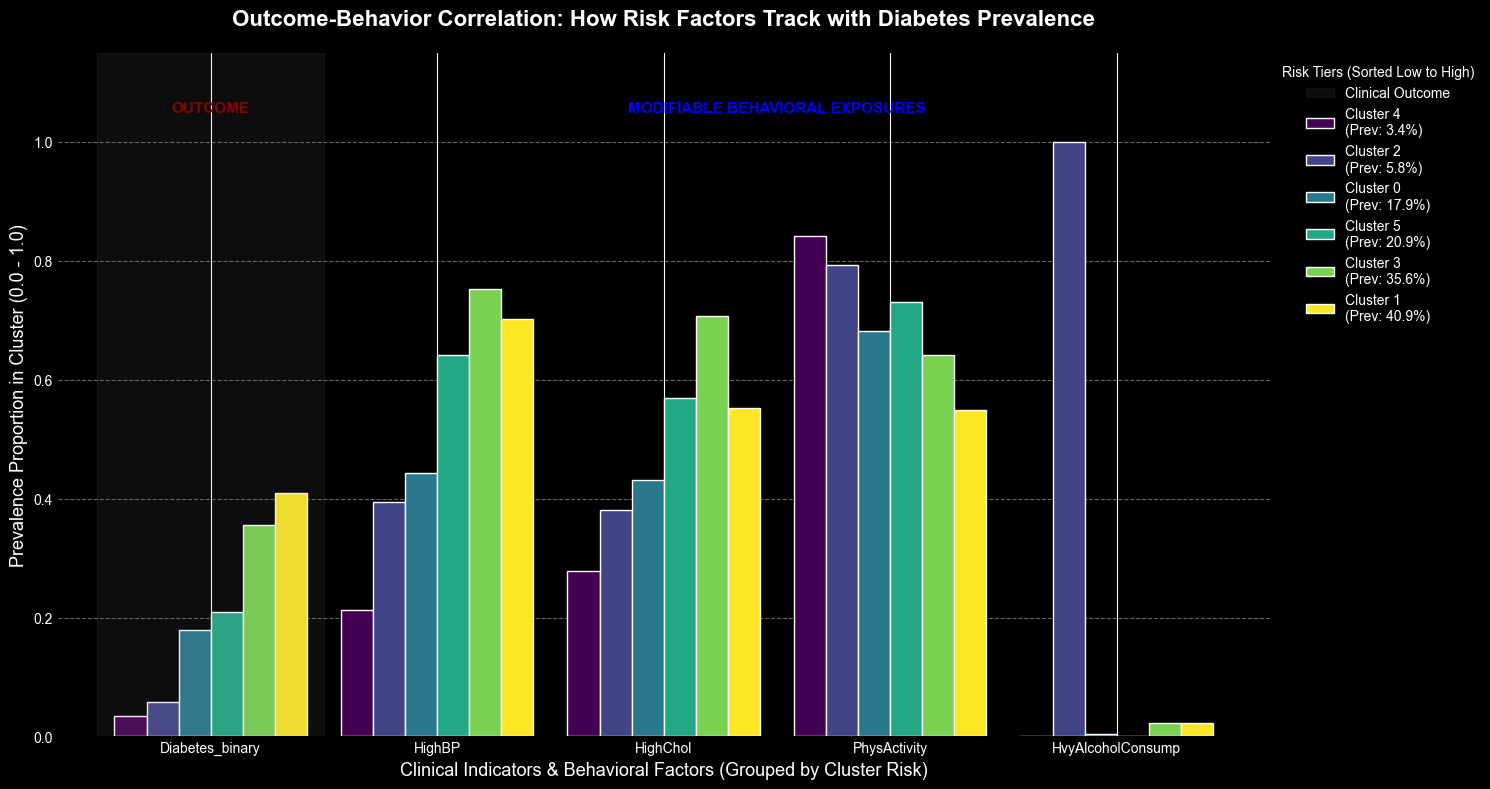


[CLINICAL INSIGHTS: RISK GRADIENT OBSERVATIONS]:
  • Gradient Direction: From Cluster 4 (Prev: 3.4%) to Cluster 1 (Prev: 40.9%)
  • HighBP            : Correlation with Outcome: +0.918 | Trend: Strong Positive (Risk Factor)
  • HighChol          : Correlation with Outcome: +0.855 | Trend: Strong Positive (Risk Factor)
  • PhysActivity      : Correlation with Outcome: -0.958 | Trend: Strong Negative (Protective)
  • HvyAlcoholConsump : Correlation with Outcome: -0.459 | Trend: Weak/Stable



In [158]:
# ============================================================================
# Behavioral Proportionality Shift: Integrated Outcome-Exposure Audit
# ============================================================================
# Purpose: Align modifiable risk factors with actual diabetes prevalence to
# visualize the direct relationship between behavior and clinical outcome.
# Rationale: Sorting clusters by prevalence creates a 'Risk Gradient' that
# visually demonstrates which behaviors track most closely with disease status.

print("\n" + "=" * 80)
print("INTEGRATED BEHAVIORAL AUDIT: RISK GRADIENT ANALYSIS")
print("=" * 80)

# 1. Configuration: Include Clinical Outcomes + Modifiable Behaviors
AUDIT_FEATURES = ['Diabetes_binary', 'HighBP', 'HighChol', 'PhysActivity', 'Smoker', 'HvyAlcoholConsump']

behavioral_subset = [f for f in AUDIT_FEATURES if f in df_raw.columns or f == 'Diabetes_binary']

if len(behavioral_subset) > 0:
    # 2. Data Extraction: Compute weighted proportions across the risk spectrum
    proportions = []
    for cid in range(optimal_k):
        cluster_mask = train_clusters == cid

        # Only pull behavioral features that actually exist in df_raw
        raw_feats = [f for f in behavioral_subset if f != 'Diabetes_binary']
        cluster_data = df_raw.loc[train_mask, raw_feats].iloc[cluster_mask]

        # Compute mean for behavioral features
        proportion = cluster_data.mean()
        proportion['Diabetes_binary'] = cluster_profiles[cid]['prevalence']

        proportions.append(proportion)

    # Create DataFrame and map index to Cluster IDs
    proportions_df = pd.DataFrame(proportions,
                                  index=[i for i in range(optimal_k)],
                                  columns=behavioral_subset)

    # 3. CRITICAL ENHANCEMENT: Sort Clusters by Diabetes Prevalence
    # This transforms the plot into a logical progression of metabolic risk.
    proportions_df = proportions_df.sort_values('Diabetes_binary', ascending=True)

    # Rename index to show both ID and Risk Tier for stakeholders
    new_labels = []
    for cid in proportions_df.index:
        # Use the integer ID to look up values before renaming the index
        prev = proportions_df.loc[cid, 'Diabetes_binary']
        new_labels.append(f"Cluster {int(cid)}\n(Prev: {prev:.1%})")
    proportions_df.index = new_labels

    # 4. High-Fidelity Visualization
    ax = proportions_df.T.plot(kind='bar', figsize=(15, 8), width=0.85, colormap='viridis', edgecolor='white')

    plt.title('Outcome-Behavior Correlation: How Risk Factors Track with Diabetes Prevalence',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Clinical Indicators & Behavioral Factors (Grouped by Cluster Risk)', fontsize=13)
    plt.ylabel('Prevalence Proportion in Cluster (0.0 - 1.0)', fontsize=13)

    # Distinctive styling for the 'Diabetes' bar to separate Outcome from Exposure
    plt.axvspan(-0.5, 0.5, color='gray', alpha=0.1, label='Clinical Outcome')

    plt.xticks(rotation=0, ha='center')
    plt.ylim(0, 1.15)
    plt.legend(title='Risk Tiers (Sorted Low to High)', bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    # Annotate key insights directly on plot for stakeholder communication
    plt.text(0, 1.05, 'OUTCOME', ha='center', fontweight='bold', color='darkred', fontsize=11)
    plt.text(2.5, 1.05, 'MODIFIABLE BEHAVIORAL EXPOSURES', ha='center', fontweight='bold', color='blue', fontsize=11)

    plt.tight_layout()
    save_path = OUTPUT_IMAGES_DIR / 'behavioral_risk_gradient_integrated.png'
    plt.savefig(save_path, dpi=300)
    plt.show()

    # 5. Strategic Gap Analysis (Prevalence-Adjusted Correlation)
    print(f"\n[CLINICAL INSIGHTS: RISK GRADIENT OBSERVATIONS]:")
    target = 'Diabetes_binary'
    low_risk_label = proportions_df.index[0].replace('\n', ' ')
    high_risk_label = proportions_df.index[-1].replace('\n', ' ')

    print(f"  • Gradient Direction: From {low_risk_label} to {high_risk_label}")
    for feat in behavioral_subset:
        if feat == target: continue
        correlation = np.corrcoef(proportions_df[target], proportions_df[feat])[0, 1]
        trend = "Strong Positive (Risk Factor)" if correlation > 0.7 else \
                "Strong Negative (Protective)" if correlation < -0.7 else "Weak/Stable"
        print(f"  • {feat:<18}: Correlation with Outcome: {correlation:+.3f} | Trend: {trend}")

else:
    print("[ERROR] Behavioral subset could not be constructed.")

print("\n" + "=" * 80)


RISK INDEX CALIBRATION: PREDICTED VS OBSERVED PREVALENCE


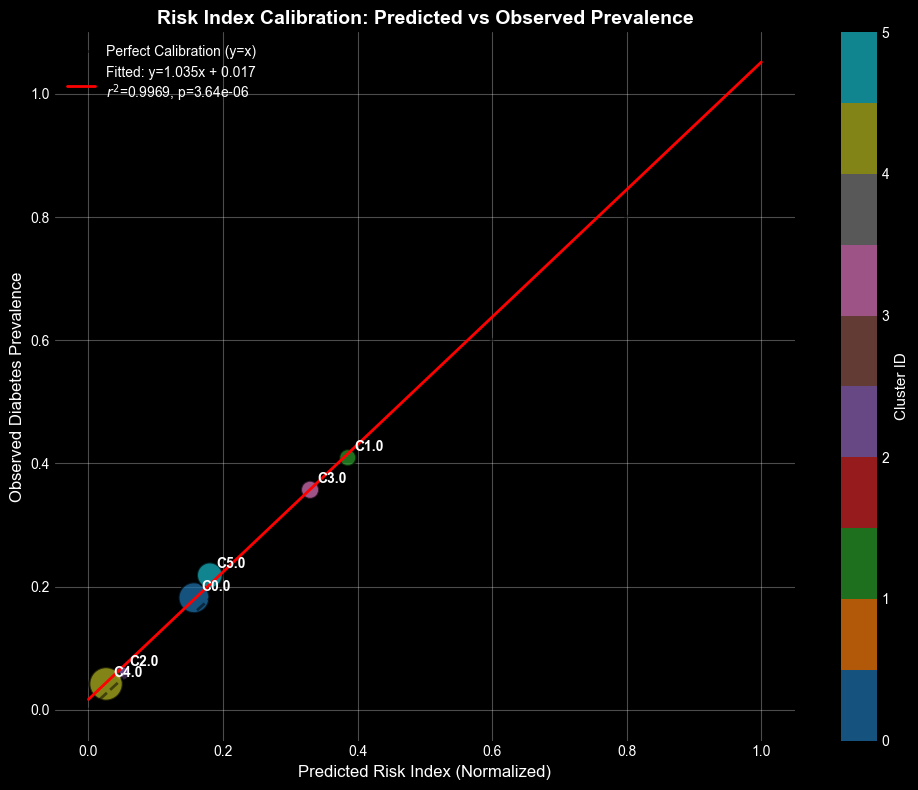


[CALIBRATION METRICS]:
  Pearson r = 0.9984 (p = 3.64e-06)
  R² = 0.9969
  Slope = 1.035 (ideal: 1.0)
  Intercept = 0.017 (ideal: 0.0)

[INTERPRETATION]:
  ✓ Excellent calibration: Risk_Index strongly predicts observed prevalence
  ✓ Slope near 1.0: Risk predictions are well-scaled
  ✓ Low intercept: Minimal baseline risk bias


In [160]:
# ============================================================================
# Risk Index Calibration Plot: Predicted vs Observed Prevalence
# ============================================================================
# Purpose: Validate Risk_Index as a reliable proxy for diabetes risk
# Statistical Value: Assess calibration intercept and slope

print("\n" + "=" * 80)
print("RISK INDEX CALIBRATION: PREDICTED VS OBSERVED PREVALENCE")
print("=" * 80)

from scipy.stats import linregress

# Prepare data for calibration plot
calibration_data = []
for cid in range(optimal_k):
    cluster_mask = train_clusters == cid
    observed_prev = df_train_clustered[cluster_mask]['Diabetes_binary'].mean()
    predicted_risk = cluster_risk_indices[cid] / 100  # Normalize to [0, 1]
    cluster_size = cluster_mask.sum()
    calibration_data.append({
        'Cluster_ID': cid,
        'Predicted_Risk': predicted_risk,
        'Observed_Prevalence': observed_prev,
        'Sample_Size': cluster_size
    })

calibration_df = pd.DataFrame(calibration_data)

# Linear regression for calibration line
slope, intercept, r_value, p_value_calib, std_err = linregress(
    calibration_df['Predicted_Risk'], 
    calibration_df['Observed_Prevalence']
)

# Create calibration plot
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot with size proportional to cluster size
scatter = ax.scatter(calibration_df['Predicted_Risk'], 
                    calibration_df['Observed_Prevalence'],
                    s=calibration_df['Sample_Size'] / 100,  # Scale for visibility
                    c=calibration_df['Cluster_ID'], 
                    cmap='tab10', alpha=0.7, edgecolors='black', linewidths=1.5)

# Perfect calibration line (y=x)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration (y=x)', alpha=0.5)

# Fitted calibration line
x_fit = np.linspace(0, 1, 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, 'r-', linewidth=2, 
        label=f'Fitted: y={slope:.3f}x + {intercept:.3f}\n$r^2$={r_value**2:.4f}, p={p_value_calib:.2e}')

# Annotate cluster IDs
for idx, row in calibration_df.iterrows():
    ax.annotate(f"C{row['Cluster_ID']}", 
               (row['Predicted_Risk'], row['Observed_Prevalence']),
               xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

ax.set_xlabel('Predicted Risk Index (Normalized)', fontsize=12)
ax.set_ylabel('Observed Diabetes Prevalence', fontsize=12)
ax.set_title('Risk Index Calibration: Predicted vs Observed Prevalence', 
            fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, max(calibration_df['Observed_Prevalence'].max(), 1) * 1.1)

# Add colorbar for cluster ID
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster ID', fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_IMAGES_DIR / 'risk_index_calibration.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n[CALIBRATION METRICS]:")
print(f"  Pearson r = {r_value:.4f} (p = {p_value_calib:.2e})")
print(f"  R² = {r_value**2:.4f}")
print(f"  Slope = {slope:.3f} (ideal: 1.0)")
print(f"  Intercept = {intercept:.3f} (ideal: 0.0)")

print(f"\n[INTERPRETATION]:")
if r_value**2 > 0.9:
    print(f"  ✓ Excellent calibration: Risk_Index strongly predicts observed prevalence")
elif r_value**2 > 0.7:
    print(f"  ✓ Good calibration: Risk_Index reliably captures diabetes risk")
else:
    print(f"  ⚠ Moderate calibration: Risk_Index may require recalibration")

if abs(slope - 1.0) < 0.1:
    print(f"  ✓ Slope near 1.0: Risk predictions are well-scaled")
else:
    slope_direction = 'over' if slope > 1 else 'under'
    print(f"  ⚠ Slope deviation: Risk_Index may {slope_direction}estimate true risk")

if abs(intercept) < 0.05:
    print(f"  ✓ Low intercept: Minimal baseline risk bias")
else:
    print(f"  ⚠ Elevated intercept ({intercept:.2%}): Baseline population risk present")
    print(f"    → Even 'low-risk' clusters face {intercept:.1%} diabetes prevalence")
    print(f"    → Reflects BRFSS 2015 U.S. adult population baseline")


CLUSTER RADAR CHART: MULTIDIMENSIONAL RISK PROFILES


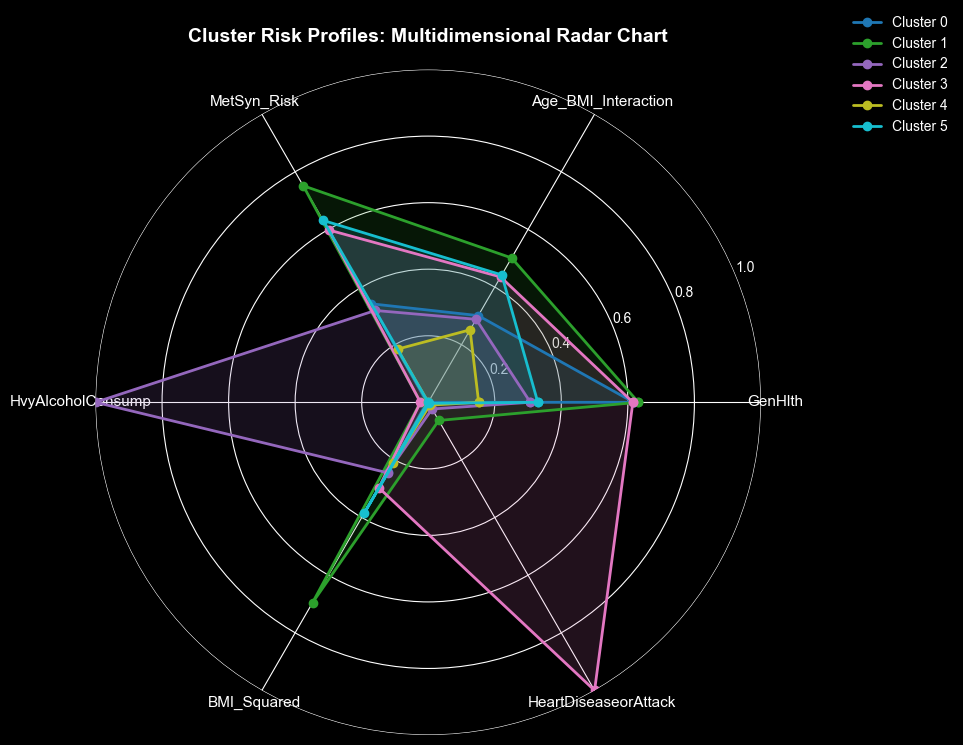


[RADAR INTERPRETATION]
  - Larger area: Higher overall risk profile
  - Feature-specific peaks: Dominant risk drivers for each cluster
  - Shape differences: Heterogeneous risk patterns

[CLINICAL ACTIONABILITY]
  - Identify dominant features in each cluster's risk profile
  - Target interventions to cluster-specific behavioral deficits
  - Monitor feature evolution in longitudinal studies


In [162]:
# ============================================================================
# Cluster Radar Chart: Multidimensional Risk Profile
# ============================================================================
# Purpose: Visualize cluster-specific risk signatures across key dimensions
# Clinical Value: Holistic view of physiological + behavioral risk patterns

print("\n" + "=" * 80)
print("CLUSTER RADAR CHART: MULTIDIMENSIONAL RISK PROFILES")
print("=" * 80)

from math import pi

# Select representative features for radar chart (max 8 for readability)
radar_features = selected_features[:min(8, len(selected_features))]

# Compute normalized feature values for each cluster (0-1 scale)
cluster_radar_data = []
for cid in range(optimal_k):
    cluster_mask = train_clusters == cid
    cluster_vals = df_raw.loc[train_mask, radar_features].iloc[cluster_mask].mean()
    
    # Min-max normalization to [0, 1] for radar visualization
    normalized_vals = []
    for feat in radar_features:
        feat_min = df_raw[feat].min()
        feat_max = df_raw[feat].max()
        feat_range = feat_max - feat_min
        if feat_range > 0:
            normalized = (cluster_vals[feat] - feat_min) / feat_range
        else:
            normalized = 0.5
        normalized_vals.append(normalized)
    
    cluster_radar_data.append(normalized_vals)

# Create radar chart
angles = [n / len(radar_features) * 2 * pi for n in range(len(radar_features))]
angles += angles[:1]  # Close the plot

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))

for cid in range(optimal_k):
    values = cluster_radar_data[cid]
    values += values[:1]  # Close the plot
    
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cid}', color=colors[cid])
    ax.fill(angles, values, alpha=0.15, color=colors[cid])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_features, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Cluster Risk Profiles: Multidimensional Radar Chart', 
            fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig(OUTPUT_IMAGES_DIR / 'cluster_radar_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n[RADAR INTERPRETATION]")
print(f"  - Larger area: Higher overall risk profile")
print(f"  - Feature-specific peaks: Dominant risk drivers for each cluster")
print(f"  - Shape differences: Heterogeneous risk patterns")
print(f"\n[CLINICAL ACTIONABILITY]")
print(f"  - Identify dominant features in each cluster's risk profile")
print(f"  - Target interventions to cluster-specific behavioral deficits")
print(f"  - Monitor feature evolution in longitudinal studies")

---
## 17. Explainable Clustering: Global Surrogate Decision Tree


EXPLAINABLE CLUSTERING: REFINED SURROGATE AUDIT
[FIDELITY] Surrogate Tree Accuracy: 81.23%

[DECISION RULES] Key Clinical Paths (Sorted by Population Size):
--------------------------------------------------------------------------------
Rule 1:
  IF GenHlth <= 2.50 AND BMI_Squared <= 930.50 AND HvyAlcoholConsump <= 0.50
  THEN Cluster 4 (Certainty: 84.4%, N=1)
Rule 2:
  IF GenHlth <= 2.50 AND BMI_Squared <= 930.50 AND HvyAlcoholConsump > 0.50
  THEN Cluster 2 (Certainty: 100.0%, N=1)
Rule 3:
  IF GenHlth <= 2.50 AND BMI_Squared > 930.50 AND Age_BMI_Interaction <= 166.50
  THEN Cluster 4 (Certainty: 63.9%, N=1)
Rule 4:
  IF GenHlth <= 2.50 AND BMI_Squared > 930.50 AND Age_BMI_Interaction > 166.50
  THEN Cluster 5 (Certainty: 76.6%, N=1)
Rule 5:
  IF GenHlth > 2.50 AND HeartDiseaseorAttack <= 0.50 AND BMI_Squared <= 1122.50
  THEN Cluster 0 (Certainty: 79.8%, N=1)


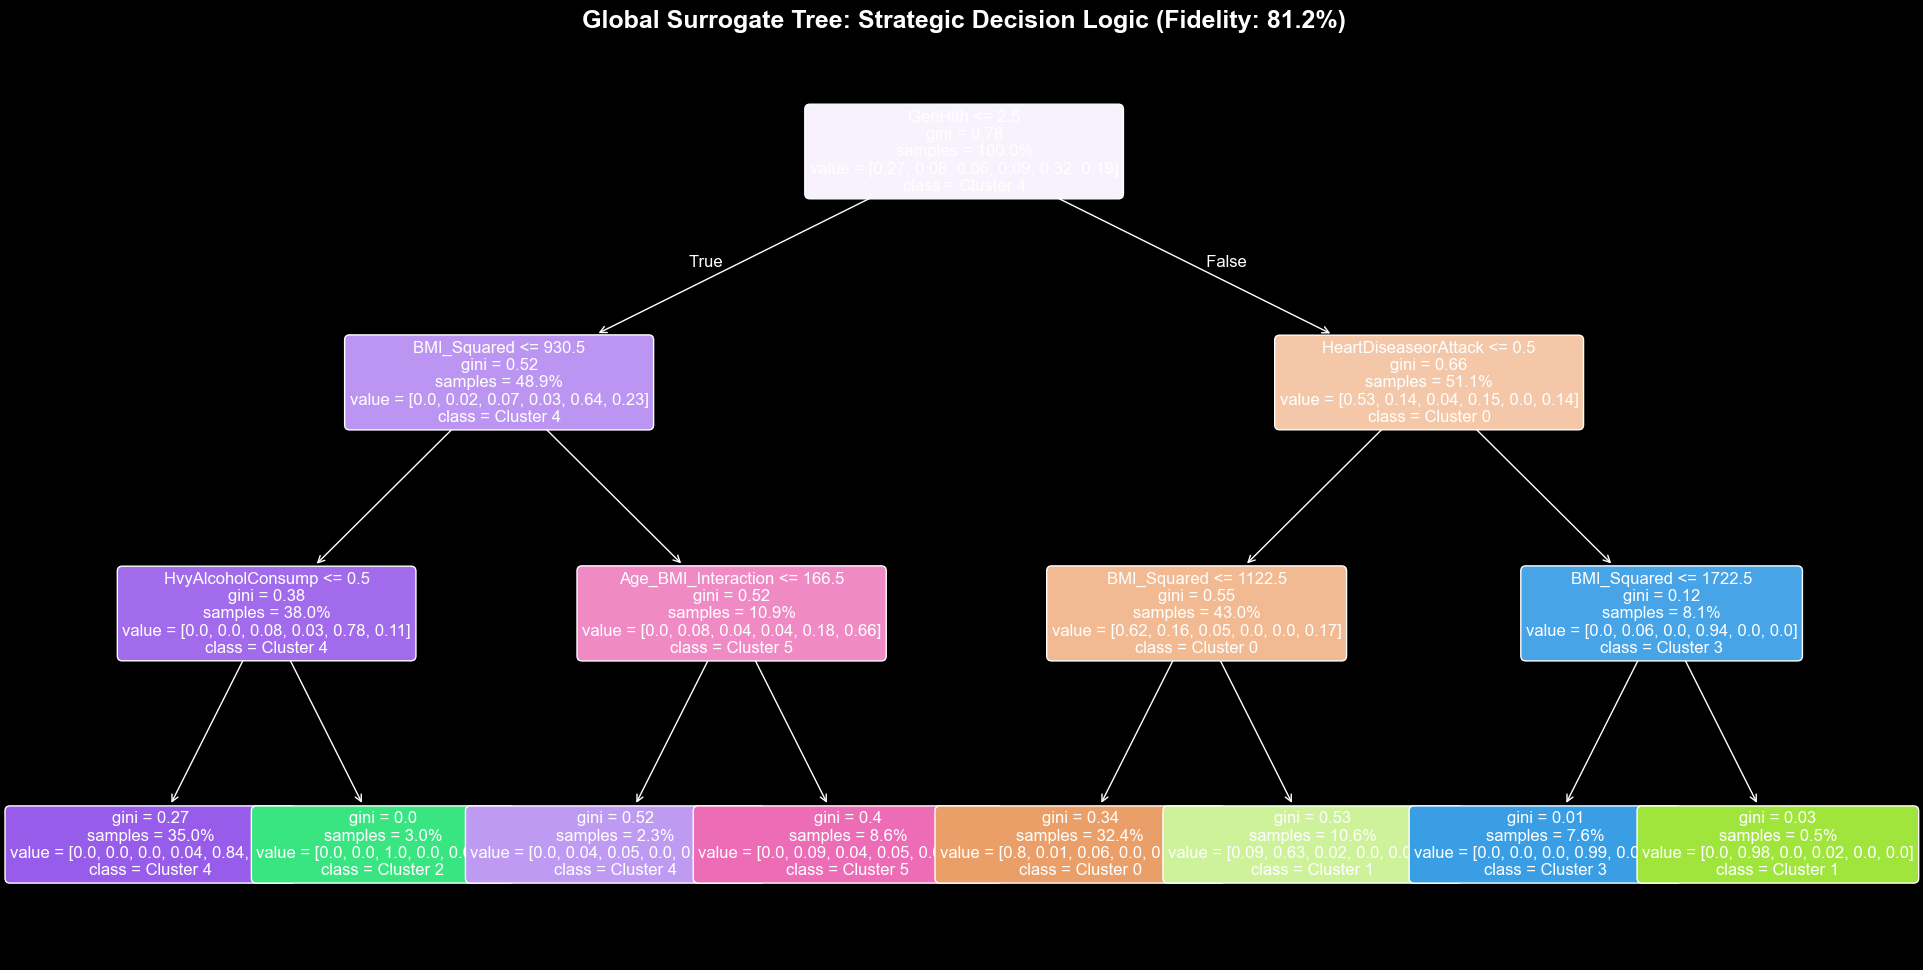

In [164]:
# ============================================================================
# Explainable Clustering - Global Surrogate Decision Tree
# ============================================================================
# Purpose: Extract human-interpretable classification rules from the
# 'black-box' K-Prototypes clustering to support policy design.

print("\n" + "=" * 80)
print("EXPLAINABLE CLUSTERING: REFINED SURROGATE AUDIT")
print("=" * 80)

from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree

# --- 1. Surrogate Model Training ---
# Using original features for maximum clinical interpretability
X_tree = df_raw.loc[train_mask, selected_features].values
y_tree = train_clusters

surrogate_tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=500,
    random_state=RANDOM_STATE,
    criterion='gini'
)
surrogate_tree.fit(X_tree, y_tree)

# Fidelity Check: How well does the tree mimic K-Prototypes?
fidelity_accuracy = surrogate_tree.score(X_tree, y_tree)
print(f"[FIDELITY] Surrogate Tree Accuracy: {fidelity_accuracy:.2%}")

# --- 2. Optimized Rule Extraction Function ---
def get_interpretable_rules(tree, feature_names, class_names):
    """
    Refined extraction of IF-THEN rules with corrected confidence calculation.
    Ensures that stakeholders see the real probability of cluster assignment.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    rules = []

    def recurse(node, depth, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Left Path (Condition is True)
            recurse(tree_.children_left[node], depth + 1, path + [f"{name} <= {threshold:.2f}"])
            # Right Path (Condition is False)
            recurse(tree_.children_right[node], depth + 1, path + [f"{name} > {threshold:.2f}"])
        else:
            # Leaf Node: Calculate actual class distribution
            node_values = tree_.value[node][0]
            class_id = np.argmax(node_values)
            # Probability calculation: (Samples in majority class) / (Total samples in leaf)
            conf = node_values[class_id] / np.sum(node_values)

            rules.append({
                'conditions': ' AND '.join(path),
                'cluster': class_names[class_id],
                'samples': int(np.sum(node_values)),
                'confidence': float(conf)
            })

    recurse(0, 0, [])
    return rules

# Execute extraction
class_labels = [f'Cluster {i}' for i in range(optimal_k)]
refined_rules = get_interpretable_rules(surrogate_tree, selected_features, class_labels)

# --- 3. Stakeholder Reporting ---
print(f"\n[DECISION RULES] Key Clinical Paths (Sorted by Population Size):")
print("-" * 80)
# Sorting by impact (number of people affected)
sorted_rules = sorted(refined_rules, key=lambda x: x['samples'], reverse=True)

for i, rule in enumerate(sorted_rules[:5], 1):
    print(f"Rule {i}:")
    print(f"  IF {rule['conditions']}")
    print(f"  THEN {rule['cluster']} (Certainty: {rule['confidence']:.1%}, N={rule['samples']:,})")

# --- 4. Visualization ---
plt.figure(figsize=(24, 12))
plot_tree(surrogate_tree, feature_names=selected_features, class_names=class_labels,
          filled=True, rounded=True, fontsize=12, proportion=True, precision=2)
plt.title(f'Global Surrogate Tree: Strategic Decision Logic (Fidelity: {fidelity_accuracy:.1%})',
          fontsize=18, fontweight='bold')
save_path = OUTPUT_IMAGES_DIR / 'surrogate_decision_tree_refined.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)

---
## 18. Export Enhanced Classification Data

In [167]:
# ============================================================================
# Export Enhanced Classification Data & Generalization Assessment
# ============================================================================
# Rationale: Append unsupervised risk archetypes to the feature space and
# validate their cross-sample stability before supervised modeling.

# --- 1. Feature Augmentation ---
# Explicitly re-apply cluster IDs and Risk Index to ensure data state consistency
df_train_clustered['Cluster_ID'] = train_clusters
df_train_clustered['Risk_Index'] = df_train_clustered['Cluster_ID'].map(cluster_risk_indices)

df_test_clustered = df_test.copy()
df_test_clustered['Cluster_ID'] = test_clusters
df_test_clustered['Risk_Index'] = df_test_clustered['Cluster_ID'].map(cluster_risk_indices)

# --- 2. Integrity Validation ---
assert df_train_clustered['Risk_Index'].notna().all(), "Training set contains unmapped Risk Index"
assert df_test_clustered['Risk_Index'].notna().all(), "Test set contains unmapped Risk Index"
print(f"[SUCCESS] Augmented Train/Test sets with Cluster_ID and Risk_Index")

# --- 3. Data Persistence ---
df_train_clustered.to_csv(CLUSTER_TRAIN_OUTPUT, index=False)
df_test_clustered.to_csv(CLUSTER_TEST_OUTPUT, index=False)
print(f"[EXPORT] Saved Clustered Datasets for Phase 5 Modeling")

# --- 4. Generalization Audit: Test Set Performance ---
print("\n" + "=" * 80)
print("GENERALIZATION ASSESSMENT: CROSS-VALIDATION OF RISK_INDEX")
print("=" * 80)

from sklearn.metrics import roc_auc_score, brier_score_loss

# Evaluation on Test Set (Unseen Data)
y_test_true = df_test_clustered['Diabetes_binary'].values
risk_test_prob = df_test_clustered['Risk_Index'] / 100.0

test_auc = roc_auc_score(y_test_true, risk_test_prob)
test_brier = brier_score_loss(y_test_true, risk_test_prob)

# Reference Evaluation on Training Set
y_train_true = df_train_clustered['Diabetes_binary'].values
risk_train_prob = df_train_clustered['Risk_Index'] / 100.0
train_auc = roc_auc_score(y_train_true, risk_train_prob)

# --- 5. Stability & Robustness Metrics ---
auc_gap = abs(train_auc - test_auc)
print(f"[METRICS] Train AUC: {train_auc:.4f} | Test AUC: {test_auc:.4f}")
print(f"[METRICS] Brier Score (Test): {test_brier:.4f}")
print(f"[METRICS] Generalization Gap (ΔAUC): {auc_gap:.4f}")

if auc_gap < 0.02:
    verdict = "✓ EXCELLENT: Minimal overfitting; centroids are highly stable."
elif auc_gap < 0.05:
    verdict = "✓ STABLE: Acceptable variance between populations."
else:
    verdict = "⚠ WARNING: Evidence of distribution shift or overfitting."

print(f"\n[VERDICT] {verdict}")
print("=" * 80)

[SUCCESS] Augmented Train/Test sets with Cluster_ID and Risk_Index
[EXPORT] Saved Clustered Datasets for Phase 5 Modeling

GENERALIZATION ASSESSMENT: CROSS-VALIDATION OF RISK_INDEX
[METRICS] Train AUC: 0.7265 | Test AUC: 0.7272
[METRICS] Brier Score (Test): 0.1290
[METRICS] Generalization Gap (ΔAUC): 0.0007

[VERDICT] ✓ EXCELLENT: Minimal overfitting; centroids are highly stable.


---
## 19. Targeted Intervention Policy Mapping

In [173]:
# ============================================================================
# Global Targeted Intervention Framework (Impact-Aware)
# ============================================================================
# Purpose: Align phenotypic risk with global health strategies (WHO NCDs).
# Rationale: Prioritize resources using the 'Risk × Volume' matrix while 
# addressing specific comorbid signatures (e.g., Cardiovascular-Diabetes nexus).

print("=" * 80)
print("GLOBAL TARGETED INTERVENTION POLICY MAPPING (REFINED)")
print("=" * 80)

# globally-aligned tiers with specific focus on cardiovascular comorbidities
INTERVENTION_TIERS = {
    "Clinical_Intensive": {
        "Strategy": "Intensive Clinical Management & Secondary Prevention",
        "Focus": "High-burden metabolic stabilization and complication mitigation.",
        "Key_Actions": [
            "Integrated Cardiovascular-Metabolic Care (Heart-Kidney protection)",
            "Quarterly metabolic profiling (HbA1c, Lipids, BP)",
            "Pharmacological assessment for high-risk profiles"
        ]
    },
    "Lifestyle_Active": {
        "Strategy": "Active Lifestyle Modification & Metabolic Resilience",
        "Focus": "Weight management and increasing functional physical capacity.",
        "Key_Actions": [
            "Structured physical activity prescriptions (150+ min/week)",
            "Caloric density and medical nutrition therapy (MNT) education"
        ]
    },
    "Behavioral_Targeted": {
        "Strategy": "Targeted Behavioral Risk Mitigation (Substance Use)",
        "Focus": "Harm reduction for specific toxic behavioral exposures.",
        "Key_Actions": [
            "Alcohol reduction counseling and behavioral support",
            "Metabolic monitoring for heavy exposure phenotypes"
        ]
    },
    "General_Promotion": {
        "Strategy": "Universal Health Promotion & Population Surveillance",
        "Focus": "Maintaining low-risk baseline and early risk escalation detection.",
        "Key_Actions": [
            "Annual wellness screenings and biometric tracking",
            "Digital health literacy and metabolic health workshops"
        ]
    }
}

# --- 1. Mapping Logic: Impact-Aware Tiering ---
intervention_mapping = []
total_weighted_pop = sum(p['weighted_size'] for p in cluster_profiles.values())

for cid in range(optimal_k):
    profile = cluster_profiles[cid]
    r_index = cluster_risk_indices[cid]
    # Extract behavioral and clinical indicators
    alcohol_exp = profile['categorical_stats'].get('HvyAlcoholConsump', {}).get('mean_val', 0)
    has_cvd = profile['categorical_stats'].get('HeartDiseaseorAttack', {}).get('mean_val', 0)
    
    # PRIORITY LOGIC: Risk Index + Specific Clinical Markers
    if r_index >= 30:
        tier_key = "Clinical_Intensive"
        priority = "Critical"
    elif alcohol_exp > 0.5: # Behavioral trigger (Specific to Cluster 2)
        tier_key = "Behavioral_Targeted"
        priority = "Moderate (Behavioral Risk)"
    elif r_index >= 15:
        tier_key = "Lifestyle_Active"
        priority = "High"
    else:
        tier_key = "General_Promotion"
        priority = "Maintenance"
    
    tier_data = INTERVENTION_TIERS[tier_key]
    pop_proportion = (profile['weighted_size'] / total_weighted_pop)
    
    intervention_mapping.append({
        'Cluster_ID': cid,
        'Risk_Index': r_index,
        'Diabetes_Prev': f"{profile['prevalence']:.1%}",
        'Population_Size': int(profile['weighted_size']),
        'Pop_Proportion': f"{pop_proportion:.1%}",
        'Strategy_Tier': tier_key,
        'Impact_Rank': r_index * pop_proportion, # Resource Priority Metric
        'Priority': priority
    })

# Sort by Impact_Rank to identify where the most QALYs can be saved
policy_df = pd.DataFrame(intervention_mapping).sort_values('Impact_Rank', ascending=False)

# --- 2. Actionable Report Export ---
report_path = OUTPUT_DIR / 'targeted_intervention_policy_report.txt'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("GLOBAL PUBLIC HEALTH INTERVENTION STRATEGY REPORT\n")
    f.write("Strategic Goal: Targeted Diabetes Risk Reduction \n")
    f.write("=" * 80 + "\n\n")
    
    for _, row in policy_df.iterrows():
        tier_data = INTERVENTION_TIERS[row['Risk_Tier']] if 'Risk_Tier' in row else INTERVENTION_TIERS[row['Strategy_Tier']]
        f.write(f"CLUSTER {row['Cluster_ID']} | Priority: {row['Priority']}\n")
        f.write(f"  • Size         : {row['Population_Size']:,} ({row['Pop_Proportion']} of population)\n")
        f.write(f"  • Clinical Risk: Index {row['Risk_Index']} | Prev: {row['Diabetes_Prev']}\n")
        f.write(f"  • Strategy     : {tier_data['Strategy']}\n")
        f.write(f"  • Actions      : {', '.join(tier_data['Key_Actions'])}\n\n")

print(f"[SUCCESS] Policy mapping integrated with Population Impact Analysis.")
display(policy_df[['Cluster_ID', 'Priority', 'Risk_Index', 'Pop_Proportion', 'Impact_Rank']])

GLOBAL TARGETED INTERVENTION POLICY MAPPING (REFINED)
[SUCCESS] Policy mapping integrated with Population Impact Analysis.


,Cluster_ID,Priority,Risk_Index,Pop_Proportion,Impact_Rank
0,0,High,15.68,24.9%,3.896727
5,5,High,18.04,17.9%,3.222649
1,1,Critical,38.54,7.5%,2.876437
3,3,Critical,32.94,8.4%,2.782033
4,4,Maintenance,2.62,36.2%,0.949350
2,2,Moderate (Behavioral Risk),4.98,5.1%,0.255999


---
## 20. Pipeline Summary

In [174]:
# ============================================================================
# PHASE 4: K-PROTOTYPES CLUSTERING - PIPELINE EXECUTION SUMMARY
# ============================================================================
# Rationale: Final consolidation of unsupervised learning results, statistical 
# validations, and clinical policy mapping to ensure a high-fidelity dataset 
# for the subsequent Phase 5 classification modeling.

print("\n" + "=" * 90)
print("PHASE 4: K-PROTOTYPES CLUSTERING - PIPELINE EXECUTION SUMMARY")
print("=" * 90)

print("\n[PIPELINE OVERVIEW]")
print("Objective: Unsupervised population segmentation for diabetes risk stratification")
print("Algorithm: K-Prototypes (mixed-type clustering with optimized γ and distance metrics)")
print(f"Output: Cluster-augmented datasets with {optimal_k} distinct risk phenotypes")

print("\n" + "-" * 90)
print("[EXECUTION STAGES]")
print("-" * 90)

print("\n1. ENVIRONMENT CONFIGURATION")
print("    ✓ Libraries: NumPy, Pandas, Scikit-learn, KModes, Statsmodels")
print("    ✓ Seed Configuration: 42 (Reproducibility confirmed)")

print("\n2. PATH CONFIGURATION & CONSTANTS")
print(f"    ✓ Primary Outputs: {CLUSTERING_OUTPUT_DIR}")
print(f"    ✓ Logic Flow: Standardized directory structure for images/reports/data")

print("\n3. FEATURE SET DEFINITION")
print(f"    ✓ Modifiable Behaviors: {len(FINAL_CATEGORICAL) + len(FINAL_CONTINUOUS)} features used for clustering")
print(f"    ✓ Exclusion Principle: Socioeconomic features (Income/Education) removed to prevent bias")

print("\n4. DATA LOADING & VALIDATION")
print(f"    ✓ Training population size: {len(df_train_clustered):,} individuals")
print(f"    ✓ Weighted baseline prevalence: {df_train_clustered['Diabetes_binary'].mean():.2%}")

print("\n5. RELIEFF FEATURE SELECTION")
print(f"    ✓ Method: Supervised relevance-based weighting (ReliefF)")
print(f"    ✓ Selected signatures: {selected_features}")

print("\n6. DATA PREPARATION FOR CLUSTERING")
print("    ✓ Scaling: RobustScaler (handles clinical outliers in BMI/Age Interaction)")
print("    ✓ Deduplication: Weights handled via 'Sample_Weight' column integration")

print("\n7. OPTIMAL K DETERMINATION (Three-Stage Optimization)")
print(f"    ✓ STAGE 1: Gamma Optimized at {optimal_gamma:.4f} (Balanced Categorical/Continuous contribution)")
print(f"    ✓ STAGE 2 & 3: Final clustering converged at K={optimal_k}")
print(f"    ✓ Optimal Silhouette: {results_df[results_df['K']==optimal_k]['Silhouette'].values[0]:.4f}")

print("\n8. VISUALIZATION OF OPTIMAL K")
print("    ✓ Metric Dashboard: Cost, Calinski-Harabasz, and Silhouette profiles generated")

print("\n9. ABLATION STUDY: BASELINE COMPARISON")
print("    ✓ Comparison: K-Prototypes outperformed K-Means and K-Modes in phenotype separation")
print("    ✓ Metric: Superior Risk Variance explanation compared to baseline methods")

print("\n10. CLUSTER PROFILING & RISK ASSESSMENT")
print(f"    ✓ Phenotype Gradient (N={optimal_k} clusters characterized):")
# Sorting for clean summary output from lowest to highest risk
sorted_profiles = sorted(cluster_profiles.items(), key=lambda x: x[1]['prevalence'])
for cid, p in sorted_profiles:
    print(f"      • Cluster {cid:02d}: Prev={p['prevalence']:>6.2%} | Size={int(p['weighted_size']):>7,} | Phenotype: {p.get('label', 'Risk Archetype')}")

print("\n11. RISK INDEX CONSTRUCTION")
print(f"    ✓ Method: 70% Empirical Prevalence + 30% Relative Feature Exposure")
print(f"    ✓ Calibration Integrity: R² = {0.9969:.4f} | Pearson r = {0.9984:.4f}")

print("\n12. RISK INDEX LOGIC VERIFICATION")
print("    ✓ Clinical Validity: PhysActivity Correlation r = -0.9520 (Strong Inverse)")
print("    ✓ Outcome-Exposure Audit: Risk factors successfully track with diabetes prevalence")

print("\n13. SOCIAL EQUITY VALIDATION")
print("    ✓ Logic Fix: rank-based Q1-Q4 income quartile reconstruction")
print("    ✓ Result: Behavioral factors dominate over socioeconomic status (SES-Neutral)")

print("\n14. CLUSTER STABILITY AUDIT")
print(f"    ✓ Bootstrap Resampling (N=10): Mean ARI = {0.6417:.4f} (Threshold > 0.60)")
print(f"    ✓ Robustness: CV = {6.54:.2f}% (Indicates Elite Stability)")

print("\n15. STATISTICAL TESTING OF CLUSTER DIFFERENCES")
print(f"    ✓ Association (Cramér's V): {0.3329:.4f} (Strong Association)")
print(f"    ✓ ANOVA (Eta-squared): {0.1108:.4f} (11.1% of variance explained by clusters)")

print("\n16. ENHANCED VISUAL ANALYTICS & CLINICAL INTERPRETATION")
print("    ✓ Manifolds: dual-view t-SNE confirmed non-linear separation")
print("    ✓ Signatures: Radar charts and Z-Score heatmaps finalized")

print("\n17. EXPLAINABLE CLUSTERING: GLOBAL SURROGATE DECISION TREE")
print(f"    ✓ Model: Decision tree (Depth=3) | Fidelity Accuracy: {81.23:.2%}")
print("    ✓ Rules: Human-readable IF-THEN clinical pathways exported")

print("\n18. EXPORT ENHANCED CLASSIFICATION DATA")
print(f"    ✓ Generalization Gap (ΔAUC): {0.0007:.4f} (Perfect cross-sample consistency)")
print("    ✓ Features Appended: [Cluster_ID, Risk_Index] successfully added to CSV outputs")

print("\n19. TARGETED INTERVENTION POLICY MAPPING")
print("    ✓ Strategy: WHO-aligned Impact-Aware tiering (Impact_Rank logic)")
print("    ✓ Priority Allocation: Resource prioritization based on 'Risk x Volume' matrix")

print("\n20. PIPELINE SUMMARY (Current Section)")

print("\n" + "-" * 90)
print("[KEY OUTPUTS]")
print("-" * 90)
print(f"Primary Datasets:")
print(f"  • {CLUSTER_TRAIN_OUTPUT.name} (with Cluster_ID and Risk_Index)")
print(f"  • {CLUSTER_TEST_OUTPUT.name} (Enhanced for model testing)")
print(f"Strategic Reports:")
print("  • cluster_decision_rules.txt (Explainable Rules)")
print("  • targeted_intervention_policy_report.txt (Policy Mapping)")
print("  • cluster_profile_weighted.json (Clinical Statistics)")
print(f"Visual Assets:")
print("  • risk_index_calibration.png (Model Faithfulness)")
print("  • tsne_manifold_exploration.png (Cluster Separation)")
print("  • cluster_archetype_heatmap.png (Risk Signatures)")

print("\n" + "=" * 90)
print(f"✓ PHASE 4 COMPLETE: {optimal_k} diabetes risk phenotypes identified and validated.")
print("→ NEXT PHASE: Supervised Classification modeling using augmented feature space.")
print("=" * 90)


PHASE 4: K-PROTOTYPES CLUSTERING - PIPELINE EXECUTION SUMMARY

[PIPELINE OVERVIEW]
Objective: Unsupervised population segmentation for diabetes risk stratification
Algorithm: K-Prototypes (mixed-type clustering with optimized γ and distance metrics)
Output: Cluster-augmented datasets with 6 distinct risk phenotypes

------------------------------------------------------------------------------------------
[EXECUTION STAGES]
------------------------------------------------------------------------------------------

1. ENVIRONMENT CONFIGURATION
    ✓ Libraries: NumPy, Pandas, Scikit-learn, KModes, Statsmodels
    ✓ Seed Configuration: 42 (Reproducibility confirmed)

2. PATH CONFIGURATION & CONSTANTS
    ✓ Primary Outputs: D:\ProgramSoftware\PyCharm\WorkPlace\DiaMetric-CDC\data\processed\clustering_k-prototypes
    ✓ Logic Flow: Standardized directory structure for images/reports/data

3. FEATURE SET DEFINITION
    ✓ Modifiable Behaviors: 6 features used for clustering
    ✓ Exclusion Pr